<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Libraries" data-toc-modified-id="Libraries-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Libraries</a></span></li><li><span><a href="#Split-Train/Test/Validation" data-toc-modified-id="Split-Train/Test/Validation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Split Train/Test/Validation</a></span></li><li><span><a href="#Baseline-model" data-toc-modified-id="Baseline-model-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Baseline model</a></span></li><li><span><a href="#Models-Training" data-toc-modified-id="Models-Training-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Models Training</a></span><ul class="toc-item"><li><span><a href="#Light-Gradient-Boosting-Machine-(LGBM)" data-toc-modified-id="Light-Gradient-Boosting-Machine-(LGBM)-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Light Gradient Boosting Machine (LGBM)</a></span></li></ul></li></ul></div>

# Libraries

In [2]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

# Split Train/Test/Validation

In [3]:
data = pd.read_csv('data/eda_dataset_imputed.csv')

app_train, test_1 = train_test_split(data, test_size=0.30, random_state=64)
app_test, app_validation = train_test_split(test_1, test_size=0.5, random_state=56)

In [4]:
app_train.shape, app_test.shape, app_validation.shape

((215257, 450), (46127, 450), (46127, 450))

# Baseline model

In [5]:
train_labels = app_train['TARGET']
test_labels = app_test['TARGET']

In [7]:
from sklearn.preprocessing import MinMaxScaler, Imputer

# Drop the target from the training data
if 'TARGET' in app_train:
    train = app_train.drop(['TARGET'], axis=1)
else:
    train = app_train.copy()

    
if 'TARGET' in app_test:
    test = app_test.drop(['TARGET'], axis=1)
else:
    test = app_test.copy()

    
# Feature names
features = list(train.columns)

# Median imputation of missing values
imputer = Imputer(strategy = 'median')

# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))

# Fit on the training data
imputer.fit(train)

# Transform both training and testing data
train = imputer.transform(train)
test = imputer.transform(test)

# Repeat with the scaler
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

print('Training data shape: ', train.shape)
print('Testing data shape: ', test.shape)

Training data shape:  (215257, 449)
Testing data shape:  (46127, 449)


In [8]:
from sklearn.linear_model import LogisticRegression

# Make the model with the specified regularization parameter
log_reg = LogisticRegression(C = 0.0001)

# Train on the training data
log_reg.fit(train, train_labels)

LogisticRegression(C=0.0001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [9]:
# Make predictions
# Make sure to select the second column only
log_reg_pred = log_reg.predict_proba(test)[:, 1]

In [10]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_absolute_error

print("ROC AUC: ", roc_auc_score(test_labels, log_reg_pred))
print("MAE: ", mean_absolute_error(test_labels, log_reg_pred))

ROC AUC:  0.713790323186
MAE:  0.149072307289


# Models Training

## Light Gradient Boosting Machine (LGBM)

In [15]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
from sklearn.utils.multiclass import type_of_target

import gc

def model(features, test_features, lgbm_params, n_folds = 5): 
    """Train and test a light gradient boosting model using
    cross validation. 
    
    Parameters
    --------
        features (pd.DataFrame): 
            dataframe of training features to use 
            for training a model. Must include the TARGET column.
        test_features (pd.DataFrame): 
            dataframe of testing features to use
            for making predictions with the model. 
        
    Return
    --------
        feature_importances (pd.DataFrame): 
            dataframe with the feature importances from the model.
        valid_metrics (pd.DataFrame): 
            dataframe with training and validation metrics (ROC AUC) for each fold and overall.
        
    """
    
    # Extract the ids
    train_ids = features['SK_ID_CURR']
    test_ids = test_features['SK_ID_CURR']
    
    # Extract the labels for training
    labels = np.array(features['TARGET'].astype(int))
    
    # Remove the ids and target
    features = features.drop(['SK_ID_CURR', 'TARGET'], axis=1)
    test_features = test_features.drop(['SK_ID_CURR', 'TARGET'], axis=1)
    
    print('Training Data Shape: ', features.shape)
    print('Testing Data Shape: ', test_features.shape)
    
    # Extract feature names
    feature_names = list(features.columns)
    
    # Convert to np arrays
    features = np.array(features)
    test_features = np.array(test_features)
    
    # Create the kfold object
    k_fold = KFold(n_splits = n_folds, shuffle = True, random_state = 50)
    
    # Empty array for feature importances
    feature_importance_values = np.zeros(len(feature_names))
    
    # Empty array for test predictions
    test_predictions = np.zeros(test_features.shape[0])
    
    # Empty array for out of fold validation predictions
    out_of_fold = np.zeros(features.shape[0])
    
    # Lists for recording validation and training scores
    valid_scores = []
    train_scores = []
    
    # Iterate through each fold
    for train_indices, valid_indices in k_fold.split(features):
        
        # Training data for the fold
        train_features, train_labels = features[train_indices], labels[train_indices]
        # Validation data for the fold
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]
        
        # Create the model
        model = lgb.LGBMClassifier(application="binary", boosting_type=lgbm_params["boosting"],
                          learning_rate=lgbm_params["learning_rate"],n_estimators=lgbm_params["n_estimators"],
                          reg_alpha = lgbm_params["reg_alpha"], reg_lambda = lgbm_params["reg_lambda"], 
                          drop_rate=lgbm_params["drop_rate"],
                          num_leaves=lgbm_params["num_leaves"], max_depth=lgbm_params["max_depth"],
                          max_bin=lgbm_params["max_bin"],
                          subsample = 0.8, n_jobs = -1, random_state = 50)
        
        # Train the model
        model.fit(train_features, train_labels, eval_metric = ['auc', 'mae'],
                  eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                  eval_names = ['valid', 'train'],
                  early_stopping_rounds = 200, verbose = 200)
        
        # Record the best iteration
        best_iteration = model.best_iteration_
        
        # Record the feature importances
        feature_importance_values += model.feature_importances_ / k_fold.n_splits
        
        # Make predictions
        test_predictions += model.predict_proba(test_features, num_iteration = best_iteration)[:, 1] / k_fold.n_splits
        
        # Record the out of fold predictions
        out_of_fold[valid_indices] = model.predict_proba(valid_features, num_iteration = best_iteration)[:, 1]
        
        # Record the best score
        valid_score = model.best_score_['valid']['auc']
        train_score = model.best_score_['train']['auc']
        
        valid_scores.append(valid_score)
        train_scores.append(train_score)
        
        # Clean up memory
        gc.enable()
        del model, train_features, valid_features
        gc.collect()
        
    # Make the feature importance dataframe
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
    
    # Overall validation score
    valid_auc = roc_auc_score(labels, out_of_fold)
    
    # Add the overall scores to the metrics
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))
    
    # Needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    # Dataframe of validation scores
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores}) 
    
    return feature_importances, metrics

In [16]:
def plot_feature_importances(df):
    """
    Plot importances returned by a model. This can work with any measure of
    feature importance provided that higher importance is better. 
    
    Args:
        df (dataframe): feature importances. Must have the features in a column
        called `features` and the importances in a column called `importance
        
    Returns:
        shows a plot of the 15 most importance features
        
        df (dataframe): feature importances sorted by importance (highest to lowest) 
        with a column for normalized importance
        """
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df

Training Data Shape:  (215257, 448)
Testing Data Shape:  (46127, 448)
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.13828	valid's auc: 0.754166	train's l1: 0.130299	train's auc: 0.878715
Early stopping, best iteration is:
[192]	valid's l1: 0.137714	valid's auc: 0.754396	train's l1: 0.129895	train's auc: 0.877069
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.138973	valid's auc: 0.751239	train's l1: 0.129854	train's auc: 0.878984
[400]	valid's l1: 0.137259	valid's auc: 0.75119	train's l1: 0.123386	train's auc: 0.919337
Early stopping, best iteration is:
[285]	valid's l1: 0.138821	valid's auc: 0.751671	train's l1: 0.127401	train's auc: 0.899392
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.138045	valid's auc: 0.740117	train's l1: 0.130667	train's auc: 0.87692
[400]	valid's l1: 0.1364	valid's auc: 0.741486	train's l1: 0.123798	train's auc: 0.917226
[600]	valid's l1: 0.134829	valid

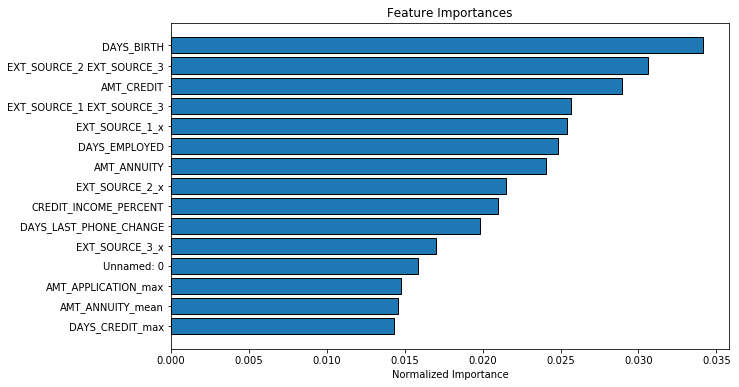

In [17]:
lgbm_params = {
    "boosting":"dart",
    "application":"binary",
    "learning_rate": 0.1,
    'reg_alpha':0.01,
    'reg_lambda': 0.01,
    "n_estimators":10000,
    "max_depth":7,
    "num_leaves":100,
    "max_bin":225,
    "drop_rate":0.02
}

fi, metrics = model(app_train, app_test, lgbm_params=lgbm_params)
print('Baseline metrics')
print(metrics)
fi_sorted = plot_feature_importances(fi)

Training Data Shape:  (215257, 448)
Testing Data Shape:  (46127, 448)
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.133782	valid's auc: 0.7506	train's l1: 0.120064	train's auc: 0.912934
Early stopping, best iteration is:
[86]	valid's l1: 0.135583	valid's auc: 0.754204	train's l1: 0.128797	train's auc: 0.857283
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.134541	valid's auc: 0.748257	train's l1: 0.119671	train's auc: 0.911534
Early stopping, best iteration is:
[97]	valid's l1: 0.13609	valid's auc: 0.750568	train's l1: 0.127534	train's auc: 0.864312
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.133348	valid's auc: 0.739781	train's l1: 0.120461	train's auc: 0.909081
Early stopping, best iteration is:
[98]	valid's l1: 0.134877	valid's auc: 0.741182	train's l1: 0.127649	train's auc: 0.865789
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.134689	

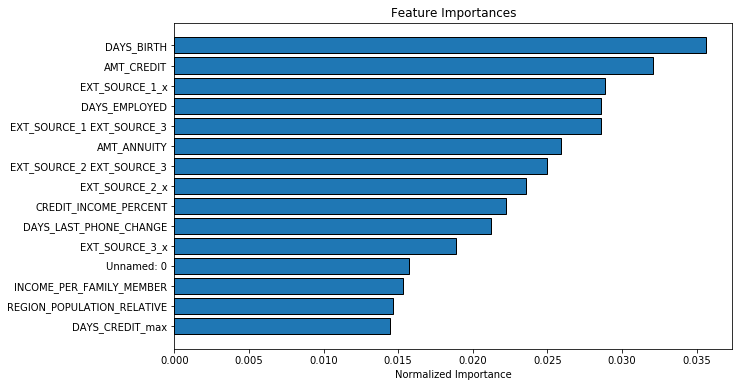

In [18]:
lgbm_params = {
    "boosting":"gbdt",
    "application":"binary",
    "learning_rate": 0.1,
    'reg_alpha':0.1,
    'reg_lambda': 0.1,
    "n_estimators":10000,
    "max_depth":7,
    "num_leaves":200,
    "max_bin":225,
    "drop_rate":0.02
}

fi, metrics = model(app_train, app_test, lgbm_params=lgbm_params)
print('Baseline metrics')
print(metrics)
fi_sorted = plot_feature_importances(fi)

Training Data Shape:  (215257, 448)
Testing Data Shape:  (46127, 448)
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135621	valid's auc: 0.755764	train's l1: 0.131104	train's auc: 0.828261
Early stopping, best iteration is:
[134]	valid's l1: 0.135961	valid's auc: 0.756757	train's l1: 0.133003	train's auc: 0.809402
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.136436	valid's auc: 0.751696	train's l1: 0.130652	train's auc: 0.828086
Early stopping, best iteration is:
[104]	valid's l1: 0.13708	valid's auc: 0.752171	train's l1: 0.133561	train's auc: 0.800085
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135294	valid's auc: 0.74148	train's l1: 0.131054	train's auc: 0.829337
Early stopping, best iteration is:
[157]	valid's l1: 0.135511	valid's auc: 0.742536	train's l1: 0.132307	train's auc: 0.817467
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.136

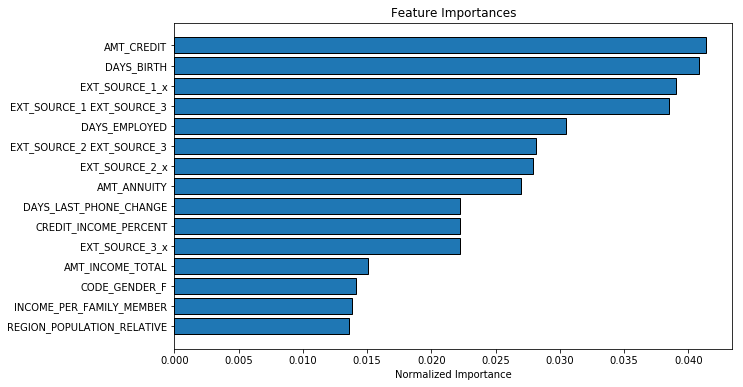

In [19]:
lgbm_params = {
    "boosting":"gbdt",
    "application":"binary",
    "learning_rate": 0.1,
    'reg_alpha':0.1,
    'reg_lambda': 0.1,
    "n_estimators":10000,
    "max_depth":5,
    "num_leaves":200,
    "max_bin":225,
    "drop_rate":0.02
}

fi, metrics = model(app_train, app_test, lgbm_params=lgbm_params)
print('Baseline metrics')
print(metrics)
fi_sorted = plot_feature_importances(fi)

Training Data Shape:  (215257, 448)
Testing Data Shape:  (46127, 448)
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135633	valid's auc: 0.7586	train's l1: 0.132768	train's auc: 0.805001
Early stopping, best iteration is:
[199]	valid's l1: 0.135634	valid's auc: 0.758607	train's l1: 0.132783	train's auc: 0.804923
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.136347	valid's auc: 0.754799	train's l1: 0.132395	train's auc: 0.805111
[400]	valid's l1: 0.135693	valid's auc: 0.753615	train's l1: 0.128439	train's auc: 0.843778
Early stopping, best iteration is:
[224]	valid's l1: 0.136259	valid's auc: 0.755165	train's l1: 0.131917	train's auc: 0.810282
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135206	valid's auc: 0.744283	train's l1: 0.132781	train's auc: 0.806472
[400]	valid's l1: 0.134608	valid's auc: 0.744294	train's l1: 0.128805	train's auc: 0.845441
Early stopping, best iteratio

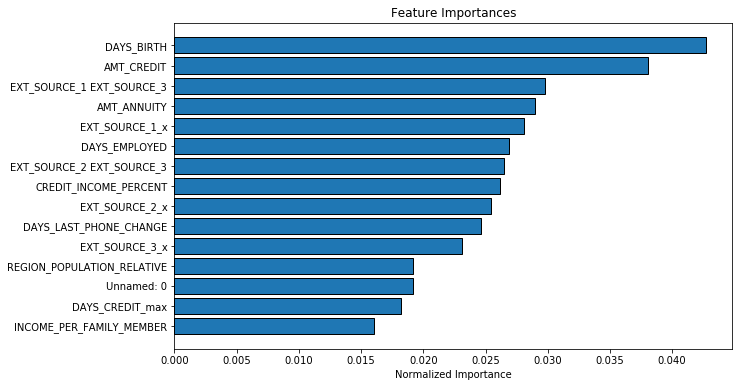

In [20]:
lgbm_params = {
    "boosting":"gbdt",
    "application":"binary",
    "learning_rate": 0.1,
    'reg_alpha':10,
    'reg_lambda': 10,
    "n_estimators":10000,
    "max_depth":5,
    "num_leaves":200,
    "max_bin":225,
    "drop_rate":0.02
}

fi, metrics = model(app_train, app_test, lgbm_params=lgbm_params)
print('Baseline metrics')
print(metrics)
fi_sorted = plot_feature_importances(fi)

In [ ]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV, KFold

k_fold = KFold(n_splits = 5, shuffle = True, random_state = 50)

param_grid = {
    "boosting": ["gbdt", "dart"],
    "application":["binary"],
    'learning_rate': [0.01, 0.1, 1, 10],
    'reg_alpha': [0.01, 0.1, 1],
    'reg_lambda': [0.01, 0.1, 1],
    "n_estimators": [10000],
    "max_depth": [3, 5, 7],
    'num_leaves': [31, 127],
    "max_bin": [225],
    'feature_fraction': [0.5, 1.0],
    'bagging_fraction': [0.75, 0.95], 
    "drop_rate": [0.02]
    }

lgbc_fit_params = {
    "eval_names": ['valid', 'train'],
    "eval_set" : [[test, test_labels]],
    'eval_metric' : ['auc', 'mae'], # string, list of strings, callable or None, optional (default=None)
    'early_stopping_rounds' : 200, # int or None, optional (default=None)
    'verbose': 200
}


lgb_Classifier = lgb.LGBMClassifier(
                         bagging_freq=5,
                         eval_metric=['auc', 'mae'],
                         subsample = 0.8, n_jobs = -1, random_state = 50)

gsearch = GridSearchCV(estimator=lgb_Classifier, 
                       param_grid=param_grid, 
                       fit_params=lgbc_fit_params,
                       cv=k_fold,
                       return_train_score=True,
                       scoring='roc_auc') 


lgb_model = gsearch.fit(X=train, 
                        y=train_labels)

print(lgb_model.best_params_, lgb_model.best_score_)


Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.140842	valid's auc: 0.730857
[400]	valid's l1: 0.138804	valid's auc: 0.739924
[600]	valid's l1: 0.137965	valid's auc: 0.744606
[800]	valid's l1: 0.137196	valid's auc: 0.747274
[1000]	valid's l1: 0.136724	valid's auc: 0.74907
[1200]	valid's l1: 0.136531	valid's auc: 0.749953
[1400]	valid's l1: 0.13628	valid's auc: 0.750559
[1600]	valid's l1: 0.136095	valid's auc: 0.750998
[1800]	valid's l1: 0.136012	valid's auc: 0.751282
Early stopping, best iteration is:
[1691]	valid's l1: 0.135957	valid's auc: 0.751139
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.140574	valid's auc: 0.730909
[400]	valid's l1: 0.138605	valid's auc: 0.73934
[600]	valid's l1: 0.137691	valid's auc: 0.744485
[800]	valid's l1: 0.137102	valid's auc: 0.747226
[1000]	valid's l1: 0.136641	valid's auc: 0.748663
[1200]	valid's l1: 0.136396	valid's auc: 0.749723
[1400]	valid's l1: 0.136182	valid's auc: 0.750303


Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.140837	valid's auc: 0.72997
[400]	valid's l1: 0.138862	valid's auc: 0.73938
[600]	valid's l1: 0.137861	valid's auc: 0.744186
[800]	valid's l1: 0.137291	valid's auc: 0.746803
[1000]	valid's l1: 0.136827	valid's auc: 0.748549
[1200]	valid's l1: 0.136424	valid's auc: 0.749548
[1400]	valid's l1: 0.136346	valid's auc: 0.750332
[1600]	valid's l1: 0.136137	valid's auc: 0.750575
[1800]	valid's l1: 0.135997	valid's auc: 0.75072
[2000]	valid's l1: 0.135881	valid's auc: 0.751048
[2200]	valid's l1: 0.135715	valid's auc: 0.751162
Early stopping, best iteration is:
[2175]	valid's l1: 0.135684	valid's auc: 0.751118
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.140628	valid's auc: 0.729704
[400]	valid's l1: 0.138762	valid's auc: 0.738774
[600]	valid's l1: 0.137712	valid's auc: 0.744099
[800]	valid's l1: 0.137057	valid's auc: 0.746798
[1000]	valid's l1: 0.136645	valid's auc: 0.748592


[400]	valid's l1: 0.138753	valid's auc: 0.738741
[600]	valid's l1: 0.137722	valid's auc: 0.743994
[800]	valid's l1: 0.137073	valid's auc: 0.746735
[1000]	valid's l1: 0.136664	valid's auc: 0.748498
[1200]	valid's l1: 0.136424	valid's auc: 0.74941
[1400]	valid's l1: 0.13618	valid's auc: 0.750038
[1600]	valid's l1: 0.135986	valid's auc: 0.750491
[1800]	valid's l1: 0.135956	valid's auc: 0.750725
Early stopping, best iteration is:
[1680]	valid's l1: 0.135894	valid's auc: 0.75062
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.140376	valid's auc: 0.730284
[400]	valid's l1: 0.138432	valid's auc: 0.738969
[600]	valid's l1: 0.137555	valid's auc: 0.743853
[800]	valid's l1: 0.136979	valid's auc: 0.746637
[1000]	valid's l1: 0.136518	valid's auc: 0.74839
[1200]	valid's l1: 0.136132	valid's auc: 0.749395
[1400]	valid's l1: 0.135917	valid's auc: 0.750273
[1600]	valid's l1: 0.135787	valid's auc: 0.750769
[1800]	valid's l1: 0.135628	valid's auc: 0.75087
[2000]	valid's

[1400]	valid's l1: 0.135887	valid's auc: 0.750357
[1600]	valid's l1: 0.135747	valid's auc: 0.750867
[1800]	valid's l1: 0.135576	valid's auc: 0.751034
[2000]	valid's l1: 0.135351	valid's auc: 0.751192
[2200]	valid's l1: 0.135299	valid's auc: 0.751423
[2400]	valid's l1: 0.135229	valid's auc: 0.751579
[2600]	valid's l1: 0.13518	valid's auc: 0.751608
[2800]	valid's l1: 0.135176	valid's auc: 0.751633
[3000]	valid's l1: 0.135056	valid's auc: 0.751704
Early stopping, best iteration is:
[2981]	valid's l1: 0.135066	valid's auc: 0.751719
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.140854	valid's auc: 0.730725
[400]	valid's l1: 0.138818	valid's auc: 0.739888
[600]	valid's l1: 0.137955	valid's auc: 0.744688
[800]	valid's l1: 0.137169	valid's auc: 0.747301
[1000]	valid's l1: 0.136681	valid's auc: 0.749086
[1200]	valid's l1: 0.136478	valid's auc: 0.750027
[1400]	valid's l1: 0.136221	valid's auc: 0.750708
[1600]	valid's l1: 0.136031	valid's auc: 0.751135
[1800]	

[200]	valid's l1: 0.140842	valid's auc: 0.730857
[400]	valid's l1: 0.138804	valid's auc: 0.739924
[600]	valid's l1: 0.137965	valid's auc: 0.744606
[800]	valid's l1: 0.137196	valid's auc: 0.747274
[1000]	valid's l1: 0.136724	valid's auc: 0.74907
[1200]	valid's l1: 0.136531	valid's auc: 0.749953
[1400]	valid's l1: 0.13628	valid's auc: 0.750559
[1600]	valid's l1: 0.136095	valid's auc: 0.750998
[1800]	valid's l1: 0.136012	valid's auc: 0.751282
Early stopping, best iteration is:
[1691]	valid's l1: 0.135957	valid's auc: 0.751139
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.140574	valid's auc: 0.730909
[400]	valid's l1: 0.138605	valid's auc: 0.73934
[600]	valid's l1: 0.137691	valid's auc: 0.744485
[800]	valid's l1: 0.137102	valid's auc: 0.747226
[1000]	valid's l1: 0.136641	valid's auc: 0.748663
[1200]	valid's l1: 0.136396	valid's auc: 0.749723
[1400]	valid's l1: 0.136182	valid's auc: 0.750303
[1600]	valid's l1: 0.136076	valid's auc: 0.750671
[1800]	valid'

[200]	valid's l1: 0.140837	valid's auc: 0.72997
[400]	valid's l1: 0.138862	valid's auc: 0.73938
[600]	valid's l1: 0.137861	valid's auc: 0.744186
[800]	valid's l1: 0.137291	valid's auc: 0.746803
[1000]	valid's l1: 0.136827	valid's auc: 0.748549
[1200]	valid's l1: 0.136424	valid's auc: 0.749548
[1400]	valid's l1: 0.136346	valid's auc: 0.750332
[1600]	valid's l1: 0.136137	valid's auc: 0.750575
[1800]	valid's l1: 0.135997	valid's auc: 0.75072
[2000]	valid's l1: 0.135881	valid's auc: 0.751048
[2200]	valid's l1: 0.135715	valid's auc: 0.751162
Early stopping, best iteration is:
[2175]	valid's l1: 0.135684	valid's auc: 0.751118
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.140628	valid's auc: 0.729704
[400]	valid's l1: 0.138762	valid's auc: 0.738774
[600]	valid's l1: 0.137712	valid's auc: 0.744099
[800]	valid's l1: 0.137057	valid's auc: 0.746798
[1000]	valid's l1: 0.136645	valid's auc: 0.748592
[1200]	valid's l1: 0.136405	valid's auc: 0.749508
[1400]	valid'

[600]	valid's l1: 0.137722	valid's auc: 0.743994
[800]	valid's l1: 0.137073	valid's auc: 0.746735
[1000]	valid's l1: 0.136664	valid's auc: 0.748498
[1200]	valid's l1: 0.136424	valid's auc: 0.74941
[1400]	valid's l1: 0.13618	valid's auc: 0.750038
[1600]	valid's l1: 0.135986	valid's auc: 0.750491
[1800]	valid's l1: 0.135956	valid's auc: 0.750725
Early stopping, best iteration is:
[1680]	valid's l1: 0.135894	valid's auc: 0.75062
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.140376	valid's auc: 0.730284
[400]	valid's l1: 0.138432	valid's auc: 0.738969
[600]	valid's l1: 0.137555	valid's auc: 0.743853
[800]	valid's l1: 0.136979	valid's auc: 0.746637
[1000]	valid's l1: 0.136518	valid's auc: 0.74839
[1200]	valid's l1: 0.136132	valid's auc: 0.749395
[1400]	valid's l1: 0.135917	valid's auc: 0.750273
[1600]	valid's l1: 0.135787	valid's auc: 0.750769
[1800]	valid's l1: 0.135628	valid's auc: 0.75087
[2000]	valid's l1: 0.135405	valid's auc: 0.751036
[2200]	valid'

[1400]	valid's l1: 0.135887	valid's auc: 0.750357
[1600]	valid's l1: 0.135747	valid's auc: 0.750867
[1800]	valid's l1: 0.135576	valid's auc: 0.751034
[2000]	valid's l1: 0.135351	valid's auc: 0.751192
[2200]	valid's l1: 0.135299	valid's auc: 0.751423
[2400]	valid's l1: 0.135229	valid's auc: 0.751579
[2600]	valid's l1: 0.13518	valid's auc: 0.751608
[2800]	valid's l1: 0.135176	valid's auc: 0.751633
[3000]	valid's l1: 0.135056	valid's auc: 0.751704
Early stopping, best iteration is:
[2981]	valid's l1: 0.135066	valid's auc: 0.751719
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.140854	valid's auc: 0.730725
[400]	valid's l1: 0.138818	valid's auc: 0.739888
[600]	valid's l1: 0.137955	valid's auc: 0.744688
[800]	valid's l1: 0.137169	valid's auc: 0.747301
[1000]	valid's l1: 0.136681	valid's auc: 0.749086
[1200]	valid's l1: 0.136478	valid's auc: 0.750027
[1400]	valid's l1: 0.136221	valid's auc: 0.750708
[1600]	valid's l1: 0.136031	valid's auc: 0.751135
[1800]	

[200]	valid's l1: 0.139822	valid's auc: 0.740086
[400]	valid's l1: 0.137581	valid's auc: 0.746404
[600]	valid's l1: 0.136733	valid's auc: 0.749633
[800]	valid's l1: 0.136107	valid's auc: 0.750783
[1000]	valid's l1: 0.13577	valid's auc: 0.751367
[1200]	valid's l1: 0.13566	valid's auc: 0.751552
[1400]	valid's l1: 0.135462	valid's auc: 0.751856
[1600]	valid's l1: 0.135311	valid's auc: 0.752026
[1800]	valid's l1: 0.135243	valid's auc: 0.752061
[2000]	valid's l1: 0.135075	valid's auc: 0.751912
Early stopping, best iteration is:
[1852]	valid's l1: 0.135197	valid's auc: 0.752173
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.139571	valid's auc: 0.740017
[400]	valid's l1: 0.13739	valid's auc: 0.746068
[600]	valid's l1: 0.13647	valid's auc: 0.749277
[800]	valid's l1: 0.135966	valid's auc: 0.750646
[1000]	valid's l1: 0.135625	valid's auc: 0.751236
[1200]	valid's l1: 0.135474	valid's auc: 0.751548
[1400]	valid's l1: 0.135305	valid's auc: 0.75173
[1600]	valid's 

[1800]	valid's l1: 0.134736	valid's auc: 0.752663
[2000]	valid's l1: 0.134527	valid's auc: 0.752639
Early stopping, best iteration is:
[1878]	valid's l1: 0.134597	valid's auc: 0.752792
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.139826	valid's auc: 0.74005
[400]	valid's l1: 0.137579	valid's auc: 0.746445
[600]	valid's l1: 0.136726	valid's auc: 0.74983
[800]	valid's l1: 0.136091	valid's auc: 0.75099
[1000]	valid's l1: 0.135749	valid's auc: 0.751543
[1200]	valid's l1: 0.135645	valid's auc: 0.751724
[1400]	valid's l1: 0.135455	valid's auc: 0.751904
Early stopping, best iteration is:
[1309]	valid's l1: 0.135525	valid's auc: 0.752038
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.13957	valid's auc: 0.740033
[400]	valid's l1: 0.137378	valid's auc: 0.74612
[600]	valid's l1: 0.136457	valid's auc: 0.749363
[800]	valid's l1: 0.135951	valid's auc: 0.75071
[1000]	valid's l1: 0.135608	valid's auc: 0.751299
[1200]	valid's l1:

[1200]	valid's l1: 0.135171	valid's auc: 0.751763
[1400]	valid's l1: 0.135016	valid's auc: 0.752239
[1600]	valid's l1: 0.134928	valid's auc: 0.752354
Early stopping, best iteration is:
[1525]	valid's l1: 0.134967	valid's auc: 0.752411
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.139834	valid's auc: 0.740012
[400]	valid's l1: 0.137552	valid's auc: 0.746322
[600]	valid's l1: 0.136682	valid's auc: 0.749789
[800]	valid's l1: 0.136028	valid's auc: 0.751068
[1000]	valid's l1: 0.135666	valid's auc: 0.751865
[1200]	valid's l1: 0.135558	valid's auc: 0.751917
[1400]	valid's l1: 0.135358	valid's auc: 0.752192
[1600]	valid's l1: 0.135222	valid's auc: 0.75221
Early stopping, best iteration is:
[1571]	valid's l1: 0.135258	valid's auc: 0.75229
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.139571	valid's auc: 0.740027
[400]	valid's l1: 0.137358	valid's auc: 0.746291
[600]	valid's l1: 0.136434	valid's auc: 0.749576
[800]	valid's

[800]	valid's l1: 0.135771	valid's auc: 0.751098
[1000]	valid's l1: 0.135426	valid's auc: 0.751717
[1200]	valid's l1: 0.135118	valid's auc: 0.752066
[1400]	valid's l1: 0.134948	valid's auc: 0.75254
[1600]	valid's l1: 0.134862	valid's auc: 0.752665
[1800]	valid's l1: 0.134705	valid's auc: 0.752735
[2000]	valid's l1: 0.134482	valid's auc: 0.752729
Early stopping, best iteration is:
[1878]	valid's l1: 0.134571	valid's auc: 0.752835
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.139823	valid's auc: 0.740053
[400]	valid's l1: 0.137588	valid's auc: 0.746381
[600]	valid's l1: 0.136731	valid's auc: 0.749801
[800]	valid's l1: 0.136096	valid's auc: 0.750974
[1000]	valid's l1: 0.135753	valid's auc: 0.751497
[1200]	valid's l1: 0.135646	valid's auc: 0.751688
[1400]	valid's l1: 0.135462	valid's auc: 0.751831
[1600]	valid's l1: 0.13531	valid's auc: 0.752057
[1800]	valid's l1: 0.135245	valid's auc: 0.752026
Early stopping, best iteration is:
[1690]	valid's l1: 0.135

Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.139335	valid's auc: 0.739752
[400]	valid's l1: 0.137172	valid's auc: 0.745862
[600]	valid's l1: 0.1363	valid's auc: 0.749317
[800]	valid's l1: 0.135808	valid's auc: 0.750788
[1000]	valid's l1: 0.135473	valid's auc: 0.751393
[1200]	valid's l1: 0.135176	valid's auc: 0.751815
[1400]	valid's l1: 0.135016	valid's auc: 0.752327
[1600]	valid's l1: 0.13493	valid's auc: 0.752398
[1800]	valid's l1: 0.134767	valid's auc: 0.752401
[2000]	valid's l1: 0.134557	valid's auc: 0.752345
Early stopping, best iteration is:
[1878]	valid's l1: 0.134627	valid's auc: 0.752539
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.139822	valid's auc: 0.740007
[400]	valid's l1: 0.137586	valid's auc: 0.746415
[600]	valid's l1: 0.136734	valid's auc: 0.749689
[800]	valid's l1: 0.136089	valid's auc: 0.751005
[1000]	valid's l1: 0.135752	valid's auc: 0.751572
[1200]	valid's l1: 0.13564	valid's auc: 0.751743
[

[1000]	valid's l1: 0.135603	valid's auc: 0.752557
[1200]	valid's l1: 0.13548	valid's auc: 0.752698
[1400]	valid's l1: 0.135297	valid's auc: 0.753002
[1600]	valid's l1: 0.135143	valid's auc: 0.752981
Early stopping, best iteration is:
[1516]	valid's l1: 0.135214	valid's auc: 0.753083
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.139338	valid's auc: 0.739771
[400]	valid's l1: 0.137166	valid's auc: 0.745858
[600]	valid's l1: 0.136275	valid's auc: 0.74923
[800]	valid's l1: 0.13578	valid's auc: 0.750767
[1000]	valid's l1: 0.135443	valid's auc: 0.7514
[1200]	valid's l1: 0.135145	valid's auc: 0.751852
[1400]	valid's l1: 0.13499	valid's auc: 0.752366
[1600]	valid's l1: 0.13491	valid's auc: 0.752454
[1800]	valid's l1: 0.13475	valid's auc: 0.752504
[2000]	valid's l1: 0.134541	valid's auc: 0.75238
Early stopping, best iteration is:
[1878]	valid's l1: 0.134614	valid's auc: 0.752611
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1:

[1000]	valid's l1: 0.13556	valid's auc: 0.752447
[1200]	valid's l1: 0.135423	valid's auc: 0.752676
[1400]	valid's l1: 0.135253	valid's auc: 0.752815
[1600]	valid's l1: 0.135108	valid's auc: 0.752852
Early stopping, best iteration is:
[1552]	valid's l1: 0.135186	valid's auc: 0.75297
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.139359	valid's auc: 0.739834
[400]	valid's l1: 0.137177	valid's auc: 0.74606
[600]	valid's l1: 0.136266	valid's auc: 0.749664
[800]	valid's l1: 0.135755	valid's auc: 0.751058
[1000]	valid's l1: 0.135407	valid's auc: 0.751706
[1200]	valid's l1: 0.135106	valid's auc: 0.752006
[1400]	valid's l1: 0.134931	valid's auc: 0.752527
[1600]	valid's l1: 0.134856	valid's auc: 0.752526
[1800]	valid's l1: 0.134702	valid's auc: 0.752654
[2000]	valid's l1: 0.134478	valid's auc: 0.752672
Early stopping, best iteration is:
[1897]	valid's l1: 0.134578	valid's auc: 0.752757
Training until validation scores don't improve for 200 rounds.
[200]	valid

[1000]	valid's l1: 0.135144	valid's auc: 0.751557
[1200]	valid's l1: 0.13487	valid's auc: 0.751688
[1400]	valid's l1: 0.13471	valid's auc: 0.752109
Early stopping, best iteration is:
[1385]	valid's l1: 0.134704	valid's auc: 0.752118
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.139443	valid's auc: 0.741697
[400]	valid's l1: 0.137158	valid's auc: 0.747473
[600]	valid's l1: 0.136337	valid's auc: 0.750378
[800]	valid's l1: 0.135755	valid's auc: 0.751368
[1000]	valid's l1: 0.135447	valid's auc: 0.751876
[1200]	valid's l1: 0.135348	valid's auc: 0.751942
[1400]	valid's l1: 0.135148	valid's auc: 0.752165
[1600]	valid's l1: 0.13497	valid's auc: 0.752277
Early stopping, best iteration is:
[1569]	valid's l1: 0.135012	valid's auc: 0.752402
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.139182	valid's auc: 0.741899
[400]	valid's l1: 0.136946	valid's auc: 0.747156
[600]	valid's l1: 0.136056	valid's auc: 0.75003
[800]	valid's l

Early stopping, best iteration is:
[1312]	valid's l1: 0.135181	valid's auc: 0.751953
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.139169	valid's auc: 0.742104
[400]	valid's l1: 0.136892	valid's auc: 0.747554
[600]	valid's l1: 0.135999	valid's auc: 0.750454
[800]	valid's l1: 0.13555	valid's auc: 0.751627
[1000]	valid's l1: 0.135239	valid's auc: 0.751939
[1200]	valid's l1: 0.135091	valid's auc: 0.752306
Early stopping, best iteration is:
[1175]	valid's l1: 0.135097	valid's auc: 0.75237
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.139387	valid's auc: 0.740981
[400]	valid's l1: 0.13715	valid's auc: 0.747101
[600]	valid's l1: 0.136191	valid's auc: 0.74976
[800]	valid's l1: 0.135705	valid's auc: 0.751213
[1000]	valid's l1: 0.135393	valid's auc: 0.75175
[1200]	valid's l1: 0.13511	valid's auc: 0.751918
[1400]	valid's l1: 0.135086	valid's auc: 0.752242
Early stopping, best iteration is:
[1375]	valid's l1: 0.135112	valid

[800]	valid's l1: 0.135218	valid's auc: 0.750315
[1000]	valid's l1: 0.134796	valid's auc: 0.750531
[1200]	valid's l1: 0.134385	valid's auc: 0.750525
Early stopping, best iteration is:
[1054]	valid's l1: 0.134707	valid's auc: 0.750651
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.138981	valid's auc: 0.7438
[400]	valid's l1: 0.136744	valid's auc: 0.747876
[600]	valid's l1: 0.135657	valid's auc: 0.750413
[800]	valid's l1: 0.135101	valid's auc: 0.751341
[1000]	valid's l1: 0.134736	valid's auc: 0.751757
[1200]	valid's l1: 0.134464	valid's auc: 0.751943
[1400]	valid's l1: 0.134142	valid's auc: 0.752184
[1600]	valid's l1: 0.133811	valid's auc: 0.751998
Early stopping, best iteration is:
[1487]	valid's l1: 0.134015	valid's auc: 0.752292
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.138769	valid's auc: 0.742772
[400]	valid's l1: 0.136427	valid's auc: 0.747299
[600]	valid's l1: 0.135501	valid's auc: 0.749817
[800]	valid's 

[400]	valid's l1: 0.136722	valid's auc: 0.748556
[600]	valid's l1: 0.135874	valid's auc: 0.750338
[800]	valid's l1: 0.135222	valid's auc: 0.750981
[1000]	valid's l1: 0.134843	valid's auc: 0.751283
[1200]	valid's l1: 0.134624	valid's auc: 0.751085
Early stopping, best iteration is:
[1046]	valid's l1: 0.134747	valid's auc: 0.751384
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.138901	valid's auc: 0.743474
[400]	valid's l1: 0.136525	valid's auc: 0.747712
[600]	valid's l1: 0.135586	valid's auc: 0.75018
[800]	valid's l1: 0.13504	valid's auc: 0.751098
[1000]	valid's l1: 0.134635	valid's auc: 0.751393
[1200]	valid's l1: 0.134366	valid's auc: 0.751573
[1400]	valid's l1: 0.134018	valid's auc: 0.75174
Early stopping, best iteration is:
[1380]	valid's l1: 0.134024	valid's auc: 0.751769
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.139096	valid's auc: 0.742992
[400]	valid's l1: 0.136781	valid's auc: 0.746985
[600]	valid's l1

[1200]	valid's l1: 0.134212	valid's auc: 0.751623
[1400]	valid's l1: 0.134015	valid's auc: 0.751757
Early stopping, best iteration is:
[1357]	valid's l1: 0.134054	valid's auc: 0.751924
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.138909	valid's auc: 0.743851
[400]	valid's l1: 0.136646	valid's auc: 0.748149
[600]	valid's l1: 0.135538	valid's auc: 0.750647
[800]	valid's l1: 0.135008	valid's auc: 0.75136
[1000]	valid's l1: 0.134617	valid's auc: 0.752179
[1200]	valid's l1: 0.134335	valid's auc: 0.752452
[1400]	valid's l1: 0.133982	valid's auc: 0.752559
Early stopping, best iteration is:
[1360]	valid's l1: 0.134047	valid's auc: 0.752593
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.138681	valid's auc: 0.74354
[400]	valid's l1: 0.136317	valid's auc: 0.7482
[600]	valid's l1: 0.135377	valid's auc: 0.750592
[800]	valid's l1: 0.134867	valid's auc: 0.751069
[1000]	valid's l1: 0.134461	valid's auc: 0.75132
[1200]	valid's l1

Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.136051	valid's auc: 0.750001
[400]	valid's l1: 0.135491	valid's auc: 0.750273
Early stopping, best iteration is:
[286]	valid's l1: 0.135526	valid's auc: 0.750775
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135681	valid's auc: 0.750218
[400]	valid's l1: 0.135381	valid's auc: 0.750287
Early stopping, best iteration is:
[229]	valid's l1: 0.135334	valid's auc: 0.750784
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135947	valid's auc: 0.749238
[400]	valid's l1: 0.135388	valid's auc: 0.749655
Early stopping, best iteration is:
[306]	valid's l1: 0.13559	valid's auc: 0.750011
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135749	valid's auc: 0.75032
[400]	valid's l1: 0.135396	valid's auc: 0.748761
Early stopping, best iteration is:
[233]	valid's l1: 0.135572	valid's auc: 0.750769
Training until validat

Early stopping, best iteration is:
[186]	valid's l1: 0.135504	valid's auc: 0.750372
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.13586	valid's auc: 0.750711
[400]	valid's l1: 0.135475	valid's auc: 0.749978
Early stopping, best iteration is:
[247]	valid's l1: 0.135665	valid's auc: 0.750945
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135769	valid's auc: 0.750696
[400]	valid's l1: 0.135405	valid's auc: 0.750978
Early stopping, best iteration is:
[294]	valid's l1: 0.135279	valid's auc: 0.751542
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135914	valid's auc: 0.749438
[400]	valid's l1: 0.135359	valid's auc: 0.749896
Early stopping, best iteration is:
[356]	valid's l1: 0.135274	valid's auc: 0.750672
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135699	valid's auc: 0.750116
[400]	valid's l1: 0.135343	valid's auc: 0.748309
Early stopping, best 

Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135295	valid's auc: 0.750727
Early stopping, best iteration is:
[185]	valid's l1: 0.135432	valid's auc: 0.751087
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135217	valid's auc: 0.746593
Early stopping, best iteration is:
[101]	valid's l1: 0.135848	valid's auc: 0.748235
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135042	valid's auc: 0.748787
[400]	valid's l1: 0.134104	valid's auc: 0.747346
Early stopping, best iteration is:
[230]	valid's l1: 0.134629	valid's auc: 0.749276
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135239	valid's auc: 0.747201
Early stopping, best iteration is:
[127]	valid's l1: 0.135541	valid's auc: 0.747857
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.134983	valid's auc: 0.749544
Early stopping, best iteration is:
[175]	valid's l1: 0.

[200]	valid's l1: 0.13516	valid's auc: 0.747376
Early stopping, best iteration is:
[78]	valid's l1: 0.136225	valid's auc: 0.748946
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.134968	valid's auc: 0.748634
Early stopping, best iteration is:
[111]	valid's l1: 0.13546	valid's auc: 0.749535
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135071	valid's auc: 0.749431
[400]	valid's l1: 0.134309	valid's auc: 0.746525
Early stopping, best iteration is:
[228]	valid's l1: 0.134761	valid's auc: 0.749684
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.134827	valid's auc: 0.749124
Early stopping, best iteration is:
[130]	valid's l1: 0.135481	valid's auc: 0.750061
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.134573	valid's auc: 0.748898
Early stopping, best iteration is:
[101]	valid's l1: 0.135068	valid's auc: 0.751015
Training until validation scores don'

Early stopping, best iteration is:
[146]	valid's l1: 0.135241	valid's auc: 0.74967
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135064	valid's auc: 0.748392
[400]	valid's l1: 0.134011	valid's auc: 0.746546
Early stopping, best iteration is:
[236]	valid's l1: 0.134684	valid's auc: 0.74879
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.134932	valid's auc: 0.749322
Early stopping, best iteration is:
[126]	valid's l1: 0.135371	valid's auc: 0.750525
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.134501	valid's auc: 0.748787
Early stopping, best iteration is:
[111]	valid's l1: 0.135115	valid's auc: 0.750049
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135293	valid's auc: 0.747912
Early stopping, best iteration is:
[89]	valid's l1: 0.13592	valid's auc: 0.749943
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.1349

[200]	valid's l1: 0.134791	valid's auc: 0.746567
Early stopping, best iteration is:
[130]	valid's l1: 0.135409	valid's auc: 0.74947
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.134209	valid's auc: 0.746924
Early stopping, best iteration is:
[113]	valid's l1: 0.134879	valid's auc: 0.749303
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.134702	valid's auc: 0.746233
Early stopping, best iteration is:
[79]	valid's l1: 0.135976	valid's auc: 0.74909
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.134676	valid's auc: 0.747259
Early stopping, best iteration is:
[138]	valid's l1: 0.134965	valid's auc: 0.748203
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.134807	valid's auc: 0.745151
Early stopping, best iteration is:
[127]	valid's l1: 0.135076	valid's auc: 0.748062
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.134

Early stopping, best iteration is:
[79]	valid's l1: 0.135356	valid's auc: 0.745127
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.133138	valid's auc: 0.740918
Early stopping, best iteration is:
[77]	valid's l1: 0.135188	valid's auc: 0.743944
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.133162	valid's auc: 0.742292
Early stopping, best iteration is:
[83]	valid's l1: 0.135066	valid's auc: 0.746141
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.133236	valid's auc: 0.742704
Early stopping, best iteration is:
[78]	valid's l1: 0.135373	valid's auc: 0.746734
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.132732	valid's auc: 0.743429
Early stopping, best iteration is:
[86]	valid's l1: 0.134683	valid's auc: 0.7465
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.133545	valid's auc: 0.740693
Early stopping, best iterat

Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.134872	valid's auc: 0.702052
Early stopping, best iteration is:
[18]	valid's l1: 0.135342	valid's auc: 0.733252
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.134443	valid's auc: 0.698436
Early stopping, best iteration is:
[13]	valid's l1: 0.135624	valid's auc: 0.738979
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135053	valid's auc: 0.702283
Early stopping, best iteration is:
[16]	valid's l1: 0.135892	valid's auc: 0.73641
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.13549	valid's auc: 0.702904
Early stopping, best iteration is:
[11]	valid's l1: 0.136045	valid's auc: 0.73662
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135039	valid's auc: 0.700673
Early stopping, best iteration is:
[12]	valid's l1: 0.136568	valid's auc: 0.732884
Training until validation sc

[200]	valid's l1: 0.134315	valid's auc: 0.699779
Early stopping, best iteration is:
[15]	valid's l1: 0.135912	valid's auc: 0.733676
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.134936	valid's auc: 0.701868
Early stopping, best iteration is:
[22]	valid's l1: 0.134724	valid's auc: 0.738559
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135117	valid's auc: 0.696246
Early stopping, best iteration is:
[12]	valid's l1: 0.136691	valid's auc: 0.733389
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.134872	valid's auc: 0.702052
Early stopping, best iteration is:
[18]	valid's l1: 0.135342	valid's auc: 0.733252
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.134443	valid's auc: 0.698436
Early stopping, best iteration is:
[13]	valid's l1: 0.135624	valid's auc: 0.738979
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.13505

Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.138779	valid's auc: 0.67823
Early stopping, best iteration is:
[6]	valid's l1: 0.136681	valid's auc: 0.726124
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.138089	valid's auc: 0.678581
Early stopping, best iteration is:
[7]	valid's l1: 0.136739	valid's auc: 0.72414
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.136129	valid's auc: 0.656089
Early stopping, best iteration is:
[6]	valid's l1: 0.136703	valid's auc: 0.727114
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135014	valid's auc: 0.662322
Early stopping, best iteration is:
[7]	valid's l1: 0.136862	valid's auc: 0.728077
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135315	valid's auc: 0.663954
Early stopping, best iteration is:
[8]	valid's l1: 0.135792	valid's auc: 0.728057
Training until validation scores

[200]	valid's l1: 0.139074	valid's auc: 0.669292
Early stopping, best iteration is:
[6]	valid's l1: 0.136767	valid's auc: 0.725482
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.140197	valid's auc: 0.681502
Early stopping, best iteration is:
[11]	valid's l1: 0.135573	valid's auc: 0.726195
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.138357	valid's auc: 0.688312
Early stopping, best iteration is:
[11]	valid's l1: 0.135863	valid's auc: 0.72412
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.139332	valid's auc: 0.685408
Early stopping, best iteration is:
[6]	valid's l1: 0.136871	valid's auc: 0.726022
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.136194	valid's auc: 0.683689
Early stopping, best iteration is:
[7]	valid's l1: 0.136701	valid's auc: 0.724365
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135427	va

Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.141816	valid's auc: 0.691111
Early stopping, best iteration is:
[4]	valid's l1: 0.136395	valid's auc: 0.72034
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.136811	valid's auc: 0.676048
Early stopping, best iteration is:
[3]	valid's l1: 0.138517	valid's auc: 0.710781
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.13792	valid's auc: 0.696046
Early stopping, best iteration is:
[6]	valid's l1: 0.137335	valid's auc: 0.721404
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.140787	valid's auc: 0.686517
Early stopping, best iteration is:
[2]	valid's l1: 0.136267	valid's auc: 0.718801
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.137717	valid's auc: 0.693037
Early stopping, best iteration is:
[5]	valid's l1: 0.13631	valid's auc: 0.718889
Training until validation scores 

Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.0974483	valid's auc: 0.664886
Early stopping, best iteration is:
[2]	valid's l1: 0.137751	valid's auc: 0.70919
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.13926	valid's auc: 0.67001
Early stopping, best iteration is:
[1]	valid's l1: 0.156443	valid's auc: 0.712352
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.140522	valid's auc: 0.683649
Early stopping, best iteration is:
[1]	valid's l1: 0.154683	valid's auc: 0.712097
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.136422	valid's auc: 0.672382
Early stopping, best iteration is:
[1]	valid's l1: 0.156402	valid's auc: 0.711227
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.141762	valid's auc: 0.672582
Early stopping, best iteration is:
[1]	valid's l1: 0.15547	valid's auc: 0.70909
Training until validation scores d

[200]	valid's l1: 0.474841	valid's auc: 0.33187
Early stopping, best iteration is:
[1]	valid's l1: 0.21448	valid's auc: 0.693102
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.079433	valid's auc: 0.446382
Early stopping, best iteration is:
[1]	valid's l1: 0.282518	valid's auc: 0.698459
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.614477	valid's auc: 0.348943
Early stopping, best iteration is:
[1]	valid's l1: 0.273118	valid's auc: 0.696768
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.0794329	valid's auc: 0.647915
Early stopping, best iteration is:
[1]	valid's l1: 0.287052	valid's auc: 0.698066
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.0794329	valid's auc: 0.566308
Early stopping, best iteration is:
[1]	valid's l1: 0.262518	valid's auc: 0.702255
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.474841	val

Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.0794329	valid's auc: 0.649017
Early stopping, best iteration is:
[1]	valid's l1: 0.286997	valid's auc: 0.698066
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.0794329	valid's auc: 0.560887
Early stopping, best iteration is:
[1]	valid's l1: 0.262492	valid's auc: 0.701902
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.474841	valid's auc: 0.33187
Early stopping, best iteration is:
[1]	valid's l1: 0.21448	valid's auc: 0.693102
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.079433	valid's auc: 0.446382
Early stopping, best iteration is:
[1]	valid's l1: 0.282518	valid's auc: 0.698459
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.614477	valid's auc: 0.348943
Early stopping, best iteration is:
[1]	valid's l1: 0.273118	valid's auc: 0.696768
Training until validation scor

[200]	valid's l1: 0.0967358	valid's auc: 0.491353
Early stopping, best iteration is:
[1]	valid's l1: 0.251375	valid's auc: 0.708941
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.256683	valid's auc: 0.527849
Early stopping, best iteration is:
[1]	valid's l1: 0.285114	valid's auc: 0.709985
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.0827064	valid's auc: 0.390492
Early stopping, best iteration is:
[1]	valid's l1: 0.275232	valid's auc: 0.71094
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.238776	valid's auc: 0.656019
Early stopping, best iteration is:
[1]	valid's l1: 0.268542	valid's auc: 0.7134
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.13955	valid's auc: 0.547944
Early stopping, best iteration is:
[1]	valid's l1: 0.259146	valid's auc: 0.714168
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.485074	valid

Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.101047	valid's auc: 0.586212
Early stopping, best iteration is:
[1]	valid's l1: 0.268681	valid's auc: 0.711691
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.0794762	valid's auc: 0.612788
Early stopping, best iteration is:
[1]	valid's l1: 0.259412	valid's auc: 0.714677
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.0967358	valid's auc: 0.491353
Early stopping, best iteration is:
[1]	valid's l1: 0.251375	valid's auc: 0.708941
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.256683	valid's auc: 0.527872
Early stopping, best iteration is:
[1]	valid's l1: 0.285236	valid's auc: 0.709776
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.0827064	valid's auc: 0.390423
Early stopping, best iteration is:
[1]	valid's l1: 0.275196	valid's auc: 0.710917
Training until validation s

[200]	valid's l1: 0.0794329	valid's auc: 0.570985
Early stopping, best iteration is:
[1]	valid's l1: 0.252076	valid's auc: 0.708977
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.146227	valid's auc: 0.491582
Early stopping, best iteration is:
[1]	valid's l1: 0.26944	valid's auc: 0.710178
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.213432	valid's auc: 0.502026
Early stopping, best iteration is:
[1]	valid's l1: 0.256614	valid's auc: 0.712783
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.150237	valid's auc: 0.621929
Early stopping, best iteration is:
[1]	valid's l1: 0.271017	valid's auc: 0.714343
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.148698	valid's auc: 0.400658
Early stopping, best iteration is:
[1]	valid's l1: 0.255273	valid's auc: 0.716132
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.0813406	va

Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.0962343	valid's auc: 0.455514
Early stopping, best iteration is:
[1]	valid's l1: 0.269356	valid's auc: 0.707763
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.172285	valid's auc: 0.589945
Early stopping, best iteration is:
[1]	valid's l1: 0.253872	valid's auc: 0.711878
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.764108	valid's auc: 0.46809
Early stopping, best iteration is:
[1]	valid's l1: 0.255184	valid's auc: 0.711706
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.164654	valid's auc: 0.568427
Early stopping, best iteration is:
[1]	valid's l1: 0.272909	valid's auc: 0.711138
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.112537	valid's auc: 0.374317
Early stopping, best iteration is:
[1]	valid's l1: 0.259538	valid's auc: 0.708598
Training until validation scor

[200]	valid's l1: 0.124157	valid's auc: 0.533248
Early stopping, best iteration is:
[1]	valid's l1: 0.253244	valid's auc: 0.712735
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.152449	valid's auc: 0.676135
Early stopping, best iteration is:
[1]	valid's l1: 0.252785	valid's auc: 0.712201
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.140582	valid's auc: 0.728078
[400]	valid's l1: 0.138745	valid's auc: 0.739695
[600]	valid's l1: 0.137876	valid's auc: 0.744778
[800]	valid's l1: 0.137107	valid's auc: 0.74749
[1000]	valid's l1: 0.136611	valid's auc: 0.749359
[1200]	valid's l1: 0.136404	valid's auc: 0.750232
[1400]	valid's l1: 0.136143	valid's auc: 0.750873
[1600]	valid's l1: 0.135982	valid's auc: 0.751306
[1800]	valid's l1: 0.135901	valid's auc: 0.751525
[2000]	valid's l1: 0.135737	valid's auc: 0.75168
Early stopping, best iteration is:
[1945]	valid's l1: 0.135773	valid's auc: 0.751753
Training until validation scores 

[1000]	valid's l1: 0.136467	valid's auc: 0.74918
[1200]	valid's l1: 0.136191	valid's auc: 0.750421
[1400]	valid's l1: 0.135969	valid's auc: 0.75097
[1600]	valid's l1: 0.135879	valid's auc: 0.751333
[1800]	valid's l1: 0.135681	valid's auc: 0.751791
[2000]	valid's l1: 0.135444	valid's auc: 0.751922
[2200]	valid's l1: 0.13548	valid's auc: 0.752041
Early stopping, best iteration is:
[2075]	valid's l1: 0.135434	valid's auc: 0.751943
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.140657	valid's auc: 0.728035
[400]	valid's l1: 0.138833	valid's auc: 0.739403
[600]	valid's l1: 0.137828	valid's auc: 0.744451
[800]	valid's l1: 0.137247	valid's auc: 0.747081
[1000]	valid's l1: 0.13675	valid's auc: 0.749025
[1200]	valid's l1: 0.136337	valid's auc: 0.750096
[1400]	valid's l1: 0.13626	valid's auc: 0.750902
[1600]	valid's l1: 0.136026	valid's auc: 0.751418
[1800]	valid's l1: 0.135872	valid's auc: 0.751572
[2000]	valid's l1: 0.135746	valid's auc: 0.751774
[2200]	vali

[400]	valid's l1: 0.138707	valid's auc: 0.738957
[600]	valid's l1: 0.137702	valid's auc: 0.744218
[800]	valid's l1: 0.137018	valid's auc: 0.747003
[1000]	valid's l1: 0.136635	valid's auc: 0.748565
[1200]	valid's l1: 0.136363	valid's auc: 0.7494
[1400]	valid's l1: 0.136132	valid's auc: 0.75018
[1600]	valid's l1: 0.135943	valid's auc: 0.750443
[1800]	valid's l1: 0.135912	valid's auc: 0.750681
[2000]	valid's l1: 0.135788	valid's auc: 0.750744
[2200]	valid's l1: 0.135701	valid's auc: 0.75074
[2400]	valid's l1: 0.135633	valid's auc: 0.750957
[2600]	valid's l1: 0.135567	valid's auc: 0.751069
[2800]	valid's l1: 0.135511	valid's auc: 0.751377
[3000]	valid's l1: 0.135474	valid's auc: 0.751546
[3200]	valid's l1: 0.135379	valid's auc: 0.751684
[3400]	valid's l1: 0.135318	valid's auc: 0.75168
[3600]	valid's l1: 0.135294	valid's auc: 0.751557
Early stopping, best iteration is:
[3417]	valid's l1: 0.135327	valid's auc: 0.751729
Training until validation scores don't improve for 200 rounds.
[200]	vali

[3200]	valid's l1: 0.135327	valid's auc: 0.752029
Early stopping, best iteration is:
[3139]	valid's l1: 0.135361	valid's auc: 0.75206
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.140154	valid's auc: 0.727857
[400]	valid's l1: 0.138387	valid's auc: 0.739364
[600]	valid's l1: 0.137453	valid's auc: 0.744394
[800]	valid's l1: 0.136855	valid's auc: 0.74739
[1000]	valid's l1: 0.136339	valid's auc: 0.749208
[1200]	valid's l1: 0.135967	valid's auc: 0.750084
[1400]	valid's l1: 0.13573	valid's auc: 0.751162
[1600]	valid's l1: 0.135612	valid's auc: 0.751812
[1800]	valid's l1: 0.135462	valid's auc: 0.751737
Early stopping, best iteration is:
[1645]	valid's l1: 0.135577	valid's auc: 0.75182
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.140603	valid's auc: 0.727998
[400]	valid's l1: 0.13875	valid's auc: 0.739809
[600]	valid's l1: 0.137876	valid's auc: 0.7449
[800]	valid's l1: 0.137095	valid's auc: 0.747697
[1000]	valid's l1: 

[400]	valid's l1: 0.138745	valid's auc: 0.739695
[600]	valid's l1: 0.137876	valid's auc: 0.744778
[800]	valid's l1: 0.137107	valid's auc: 0.74749
[1000]	valid's l1: 0.136611	valid's auc: 0.749359
[1200]	valid's l1: 0.136404	valid's auc: 0.750232
[1400]	valid's l1: 0.136143	valid's auc: 0.750873
[1600]	valid's l1: 0.135982	valid's auc: 0.751306
[1800]	valid's l1: 0.135901	valid's auc: 0.751525
[2000]	valid's l1: 0.135737	valid's auc: 0.75168
Early stopping, best iteration is:
[1945]	valid's l1: 0.135773	valid's auc: 0.751753
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.140276	valid's auc: 0.72801
[400]	valid's l1: 0.138525	valid's auc: 0.739235
[600]	valid's l1: 0.137634	valid's auc: 0.744675
[800]	valid's l1: 0.136992	valid's auc: 0.747363
[1000]	valid's l1: 0.136519	valid's auc: 0.749082
[1200]	valid's l1: 0.136254	valid's auc: 0.750222
[1400]	valid's l1: 0.136041	valid's auc: 0.750727
[1600]	valid's l1: 0.135964	valid's auc: 0.751022
[1800]	valid

Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.140657	valid's auc: 0.728035
[400]	valid's l1: 0.138833	valid's auc: 0.739403
[600]	valid's l1: 0.137828	valid's auc: 0.744451
[800]	valid's l1: 0.137247	valid's auc: 0.747081
[1000]	valid's l1: 0.13675	valid's auc: 0.749025
[1200]	valid's l1: 0.136337	valid's auc: 0.750096
[1400]	valid's l1: 0.13626	valid's auc: 0.750902
[1600]	valid's l1: 0.136026	valid's auc: 0.751418
[1800]	valid's l1: 0.135872	valid's auc: 0.751572
[2000]	valid's l1: 0.135746	valid's auc: 0.751774
[2200]	valid's l1: 0.135594	valid's auc: 0.751893
Early stopping, best iteration is:
[2175]	valid's l1: 0.135556	valid's auc: 0.751889
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.140411	valid's auc: 0.727318
[400]	valid's l1: 0.138712	valid's auc: 0.738949
[600]	valid's l1: 0.137692	valid's auc: 0.744252
[800]	valid's l1: 0.136998	valid's auc: 0.747109
[1000]	valid's l1: 0.136605	valid's auc: 0.748738

[2200]	valid's l1: 0.135701	valid's auc: 0.75074
[2400]	valid's l1: 0.135633	valid's auc: 0.750957
[2600]	valid's l1: 0.135567	valid's auc: 0.751069
[2800]	valid's l1: 0.135511	valid's auc: 0.751377
[3000]	valid's l1: 0.135474	valid's auc: 0.751546
[3200]	valid's l1: 0.135379	valid's auc: 0.751684
[3400]	valid's l1: 0.135318	valid's auc: 0.75168
[3600]	valid's l1: 0.135294	valid's auc: 0.751557
Early stopping, best iteration is:
[3417]	valid's l1: 0.135327	valid's auc: 0.751729
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.140142	valid's auc: 0.727892
[400]	valid's l1: 0.138365	valid's auc: 0.739414
[600]	valid's l1: 0.137456	valid's auc: 0.744426
[800]	valid's l1: 0.136856	valid's auc: 0.747346
[1000]	valid's l1: 0.136354	valid's auc: 0.749054
[1200]	valid's l1: 0.136004	valid's auc: 0.749853
[1400]	valid's l1: 0.13578	valid's auc: 0.750899
[1600]	valid's l1: 0.135674	valid's auc: 0.751414
[1800]	valid's l1: 0.135519	valid's auc: 0.751415
[2000]	va

[1200]	valid's l1: 0.135967	valid's auc: 0.750084
[1400]	valid's l1: 0.13573	valid's auc: 0.751162
[1600]	valid's l1: 0.135612	valid's auc: 0.751812
[1800]	valid's l1: 0.135462	valid's auc: 0.751737
Early stopping, best iteration is:
[1645]	valid's l1: 0.135577	valid's auc: 0.75182
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.140603	valid's auc: 0.727998
[400]	valid's l1: 0.13875	valid's auc: 0.739809
[600]	valid's l1: 0.137876	valid's auc: 0.7449
[800]	valid's l1: 0.137095	valid's auc: 0.747697
[1000]	valid's l1: 0.136587	valid's auc: 0.749595
[1200]	valid's l1: 0.136347	valid's auc: 0.750609
[1400]	valid's l1: 0.136081	valid's auc: 0.751266
[1600]	valid's l1: 0.135906	valid's auc: 0.7518
[1800]	valid's l1: 0.13581	valid's auc: 0.752087
[2000]	valid's l1: 0.13566	valid's auc: 0.752266
Early stopping, best iteration is:
[1969]	valid's l1: 0.135704	valid's auc: 0.752307
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1:

[200]	valid's l1: 0.139223	valid's auc: 0.73736
[400]	valid's l1: 0.137244	valid's auc: 0.745672
[600]	valid's l1: 0.136364	valid's auc: 0.749167
[800]	valid's l1: 0.135835	valid's auc: 0.750624
[1000]	valid's l1: 0.135539	valid's auc: 0.750946
[1200]	valid's l1: 0.135387	valid's auc: 0.751474
[1400]	valid's l1: 0.13521	valid's auc: 0.751415
Early stopping, best iteration is:
[1220]	valid's l1: 0.135368	valid's auc: 0.751586
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.139574	valid's auc: 0.736632
[400]	valid's l1: 0.13756	valid's auc: 0.745202
[600]	valid's l1: 0.136573	valid's auc: 0.748691
[800]	valid's l1: 0.136056	valid's auc: 0.750326
[1000]	valid's l1: 0.135731	valid's auc: 0.750595
[1200]	valid's l1: 0.135411	valid's auc: 0.750824
[1400]	valid's l1: 0.135377	valid's auc: 0.751219
[1600]	valid's l1: 0.13522	valid's auc: 0.751263
Early stopping, best iteration is:
[1494]	valid's l1: 0.135296	valid's auc: 0.751391
Training until validation sco

[1000]	valid's l1: 0.135675	valid's auc: 0.750826
[1200]	valid's l1: 0.135361	valid's auc: 0.750912
[1400]	valid's l1: 0.135336	valid's auc: 0.751253
[1600]	valid's l1: 0.135172	valid's auc: 0.751194
Early stopping, best iteration is:
[1485]	valid's l1: 0.135243	valid's auc: 0.751396
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.139267	valid's auc: 0.737589
[400]	valid's l1: 0.1374	valid's auc: 0.745784
[600]	valid's l1: 0.1364	valid's auc: 0.749329
[800]	valid's l1: 0.135889	valid's auc: 0.750487
[1000]	valid's l1: 0.135632	valid's auc: 0.751173
[1200]	valid's l1: 0.135541	valid's auc: 0.750957
Early stopping, best iteration is:
[1021]	valid's l1: 0.135597	valid's auc: 0.751256
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.139066	valid's auc: 0.737446
[400]	valid's l1: 0.137061	valid's auc: 0.745673
[600]	valid's l1: 0.136231	valid's auc: 0.74877
[800]	valid's l1: 0.135774	valid's auc: 0.749889
[1000]	valid's l1

[200]	valid's l1: 0.139036	valid's auc: 0.737603
[400]	valid's l1: 0.137019	valid's auc: 0.746013
[600]	valid's l1: 0.136145	valid's auc: 0.749198
[800]	valid's l1: 0.135682	valid's auc: 0.750482
[1000]	valid's l1: 0.135352	valid's auc: 0.751009
[1200]	valid's l1: 0.135055	valid's auc: 0.751426
[1400]	valid's l1: 0.134855	valid's auc: 0.751984
[1600]	valid's l1: 0.134764	valid's auc: 0.751907
Early stopping, best iteration is:
[1467]	valid's l1: 0.134804	valid's auc: 0.752014
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.139482	valid's auc: 0.737636
[400]	valid's l1: 0.137369	valid's auc: 0.746678
[600]	valid's l1: 0.136519	valid's auc: 0.749993
[800]	valid's l1: 0.135847	valid's auc: 0.751317
[1000]	valid's l1: 0.135493	valid's auc: 0.751933
[1200]	valid's l1: 0.135387	valid's auc: 0.751911
[1400]	valid's l1: 0.135212	valid's auc: 0.752067
Early stopping, best iteration is:
[1271]	valid's l1: 0.135309	valid's auc: 0.752274
Training until validation

Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.139495	valid's auc: 0.73754
[400]	valid's l1: 0.137393	valid's auc: 0.746513
[600]	valid's l1: 0.136577	valid's auc: 0.749575
[800]	valid's l1: 0.135936	valid's auc: 0.750761
[1000]	valid's l1: 0.135594	valid's auc: 0.751348
[1200]	valid's l1: 0.135481	valid's auc: 0.751353
[1400]	valid's l1: 0.135271	valid's auc: 0.751521
Early stopping, best iteration is:
[1270]	valid's l1: 0.135397	valid's auc: 0.751701
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.139217	valid's auc: 0.737517
[400]	valid's l1: 0.137247	valid's auc: 0.74585
[600]	valid's l1: 0.136343	valid's auc: 0.749384
[800]	valid's l1: 0.135828	valid's auc: 0.750736
[1000]	valid's l1: 0.135527	valid's auc: 0.751166
[1200]	valid's l1: 0.135372	valid's auc: 0.751776
[1400]	valid's l1: 0.135205	valid's auc: 0.751862
[1600]	valid's l1: 0.135102	valid's auc: 0.751789
Early stopping, best iteration is:
[1525]	valid's

[400]	valid's l1: 0.137233	valid's auc: 0.74587
[600]	valid's l1: 0.13632	valid's auc: 0.749386
[800]	valid's l1: 0.135808	valid's auc: 0.750636
[1000]	valid's l1: 0.135505	valid's auc: 0.751093
[1200]	valid's l1: 0.135366	valid's auc: 0.751568
[1400]	valid's l1: 0.13519	valid's auc: 0.751469
Early stopping, best iteration is:
[1220]	valid's l1: 0.135344	valid's auc: 0.751654
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.139564	valid's auc: 0.736734
[400]	valid's l1: 0.137547	valid's auc: 0.745251
[600]	valid's l1: 0.136565	valid's auc: 0.748824
[800]	valid's l1: 0.136028	valid's auc: 0.750546
[1000]	valid's l1: 0.135693	valid's auc: 0.751026
[1200]	valid's l1: 0.135385	valid's auc: 0.751165
[1400]	valid's l1: 0.135338	valid's auc: 0.751569
[1600]	valid's l1: 0.135164	valid's auc: 0.751545
Early stopping, best iteration is:
[1489]	valid's l1: 0.135246	valid's auc: 0.751713
Training until validation scores don't improve for 200 rounds.
[200]	valid's 

[400]	valid's l1: 0.137482	valid's auc: 0.745793
[600]	valid's l1: 0.136465	valid's auc: 0.749583
[800]	valid's l1: 0.135927	valid's auc: 0.751162
[1000]	valid's l1: 0.135592	valid's auc: 0.751598
[1200]	valid's l1: 0.135272	valid's auc: 0.751706
Early stopping, best iteration is:
[1045]	valid's l1: 0.135537	valid's auc: 0.751788
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.139268	valid's auc: 0.737807
[400]	valid's l1: 0.137348	valid's auc: 0.746245
[600]	valid's l1: 0.136289	valid's auc: 0.749967
[800]	valid's l1: 0.135765	valid's auc: 0.751173
[1000]	valid's l1: 0.135477	valid's auc: 0.752022
[1200]	valid's l1: 0.135382	valid's auc: 0.751793
Early stopping, best iteration is:
[1028]	valid's l1: 0.13544	valid's auc: 0.75207
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.139037	valid's auc: 0.73754
[400]	valid's l1: 0.137013	valid's auc: 0.745914
[600]	valid's l1: 0.136153	valid's auc: 0.748955
[800]	valid's l1:

[1000]	valid's l1: 0.135078	valid's auc: 0.750364
[1200]	valid's l1: 0.134795	valid's auc: 0.750529
[1400]	valid's l1: 0.134588	valid's auc: 0.750924
Early stopping, best iteration is:
[1388]	valid's l1: 0.13459	valid's auc: 0.750947
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.138983	valid's auc: 0.739441
[400]	valid's l1: 0.136802	valid's auc: 0.747615
[600]	valid's l1: 0.135987	valid's auc: 0.750462
[800]	valid's l1: 0.135427	valid's auc: 0.751252
[1000]	valid's l1: 0.135173	valid's auc: 0.751386
Early stopping, best iteration is:
[880]	valid's l1: 0.135297	valid's auc: 0.751608
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.138746	valid's auc: 0.739193
[400]	valid's l1: 0.136652	valid's auc: 0.747132
[600]	valid's l1: 0.135792	valid's auc: 0.75007
[800]	valid's l1: 0.135417	valid's auc: 0.750961
[1000]	valid's l1: 0.135152	valid's auc: 0.751375
[1200]	valid's l1: 0.135009	valid's auc: 0.752038
[1400]	valid's 

[400]	valid's l1: 0.136831	valid's auc: 0.747261
[600]	valid's l1: 0.135811	valid's auc: 0.750466
[800]	valid's l1: 0.135399	valid's auc: 0.750984
[1000]	valid's l1: 0.1352	valid's auc: 0.751393
[1200]	valid's l1: 0.135097	valid's auc: 0.751149
Early stopping, best iteration is:
[1015]	valid's l1: 0.135168	valid's auc: 0.751397
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.138575	valid's auc: 0.738929
[400]	valid's l1: 0.136462	valid's auc: 0.746557
[600]	valid's l1: 0.135628	valid's auc: 0.749323
[800]	valid's l1: 0.13522	valid's auc: 0.750293
[1000]	valid's l1: 0.134955	valid's auc: 0.750408
[1200]	valid's l1: 0.134678	valid's auc: 0.750625
[1400]	valid's l1: 0.134484	valid's auc: 0.751056
Early stopping, best iteration is:
[1397]	valid's l1: 0.134486	valid's auc: 0.751069
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.138994	valid's auc: 0.739576
[400]	valid's l1: 0.136828	valid's auc: 0.747426
[600]	valid's l1

Early stopping, best iteration is:
[1218]	valid's l1: 0.13431	valid's auc: 0.749063
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.138816	valid's auc: 0.740074
[400]	valid's l1: 0.136626	valid's auc: 0.746028
[600]	valid's l1: 0.13563	valid's auc: 0.748267
[800]	valid's l1: 0.135057	valid's auc: 0.748985
Early stopping, best iteration is:
[765]	valid's l1: 0.135156	valid's auc: 0.749024
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.13851	valid's auc: 0.742556
[400]	valid's l1: 0.136457	valid's auc: 0.748413
[600]	valid's l1: 0.135455	valid's auc: 0.750609
[800]	valid's l1: 0.134922	valid's auc: 0.751227
[1000]	valid's l1: 0.134594	valid's auc: 0.751439
Early stopping, best iteration is:
[936]	valid's l1: 0.134642	valid's auc: 0.751565
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.138363	valid's auc: 0.741128
[400]	valid's l1: 0.136161	valid's auc: 0.746664
[600]	valid's l1: 0.1

[400]	valid's l1: 0.136559	valid's auc: 0.746581
[600]	valid's l1: 0.135538	valid's auc: 0.749106
[800]	valid's l1: 0.134989	valid's auc: 0.749894
[1000]	valid's l1: 0.134594	valid's auc: 0.749864
Early stopping, best iteration is:
[935]	valid's l1: 0.134698	valid's auc: 0.749994
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.13849	valid's auc: 0.742685
[400]	valid's l1: 0.13645	valid's auc: 0.748602
[600]	valid's l1: 0.135476	valid's auc: 0.750422
[800]	valid's l1: 0.134934	valid's auc: 0.750874
[1000]	valid's l1: 0.134581	valid's auc: 0.751148
Early stopping, best iteration is:
[945]	valid's l1: 0.134623	valid's auc: 0.751225
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.138289	valid's auc: 0.740972
[400]	valid's l1: 0.136119	valid's auc: 0.746249
[600]	valid's l1: 0.135313	valid's auc: 0.747815
[800]	valid's l1: 0.134789	valid's auc: 0.748583
Early stopping, best iteration is:
[769]	valid's l1: 0.134814	valid's

Early stopping, best iteration is:
[989]	valid's l1: 0.134543	valid's auc: 0.751719
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.13834	valid's auc: 0.742984
[400]	valid's l1: 0.13623	valid's auc: 0.749687
[600]	valid's l1: 0.135293	valid's auc: 0.751456
[800]	valid's l1: 0.134849	valid's auc: 0.751815
[1000]	valid's l1: 0.13451	valid's auc: 0.752175
[1200]	valid's l1: 0.134258	valid's auc: 0.752138
Early stopping, best iteration is:
[1080]	valid's l1: 0.134351	valid's auc: 0.752396
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.138166	valid's auc: 0.7416
[400]	valid's l1: 0.135948	valid's auc: 0.747965
[600]	valid's l1: 0.135165	valid's auc: 0.749585
[800]	valid's l1: 0.134679	valid's auc: 0.750279
Early stopping, best iteration is:
[715]	valid's l1: 0.13478	valid's auc: 0.750427
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135884	valid's auc: 0.751114
[400]	valid's l1: 0.135

Early stopping, best iteration is:
[246]	valid's l1: 0.135547	valid's auc: 0.752394
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135744	valid's auc: 0.750604
[400]	valid's l1: 0.135436	valid's auc: 0.750352
Early stopping, best iteration is:
[273]	valid's l1: 0.135137	valid's auc: 0.751267
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135917	valid's auc: 0.749654
[400]	valid's l1: 0.135337	valid's auc: 0.750029
Early stopping, best iteration is:
[308]	valid's l1: 0.135508	valid's auc: 0.750362
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135585	valid's auc: 0.750967
[400]	valid's l1: 0.135271	valid's auc: 0.750522
Early stopping, best iteration is:
[233]	valid's l1: 0.135477	valid's auc: 0.751374
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135145	valid's auc: 0.750616
Early stopping, best iteration is:
[186]	valid's l1: 0.135301	valid's

[200]	valid's l1: 0.135822	valid's auc: 0.751004
[400]	valid's l1: 0.13539	valid's auc: 0.750179
Early stopping, best iteration is:
[248]	valid's l1: 0.13544	valid's auc: 0.75148
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135659	valid's auc: 0.750365
[400]	valid's l1: 0.135361	valid's auc: 0.750361
Early stopping, best iteration is:
[278]	valid's l1: 0.135112	valid's auc: 0.751222
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135908	valid's auc: 0.750302
[400]	valid's l1: 0.135419	valid's auc: 0.749541
Early stopping, best iteration is:
[214]	valid's l1: 0.135635	valid's auc: 0.750708
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135692	valid's auc: 0.750543
[400]	valid's l1: 0.135277	valid's auc: 0.749765
Early stopping, best iteration is:
[273]	valid's l1: 0.135537	valid's auc: 0.750864
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135

Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135043	valid's auc: 0.749116
Early stopping, best iteration is:
[142]	valid's l1: 0.13537	valid's auc: 0.750159
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.134758	valid's auc: 0.749227
Early stopping, best iteration is:
[133]	valid's l1: 0.135354	valid's auc: 0.750596
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.134474	valid's auc: 0.748134
Early stopping, best iteration is:
[86]	valid's l1: 0.135322	valid's auc: 0.750335
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135107	valid's auc: 0.747761
Early stopping, best iteration is:
[153]	valid's l1: 0.135414	valid's auc: 0.74904
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135013	valid's auc: 0.74892
[400]	valid's l1: 0.134096	valid's auc: 0.746896
Early stopping, best iteration is:
[247]	valid's l1: 0.1344

[200]	valid's l1: 0.134741	valid's auc: 0.748565
Early stopping, best iteration is:
[128]	valid's l1: 0.135342	valid's auc: 0.749689
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.134488	valid's auc: 0.747848
Early stopping, best iteration is:
[98]	valid's l1: 0.135168	valid's auc: 0.750191
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135077	valid's auc: 0.748151
Early stopping, best iteration is:
[169]	valid's l1: 0.135274	valid's auc: 0.749065
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.134807	valid's auc: 0.749525
Early stopping, best iteration is:
[143]	valid's l1: 0.135047	valid's auc: 0.74991
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135092	valid's auc: 0.748635
Early stopping, best iteration is:
[106]	valid's l1: 0.135464	valid's auc: 0.749161
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.13

Early stopping, best iteration is:
[104]	valid's l1: 0.134814	valid's auc: 0.748637
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.134776	valid's auc: 0.744815
Early stopping, best iteration is:
[97]	valid's l1: 0.135452	valid's auc: 0.747275
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.134775	valid's auc: 0.745346
Early stopping, best iteration is:
[93]	valid's l1: 0.135554	valid's auc: 0.74763
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.134688	valid's auc: 0.74569
Early stopping, best iteration is:
[71]	valid's l1: 0.135992	valid's auc: 0.748134
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.134477	valid's auc: 0.745315
Early stopping, best iteration is:
[67]	valid's l1: 0.135857	valid's auc: 0.747335
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.134112	valid's auc: 0.744475
Early stopping, best itera

Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.133178	valid's auc: 0.74019
Early stopping, best iteration is:
[65]	valid's l1: 0.135427	valid's auc: 0.744103
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.133087	valid's auc: 0.743391
Early stopping, best iteration is:
[73]	valid's l1: 0.135486	valid's auc: 0.747134
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.132719	valid's auc: 0.740252
Early stopping, best iteration is:
[71]	valid's l1: 0.135141	valid's auc: 0.74478
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.133246	valid's auc: 0.739601
Early stopping, best iteration is:
[83]	valid's l1: 0.135274	valid's auc: 0.744033
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.133121	valid's auc: 0.743225
Early stopping, best iteration is:
[72]	valid's l1: 0.135258	valid's auc: 0.745457
Training until validation s

[200]	valid's l1: 0.132611	valid's auc: 0.741572
Early stopping, best iteration is:
[86]	valid's l1: 0.134548	valid's auc: 0.747405
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135285	valid's auc: 0.712309
Early stopping, best iteration is:
[15]	valid's l1: 0.13626	valid's auc: 0.735336
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135914	valid's auc: 0.714424
Early stopping, best iteration is:
[16]	valid's l1: 0.135859	valid's auc: 0.739215
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.136635	valid's auc: 0.709895
Early stopping, best iteration is:
[19]	valid's l1: 0.135312	valid's auc: 0.737437
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135621	valid's auc: 0.719143
Early stopping, best iteration is:
[13]	valid's l1: 0.13621	valid's auc: 0.740272
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.134441	

Early stopping, best iteration is:
[25]	valid's l1: 0.134814	valid's auc: 0.739287
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135613	valid's auc: 0.698874
Early stopping, best iteration is:
[13]	valid's l1: 0.13618	valid's auc: 0.738671
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135377	valid's auc: 0.702847
Early stopping, best iteration is:
[14]	valid's l1: 0.135881	valid's auc: 0.742805
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.134361	valid's auc: 0.698783
Early stopping, best iteration is:
[15]	valid's l1: 0.135643	valid's auc: 0.737241
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135285	valid's auc: 0.712309
Early stopping, best iteration is:
[15]	valid's l1: 0.13626	valid's auc: 0.735336
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135914	valid's auc: 0.714424
Early stopping, best iterat

Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.134576	valid's auc: 0.699133
Early stopping, best iteration is:
[16]	valid's l1: 0.135334	valid's auc: 0.738218
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.134842	valid's auc: 0.702583
Early stopping, best iteration is:
[20]	valid's l1: 0.135243	valid's auc: 0.737117
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135333	valid's auc: 0.702455
Early stopping, best iteration is:
[25]	valid's l1: 0.134814	valid's auc: 0.739287
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135613	valid's auc: 0.698874
Early stopping, best iteration is:
[13]	valid's l1: 0.13618	valid's auc: 0.738671
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135377	valid's auc: 0.702847
Early stopping, best iteration is:
[14]	valid's l1: 0.135881	valid's auc: 0.742805
Training until validation 

[200]	valid's l1: 0.138584	valid's auc: 0.656684
Early stopping, best iteration is:
[4]	valid's l1: 0.136801	valid's auc: 0.722655
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.137194	valid's auc: 0.665252
Early stopping, best iteration is:
[5]	valid's l1: 0.136874	valid's auc: 0.732644
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.137873	valid's auc: 0.661051
Early stopping, best iteration is:
[5]	valid's l1: 0.137008	valid's auc: 0.725889
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.136087	valid's auc: 0.664
Early stopping, best iteration is:
[8]	valid's l1: 0.13608	valid's auc: 0.727623
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135445	valid's auc: 0.66156
Early stopping, best iteration is:
[7]	valid's l1: 0.136102	valid's auc: 0.730059
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.136873	valid's 

Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.138401	valid's auc: 0.672439
Early stopping, best iteration is:
[5]	valid's l1: 0.137282	valid's auc: 0.728113
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.136517	valid's auc: 0.665861
Early stopping, best iteration is:
[5]	valid's l1: 0.137249	valid's auc: 0.726838
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.138331	valid's auc: 0.655778
Early stopping, best iteration is:
[4]	valid's l1: 0.136785	valid's auc: 0.722645
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.138463	valid's auc: 0.663126
Early stopping, best iteration is:
[6]	valid's l1: 0.137574	valid's auc: 0.732587
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.136429	valid's auc: 0.661453
Early stopping, best iteration is:
[5]	valid's l1: 0.137004	valid's auc: 0.725884
Training until validation scor

Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.137855	valid's auc: 0.63724
Early stopping, best iteration is:
[5]	valid's l1: 0.137462	valid's auc: 0.726689
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.140793	valid's auc: 0.690152
Early stopping, best iteration is:
[6]	valid's l1: 0.136167	valid's auc: 0.725538
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.136081	valid's auc: 0.667015
Early stopping, best iteration is:
[3]	valid's l1: 0.13922	valid's auc: 0.712852
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.138886	valid's auc: 0.688014
Early stopping, best iteration is:
[6]	valid's l1: 0.136587	valid's auc: 0.725414
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.138997	valid's auc: 0.661152
Early stopping, best iteration is:
[5]	valid's l1: 0.136436	valid's auc: 0.723625
Training until validation scores

Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.137937	valid's auc: 0.671503
Early stopping, best iteration is:
[1]	valid's l1: 0.156205	valid's auc: 0.711063
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.138482	valid's auc: 0.607711
Early stopping, best iteration is:
[3]	valid's l1: 0.138238	valid's auc: 0.713297
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.138465	valid's auc: 0.621854
Early stopping, best iteration is:
[3]	valid's l1: 0.139138	valid's auc: 0.715166
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.136417	valid's auc: 0.68109
Early stopping, best iteration is:
[4]	valid's l1: 0.136865	valid's auc: 0.713711
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.137874	valid's auc: 0.656581
Early stopping, best iteration is:
[1]	valid's l1: 0.15585	valid's auc: 0.714033
Training until validation scores

[200]	valid's l1: 0.0794329	valid's auc: 0.425646
Early stopping, best iteration is:
[1]	valid's l1: 0.262478	valid's auc: 0.70245
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.0797797	valid's auc: 0.625571
Early stopping, best iteration is:
[1]	valid's l1: 0.26213	valid's auc: 0.699822
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.603725	valid's auc: 0.304672
Early stopping, best iteration is:
[1]	valid's l1: 0.301506	valid's auc: 0.698393
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.138444	valid's auc: 0.577127
Early stopping, best iteration is:
[1]	valid's l1: 0.280465	valid's auc: 0.699166
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.0794329	valid's auc: 0.551426
Early stopping, best iteration is:
[1]	valid's l1: 0.294588	valid's auc: 0.699365
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.0794329	v

Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.0878878	valid's auc: 0.575914
Early stopping, best iteration is:
[1]	valid's l1: 0.280706	valid's auc: 0.699166
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.0794329	valid's auc: 0.448291
Early stopping, best iteration is:
[1]	valid's l1: 0.294811	valid's auc: 0.699365
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.0794329	valid's auc: 0.425646
Early stopping, best iteration is:
[1]	valid's l1: 0.262478	valid's auc: 0.70245
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.0797797	valid's auc: 0.625571
Early stopping, best iteration is:
[1]	valid's l1: 0.26213	valid's auc: 0.699822
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.603725	valid's auc: 0.304672
Early stopping, best iteration is:
[1]	valid's l1: 0.301506	valid's auc: 0.698393
Training until validation sc

[200]	valid's l1: 0.325449	valid's auc: 0.632081
Early stopping, best iteration is:
[1]	valid's l1: 0.257403	valid's auc: 0.715569
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.489041	valid's auc: 0.6766
Early stopping, best iteration is:
[1]	valid's l1: 0.271257	valid's auc: 0.71134
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.384851	valid's auc: 0.625245
Early stopping, best iteration is:
[1]	valid's l1: 0.283893	valid's auc: 0.710298
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.0849394	valid's auc: 0.528195
Early stopping, best iteration is:
[1]	valid's l1: 0.27254	valid's auc: 0.71241
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.0804084	valid's auc: 0.484125
Early stopping, best iteration is:
[1]	valid's l1: 0.280257	valid's auc: 0.71252
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.279684	valid's

Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.105818	valid's auc: 0.630433
Early stopping, best iteration is:
[1]	valid's l1: 0.271222	valid's auc: 0.711639
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.224749	valid's auc: 0.648709
Early stopping, best iteration is:
[1]	valid's l1: 0.281751	valid's auc: 0.712953
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.325449	valid's auc: 0.639563
Early stopping, best iteration is:
[1]	valid's l1: 0.257405	valid's auc: 0.716467
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.0801916	valid's auc: 0.656489
Early stopping, best iteration is:
[1]	valid's l1: 0.2713	valid's auc: 0.711308
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.384851	valid's auc: 0.625245
Early stopping, best iteration is:
[1]	valid's l1: 0.283893	valid's auc: 0.710298
Training until validation score

[200]	valid's l1: 0.3891	valid's auc: 0.673131
Early stopping, best iteration is:
[1]	valid's l1: 0.244606	valid's auc: 0.714685
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.227762	valid's auc: 0.519908
Early stopping, best iteration is:
[1]	valid's l1: 0.263894	valid's auc: 0.711426
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.24916	valid's auc: 0.558991
Early stopping, best iteration is:
[1]	valid's l1: 0.263811	valid's auc: 0.710159
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.107096	valid's auc: 0.523786
Early stopping, best iteration is:
[1]	valid's l1: 0.258986	valid's auc: 0.709267
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.0810155	valid's auc: 0.623134
Early stopping, best iteration is:
[1]	valid's l1: 0.257081	valid's auc: 0.71201
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.0836603	valid

Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.399115	valid's auc: 0.564709
Early stopping, best iteration is:
[1]	valid's l1: 0.25388	valid's auc: 0.713476
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.142216	valid's auc: 0.473839
Early stopping, best iteration is:
[1]	valid's l1: 0.267024	valid's auc: 0.713706
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.20281	valid's auc: 0.608399
Early stopping, best iteration is:
[1]	valid's l1: 0.256653	valid's auc: 0.713749
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.487025	valid's auc: 0.496506
Early stopping, best iteration is:
[1]	valid's l1: 0.268538	valid's auc: 0.713771
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.115746	valid's auc: 0.414272
Early stopping, best iteration is:
[1]	valid's l1: 0.278874	valid's auc: 0.713014
Training until validation scores

[200]	valid's l1: 0.195011	valid's auc: 0.722838
Early stopping, best iteration is:
[4]	valid's l1: 0.147438	valid's auc: 0.708391
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.194827	valid's auc: 0.722725
Early stopping, best iteration is:
[4]	valid's l1: 0.147105	valid's auc: 0.713268
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.194464	valid's auc: 0.723694
Early stopping, best iteration is:
[4]	valid's l1: 0.146799	valid's auc: 0.703732
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.195075	valid's auc: 0.723416
Early stopping, best iteration is:
[4]	valid's l1: 0.147321	valid's auc: 0.714512
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.194729	valid's auc: 0.72386
Early stopping, best iteration is:
[4]	valid's l1: 0.147036	valid's auc: 0.709694
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.194999	vali

Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.195089	valid's auc: 0.723419
Early stopping, best iteration is:
[4]	valid's l1: 0.147321	valid's auc: 0.714341
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.194741	valid's auc: 0.723845
Early stopping, best iteration is:
[4]	valid's l1: 0.147036	valid's auc: 0.709542
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.195011	valid's auc: 0.722838
Early stopping, best iteration is:
[4]	valid's l1: 0.147438	valid's auc: 0.708391
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.194827	valid's auc: 0.722725
Early stopping, best iteration is:
[4]	valid's l1: 0.147105	valid's auc: 0.713268
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.194464	valid's auc: 0.723694
Early stopping, best iteration is:
[4]	valid's l1: 0.146799	valid's auc: 0.703732
Training until validation scor

[200]	valid's l1: 0.194302	valid's auc: 0.73355
Early stopping, best iteration is:
[4]	valid's l1: 0.147394	valid's auc: 0.723421
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.194166	valid's auc: 0.733171
Early stopping, best iteration is:
[4]	valid's l1: 0.147077	valid's auc: 0.723382
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.193784	valid's auc: 0.733667
Early stopping, best iteration is:
[4]	valid's l1: 0.146753	valid's auc: 0.717137
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.194433	valid's auc: 0.733634
Early stopping, best iteration is:
[4]	valid's l1: 0.147286	valid's auc: 0.723642
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.19412	valid's auc: 0.734384
Early stopping, best iteration is:
[4]	valid's l1: 0.147004	valid's auc: 0.718234
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.194343	valid

Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.194389	valid's auc: 0.733917
Early stopping, best iteration is:
[4]	valid's l1: 0.147286	valid's auc: 0.723194
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.194074	valid's auc: 0.734456
Early stopping, best iteration is:
[4]	valid's l1: 0.147006	valid's auc: 0.71766
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.194301	valid's auc: 0.733559
Early stopping, best iteration is:
[4]	valid's l1: 0.147393	valid's auc: 0.723642
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.194165	valid's auc: 0.733191
Early stopping, best iteration is:
[4]	valid's l1: 0.147077	valid's auc: 0.723358
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.193783	valid's auc: 0.733678
Early stopping, best iteration is:
[4]	valid's l1: 0.146753	valid's auc: 0.717129
Training until validation score

Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.193967	valid's auc: 0.735002
Early stopping, best iteration is:
[4]	valid's l1: 0.147069	valid's auc: 0.725082
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.193594	valid's auc: 0.735131
Early stopping, best iteration is:
[4]	valid's l1: 0.146747	valid's auc: 0.717927
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.194191	valid's auc: 0.73555
Early stopping, best iteration is:
[4]	valid's l1: 0.147275	valid's auc: 0.725476
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.193867	valid's auc: 0.735679
Early stopping, best iteration is:
[4]	valid's l1: 0.146995	valid's auc: 0.720443
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.194088	valid's auc: 0.735131
Early stopping, best iteration is:
[4]	valid's l1: 0.147382	valid's auc: 0.722428
Training until validation score

[200]	valid's l1: 0.193989	valid's auc: 0.739122
Early stopping, best iteration is:
[4]	valid's l1: 0.147266	valid's auc: 0.723581
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.193661	valid's auc: 0.739313
Early stopping, best iteration is:
[4]	valid's l1: 0.146987	valid's auc: 0.716478
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.193894	valid's auc: 0.738488
Early stopping, best iteration is:
[4]	valid's l1: 0.14737	valid's auc: 0.725082
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.193776	valid's auc: 0.738865
Early stopping, best iteration is:
[4]	valid's l1: 0.147062	valid's auc: 0.723168
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.193397	valid's auc: 0.738904
Early stopping, best iteration is:
[4]	valid's l1: 0.146736	valid's auc: 0.72269
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.193997	valid

Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.193959	valid's auc: 0.738665
Early stopping, best iteration is:
[4]	valid's l1: 0.147048	valid's auc: 0.724494
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.193577	valid's auc: 0.738828
Early stopping, best iteration is:
[4]	valid's l1: 0.146723	valid's auc: 0.722765
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.140292	valid's auc: 0.745963
[400]	valid's l1: 0.139029	valid's auc: 0.749534
[600]	valid's l1: 0.138176	valid's auc: 0.751141
[800]	valid's l1: 0.136894	valid's auc: 0.751129
Early stopping, best iteration is:
[649]	valid's l1: 0.137185	valid's auc: 0.751554
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.139957	valid's auc: 0.746778
[400]	valid's l1: 0.138988	valid's auc: 0.749833
[600]	valid's l1: 0.137904	valid's auc: 0.75102
[800]	valid's l1: 0.136826	valid's auc: 0.75112
[1000]	valid

[600]	valid's l1: 0.137903	valid's auc: 0.751094
[800]	valid's l1: 0.136772	valid's auc: 0.751486
Early stopping, best iteration is:
[798]	valid's l1: 0.136911	valid's auc: 0.751615
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.140123	valid's auc: 0.746101
[400]	valid's l1: 0.139104	valid's auc: 0.749602
[600]	valid's l1: 0.138134	valid's auc: 0.750342
[800]	valid's l1: 0.13692	valid's auc: 0.750305
[1000]	valid's l1: 0.136661	valid's auc: 0.751222
Early stopping, best iteration is:
[889]	valid's l1: 0.13628	valid's auc: 0.750873
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.139971	valid's auc: 0.746326
[400]	valid's l1: 0.138888	valid's auc: 0.749435
[600]	valid's l1: 0.137943	valid's auc: 0.750852
[800]	valid's l1: 0.136547	valid's auc: 0.751279
[1000]	valid's l1: 0.136713	valid's auc: 0.752018
Early stopping, best iteration is:
[889]	valid's l1: 0.136135	valid's auc: 0.751427
Training until validation scores d

[400]	valid's l1: 0.138848	valid's auc: 0.749332
[600]	valid's l1: 0.13789	valid's auc: 0.750513
[800]	valid's l1: 0.136523	valid's auc: 0.751291
Early stopping, best iteration is:
[746]	valid's l1: 0.137525	valid's auc: 0.751641
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.13965	valid's auc: 0.74618
[400]	valid's l1: 0.138475	valid's auc: 0.749048
[600]	valid's l1: 0.137745	valid's auc: 0.750756
[800]	valid's l1: 0.136439	valid's auc: 0.75164
[1000]	valid's l1: 0.136288	valid's auc: 0.752409
Early stopping, best iteration is:
[889]	valid's l1: 0.136009	valid's auc: 0.751957
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.140292	valid's auc: 0.745963
[400]	valid's l1: 0.139029	valid's auc: 0.749534
[600]	valid's l1: 0.138176	valid's auc: 0.751141
[800]	valid's l1: 0.136894	valid's auc: 0.751129
Early stopping, best iteration is:
[649]	valid's l1: 0.137185	valid's auc: 0.751554
Training until validation scores don'

Early stopping, best iteration is:
[889]	valid's l1: 0.136321	valid's auc: 0.751955
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.139943	valid's auc: 0.746949
[400]	valid's l1: 0.138936	valid's auc: 0.750311
[600]	valid's l1: 0.137903	valid's auc: 0.751094
[800]	valid's l1: 0.136772	valid's auc: 0.751486
Early stopping, best iteration is:
[798]	valid's l1: 0.136911	valid's auc: 0.751615
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.140123	valid's auc: 0.746101
[400]	valid's l1: 0.139104	valid's auc: 0.749602
[600]	valid's l1: 0.138134	valid's auc: 0.750342
[800]	valid's l1: 0.13692	valid's auc: 0.750305
[1000]	valid's l1: 0.136661	valid's auc: 0.751222
Early stopping, best iteration is:
[889]	valid's l1: 0.13628	valid's auc: 0.750873
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.139971	valid's auc: 0.746326
[400]	valid's l1: 0.138888	valid's auc: 0.749435
[600]	valid's l1: 0.1

[800]	valid's l1: 0.136851	valid's auc: 0.751226
Early stopping, best iteration is:
[708]	valid's l1: 0.137582	valid's auc: 0.751991
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.139935	valid's auc: 0.746333
[400]	valid's l1: 0.138848	valid's auc: 0.749332
[600]	valid's l1: 0.13789	valid's auc: 0.750513
[800]	valid's l1: 0.136523	valid's auc: 0.751291
Early stopping, best iteration is:
[746]	valid's l1: 0.137525	valid's auc: 0.751641
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.13965	valid's auc: 0.74618
[400]	valid's l1: 0.138475	valid's auc: 0.749048
[600]	valid's l1: 0.137745	valid's auc: 0.750756
[800]	valid's l1: 0.136439	valid's auc: 0.75164
[1000]	valid's l1: 0.136288	valid's auc: 0.752409
Early stopping, best iteration is:
[889]	valid's l1: 0.136009	valid's auc: 0.751957
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.139103	valid's auc: 0.749264
[400]	valid's l1: 0.138

Early stopping, best iteration is:
[658]	valid's l1: 0.135867	valid's auc: 0.751746
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.138901	valid's auc: 0.749296
[400]	valid's l1: 0.138068	valid's auc: 0.749966
[600]	valid's l1: 0.137212	valid's auc: 0.749182
Early stopping, best iteration is:
[420]	valid's l1: 0.138141	valid's auc: 0.750395
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.138808	valid's auc: 0.750068
[400]	valid's l1: 0.137906	valid's auc: 0.750146
Early stopping, best iteration is:
[373]	valid's l1: 0.142234	valid's auc: 0.751005
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.138464	valid's auc: 0.749068
[400]	valid's l1: 0.137423	valid's auc: 0.750258
[600]	valid's l1: 0.136833	valid's auc: 0.74949
Early stopping, best iteration is:
[429]	valid's l1: 0.136071	valid's auc: 0.750866
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.1

[200]	valid's l1: 0.139101	valid's auc: 0.750218
[400]	valid's l1: 0.138108	valid's auc: 0.751514
[600]	valid's l1: 0.137313	valid's auc: 0.750861
Early stopping, best iteration is:
[412]	valid's l1: 0.138383	valid's auc: 0.75179
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.138796	valid's auc: 0.749503
[400]	valid's l1: 0.137974	valid's auc: 0.750589
[600]	valid's l1: 0.136879	valid's auc: 0.751154
Early stopping, best iteration is:
[588]	valid's l1: 0.138188	valid's auc: 0.751416
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.138957	valid's auc: 0.749068
[400]	valid's l1: 0.138253	valid's auc: 0.748901
Early stopping, best iteration is:
[303]	valid's l1: 0.13837	valid's auc: 0.749924
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.138827	valid's auc: 0.749738
[400]	valid's l1: 0.137915	valid's auc: 0.750046
[600]	valid's l1: 0.137077	valid's auc: 0.750235
Early stopping, best i

[200]	valid's l1: 0.138898	valid's auc: 0.750448
[400]	valid's l1: 0.138001	valid's auc: 0.750197
Early stopping, best iteration is:
[210]	valid's l1: 0.138381	valid's auc: 0.750835
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.138478	valid's auc: 0.749075
[400]	valid's l1: 0.137457	valid's auc: 0.750089
[600]	valid's l1: 0.136842	valid's auc: 0.750708
[800]	valid's l1: 0.135364	valid's auc: 0.750321
Early stopping, best iteration is:
[661]	valid's l1: 0.135216	valid's auc: 0.751263
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.13916	valid's auc: 0.748778
[400]	valid's l1: 0.13809	valid's auc: 0.749705
Early stopping, best iteration is:
[366]	valid's l1: 0.138027	valid's auc: 0.750246
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.138831	valid's auc: 0.749276
[400]	valid's l1: 0.138051	valid's auc: 0.750999
[600]	valid's l1: 0.136939	valid's auc: 0.751262
Early stopping, best i

Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.138567	valid's auc: 0.748952
[400]	valid's l1: 0.137698	valid's auc: 0.749063
Early stopping, best iteration is:
[367]	valid's l1: 0.137383	valid's auc: 0.749897
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.138155	valid's auc: 0.748652
[400]	valid's l1: 0.137321	valid's auc: 0.748278
Early stopping, best iteration is:
[277]	valid's l1: 0.138991	valid's auc: 0.749319
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.138845	valid's auc: 0.749919
[400]	valid's l1: 0.137836	valid's auc: 0.751221
[600]	valid's l1: 0.137067	valid's auc: 0.750755
Early stopping, best iteration is:
[407]	valid's l1: 0.137634	valid's auc: 0.751709
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.138472	valid's auc: 0.750029
[400]	valid's l1: 0.137749	valid's auc: 0.750901
[600]	valid's l1: 0.136716	valid's auc: 0.750106
Early 

Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.137712	valid's auc: 0.743131
[400]	valid's l1: 0.136009	valid's auc: 0.744788
[600]	valid's l1: 0.134862	valid's auc: 0.744906
Early stopping, best iteration is:
[546]	valid's l1: 0.134713	valid's auc: 0.745859
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.138156	valid's auc: 0.747195
Early stopping, best iteration is:
[128]	valid's l1: 0.138624	valid's auc: 0.747382
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.137848	valid's auc: 0.747239
[400]	valid's l1: 0.136563	valid's auc: 0.746292
Early stopping, best iteration is:
[238]	valid's l1: 0.141858	valid's auc: 0.747498
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.137904	valid's auc: 0.745972
[400]	valid's l1: 0.136635	valid's auc: 0.746608
Early stopping, best iteration is:
[346]	valid's l1: 0.137887	valid's auc: 0.747523
Training until valid

Early stopping, best iteration is:
[167]	valid's l1: 0.137552	valid's auc: 0.748902
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135516	valid's auc: 0.726939
Early stopping, best iteration is:
[30]	valid's l1: 0.134872	valid's auc: 0.737929
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135435	valid's auc: 0.731071
Early stopping, best iteration is:
[16]	valid's l1: 0.136298	valid's auc: 0.737638
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135902	valid's auc: 0.731025
Early stopping, best iteration is:
[18]	valid's l1: 0.135771	valid's auc: 0.738318
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135515	valid's auc: 0.728852
Early stopping, best iteration is:
[16]	valid's l1: 0.136171	valid's auc: 0.736968
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.134797	valid's auc: 0.730885
Early stopping, best ite

Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135155	valid's auc: 0.730702
Early stopping, best iteration is:
[18]	valid's l1: 0.135627	valid's auc: 0.739716
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.134435	valid's auc: 0.731764
Early stopping, best iteration is:
[18]	valid's l1: 0.135391	valid's auc: 0.740251
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.134379	valid's auc: 0.730496
Early stopping, best iteration is:
[47]	valid's l1: 0.134338	valid's auc: 0.741023
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135516	valid's auc: 0.726939
Early stopping, best iteration is:
[30]	valid's l1: 0.134872	valid's auc: 0.737929
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135435	valid's auc: 0.731071
Early stopping, best iteration is:
[16]	valid's l1: 0.136298	valid's auc: 0.737638
Training until validation

[200]	valid's l1: 0.134654	valid's auc: 0.728942
Early stopping, best iteration is:
[23]	valid's l1: 0.134896	valid's auc: 0.741246
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.134723	valid's auc: 0.728986
Early stopping, best iteration is:
[30]	valid's l1: 0.134632	valid's auc: 0.738091
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.13486	valid's auc: 0.729276
Early stopping, best iteration is:
[23]	valid's l1: 0.134817	valid's auc: 0.739456
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135155	valid's auc: 0.730702
Early stopping, best iteration is:
[18]	valid's l1: 0.135627	valid's auc: 0.739716
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.134435	valid's auc: 0.731764
Early stopping, best iteration is:
[18]	valid's l1: 0.135391	valid's auc: 0.740251
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.134379

Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135081	valid's auc: 0.695773
Early stopping, best iteration is:
[9]	valid's l1: 0.1362	valid's auc: 0.729949
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.134202	valid's auc: 0.695024
Early stopping, best iteration is:
[9]	valid's l1: 0.136128	valid's auc: 0.725982
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.133467	valid's auc: 0.700572
Early stopping, best iteration is:
[7]	valid's l1: 0.137811	valid's auc: 0.727647
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.133441	valid's auc: 0.697621
Early stopping, best iteration is:
[10]	valid's l1: 0.135964	valid's auc: 0.72833
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.133238	valid's auc: 0.699584
Early stopping, best iteration is:
[8]	valid's l1: 0.136968	valid's auc: 0.731019
Training until validation scores

[200]	valid's l1: 0.134753	valid's auc: 0.698545
Early stopping, best iteration is:
[7]	valid's l1: 0.137928	valid's auc: 0.727893
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.134899	valid's auc: 0.695683
Early stopping, best iteration is:
[9]	valid's l1: 0.13676	valid's auc: 0.730063
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.134222	valid's auc: 0.698469
Early stopping, best iteration is:
[8]	valid's l1: 0.137013	valid's auc: 0.728061
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.134591	valid's auc: 0.699751
Early stopping, best iteration is:
[9]	valid's l1: 0.136111	valid's auc: 0.730563
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.134133	valid's auc: 0.695567
Early stopping, best iteration is:
[16]	valid's l1: 0.135462	valid's auc: 0.725741
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.134083	val

Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135684	valid's auc: 0.706758
Early stopping, best iteration is:
[9]	valid's l1: 0.136548	valid's auc: 0.725343
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135945	valid's auc: 0.70718
Early stopping, best iteration is:
[9]	valid's l1: 0.135772	valid's auc: 0.730642
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.136111	valid's auc: 0.68966
Early stopping, best iteration is:
[8]	valid's l1: 0.136836	valid's auc: 0.718118
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135932	valid's auc: 0.688138
Early stopping, best iteration is:
[9]	valid's l1: 0.137704	valid's auc: 0.72484
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135334	valid's auc: 0.691239
Early stopping, best iteration is:
[10]	valid's l1: 0.13572	valid's auc: 0.72464
Training until validation scores d

Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.136505	valid's auc: 0.699551
Early stopping, best iteration is:
[6]	valid's l1: 0.142033	valid's auc: 0.715466
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.137213	valid's auc: 0.688389
Early stopping, best iteration is:
[2]	valid's l1: 0.136972	valid's auc: 0.712516
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.134804	valid's auc: 0.692222
Early stopping, best iteration is:
[1]	valid's l1: 0.156699	valid's auc: 0.713661
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135344	valid's auc: 0.692678
Early stopping, best iteration is:
[1]	valid's l1: 0.154247	valid's auc: 0.71311
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.136428	valid's auc: 0.679994
Early stopping, best iteration is:
[1]	valid's l1: 0.156483	valid's auc: 0.712468
Training until validation score

[200]	valid's l1: 0.117653	valid's auc: 0.413949
Early stopping, best iteration is:
[1]	valid's l1: 0.262484	valid's auc: 0.701902
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.0794329	valid's auc: 0.650396
Early stopping, best iteration is:
[1]	valid's l1: 0.214474	valid's auc: 0.693102
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.0807242	valid's auc: 0.491908
Early stopping, best iteration is:
[1]	valid's l1: 0.282486	valid's auc: 0.698459
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.785657	valid's auc: 0.501857
Early stopping, best iteration is:
[1]	valid's l1: 0.272784	valid's auc: 0.696635
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.0794329	valid's auc: 0.636548
Early stopping, best iteration is:
[1]	valid's l1: 0.286746	valid's auc: 0.698066
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.885837	

Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.0800182	valid's auc: 0.629896
Early stopping, best iteration is:
[1]	valid's l1: 0.273032	valid's auc: 0.696635
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.103692	valid's auc: 0.560414
Early stopping, best iteration is:
[1]	valid's l1: 0.286966	valid's auc: 0.698066
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.117653	valid's auc: 0.413949
Early stopping, best iteration is:
[1]	valid's l1: 0.262484	valid's auc: 0.701902
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.0794329	valid's auc: 0.650396
Early stopping, best iteration is:
[1]	valid's l1: 0.214474	valid's auc: 0.693102
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.0807242	valid's auc: 0.491908
Early stopping, best iteration is:
[1]	valid's l1: 0.282486	valid's auc: 0.698459
Training until validation s

[200]	valid's l1: 0.079693	valid's auc: 0.619622
Early stopping, best iteration is:
[1]	valid's l1: 0.259328	valid's auc: 0.714652
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.169228	valid's auc: 0.564768
Early stopping, best iteration is:
[1]	valid's l1: 0.251333	valid's auc: 0.70894
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.0921803	valid's auc: 0.618846
Early stopping, best iteration is:
[1]	valid's l1: 0.284966	valid's auc: 0.709832
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.0794329	valid's auc: 0.387719
Early stopping, best iteration is:
[1]	valid's l1: 0.275173	valid's auc: 0.71094
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.184491	valid's auc: 0.644245
Early stopping, best iteration is:
[1]	valid's l1: 0.268509	valid's auc: 0.7134
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.12342	valid'

Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.190171	valid's auc: 0.62246
Early stopping, best iteration is:
[1]	valid's l1: 0.276	valid's auc: 0.710689
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.084289	valid's auc: 0.528339
Early stopping, best iteration is:
[1]	valid's l1: 0.270944	valid's auc: 0.713083
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.079693	valid's auc: 0.619574
Early stopping, best iteration is:
[1]	valid's l1: 0.259329	valid's auc: 0.714687
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.169228	valid's auc: 0.564768
Early stopping, best iteration is:
[1]	valid's l1: 0.251333	valid's auc: 0.70894
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.199796	valid's auc: 0.652042
Early stopping, best iteration is:
[1]	valid's l1: 0.285085	valid's auc: 0.709626
Training until validation scores do

[200]	valid's l1: 0.405359	valid's auc: 0.625235
Early stopping, best iteration is:
[1]	valid's l1: 0.255562	valid's auc: 0.716144
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.0795629	valid's auc: 0.527753
Early stopping, best iteration is:
[1]	valid's l1: 0.251994	valid's auc: 0.7088
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.096256	valid's auc: 0.552208
Early stopping, best iteration is:
[1]	valid's l1: 0.2694	valid's auc: 0.710178
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.210658	valid's auc: 0.494487
Early stopping, best iteration is:
[1]	valid's l1: 0.25658	valid's auc: 0.712783
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.190322	valid's auc: 0.625041
Early stopping, best iteration is:
[1]	valid's l1: 0.270989	valid's auc: 0.714343
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.144319	valid's

Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.0929607	valid's auc: 0.576752
Early stopping, best iteration is:
[1]	valid's l1: 0.259336	valid's auc: 0.708663
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.0819693	valid's auc: 0.640273
Early stopping, best iteration is:
[1]	valid's l1: 0.268531	valid's auc: 0.708421
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.09734	valid's auc: 0.404593
Early stopping, best iteration is:
[1]	valid's l1: 0.253592	valid's auc: 0.712352
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.0920069	valid's auc: 0.526868
Early stopping, best iteration is:
[1]	valid's l1: 0.255078	valid's auc: 0.712097
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.0990093	valid's auc: 0.464031
Early stopping, best iteration is:
[1]	valid's l1: 0.271442	valid's auc: 0.711227
Training until validation s

[200]	valid's l1: 0.194446	valid's auc: 0.717629
Early stopping, best iteration is:
[4]	valid's l1: 0.147434	valid's auc: 0.70706
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.194137	valid's auc: 0.716906
Early stopping, best iteration is:
[4]	valid's l1: 0.147019	valid's auc: 0.7001
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.193843	valid's auc: 0.716918
Early stopping, best iteration is:
[4]	valid's l1: 0.146787	valid's auc: 0.70146
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.194374	valid's auc: 0.717234
Early stopping, best iteration is:
[4]	valid's l1: 0.147237	valid's auc: 0.70648
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.194034	valid's auc: 0.717982
Early stopping, best iteration is:
[4]	valid's l1: 0.146949	valid's auc: 0.700227
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.194432	valid's 

Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.19439	valid's auc: 0.71729
Early stopping, best iteration is:
[4]	valid's l1: 0.147236	valid's auc: 0.706558
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.194047	valid's auc: 0.717938
Early stopping, best iteration is:
[4]	valid's l1: 0.146949	valid's auc: 0.700227
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.194446	valid's auc: 0.717629
Early stopping, best iteration is:
[4]	valid's l1: 0.147434	valid's auc: 0.70706
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.194137	valid's auc: 0.716906
Early stopping, best iteration is:
[4]	valid's l1: 0.147019	valid's auc: 0.7001
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.193843	valid's auc: 0.716918
Early stopping, best iteration is:
[4]	valid's l1: 0.146787	valid's auc: 0.70146
Training until validation scores don

Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.193399	valid's auc: 0.729843
Early stopping, best iteration is:
[4]	valid's l1: 0.146975	valid's auc: 0.715802
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.193124	valid's auc: 0.729653
Early stopping, best iteration is:
[4]	valid's l1: 0.14675	valid's auc: 0.711828
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.193692	valid's auc: 0.729348
Early stopping, best iteration is:
[4]	valid's l1: 0.147195	valid's auc: 0.716139
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.193361	valid's auc: 0.729875
Early stopping, best iteration is:
[4]	valid's l1: 0.146903	valid's auc: 0.715593
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.193747	valid's auc: 0.729661
Early stopping, best iteration is:
[4]	valid's l1: 0.14739	valid's auc: 0.719006
Training until validation scores

[200]	valid's l1: 0.193656	valid's auc: 0.72937
Early stopping, best iteration is:
[4]	valid's l1: 0.147196	valid's auc: 0.716647
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.193318	valid's auc: 0.730119
Early stopping, best iteration is:
[4]	valid's l1: 0.146906	valid's auc: 0.715605
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.193704	valid's auc: 0.729629
Early stopping, best iteration is:
[4]	valid's l1: 0.147391	valid's auc: 0.719864
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.193394	valid's auc: 0.729986
Early stopping, best iteration is:
[4]	valid's l1: 0.146974	valid's auc: 0.71577
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.193125	valid's auc: 0.729606
Early stopping, best iteration is:
[4]	valid's l1: 0.14675	valid's auc: 0.711765
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.193693	valid'

Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.193124	valid's auc: 0.731059
Early stopping, best iteration is:
[4]	valid's l1: 0.146961	valid's auc: 0.713572
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.192856	valid's auc: 0.729729
Early stopping, best iteration is:
[4]	valid's l1: 0.146729	valid's auc: 0.714572
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.193374	valid's auc: 0.730414
Early stopping, best iteration is:
[4]	valid's l1: 0.147179	valid's auc: 0.717872
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.193049	valid's auc: 0.730468
Early stopping, best iteration is:
[4]	valid's l1: 0.146891	valid's auc: 0.715544
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.193438	valid's auc: 0.731016
Early stopping, best iteration is:
[4]	valid's l1: 0.14738	valid's auc: 0.720016
Training until validation score

[200]	valid's l1: 0.19313	valid's auc: 0.734184
Early stopping, best iteration is:
[4]	valid's l1: 0.147162	valid's auc: 0.719621
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.192841	valid's auc: 0.734108
Early stopping, best iteration is:
[4]	valid's l1: 0.146879	valid's auc: 0.717468
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.193236	valid's auc: 0.734455
Early stopping, best iteration is:
[4]	valid's l1: 0.147366	valid's auc: 0.719716
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.192882	valid's auc: 0.73538
Early stopping, best iteration is:
[4]	valid's l1: 0.146946	valid's auc: 0.716467
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.192642	valid's auc: 0.733685
Early stopping, best iteration is:
[4]	valid's l1: 0.146717	valid's auc: 0.715113
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.193136	valid

Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.193105	valid's auc: 0.734686
Early stopping, best iteration is:
[4]	valid's l1: 0.146934	valid's auc: 0.716692
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.192847	valid's auc: 0.733531
Early stopping, best iteration is:
[4]	valid's l1: 0.146711	valid's auc: 0.71671
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.140131	valid's auc: 0.746995
[400]	valid's l1: 0.1389	valid's auc: 0.750424
[600]	valid's l1: 0.137997	valid's auc: 0.75143
[800]	valid's l1: 0.136751	valid's auc: 0.751819
[1000]	valid's l1: 0.136475	valid's auc: 0.751798
Early stopping, best iteration is:
[888]	valid's l1: 0.136305	valid's auc: 0.752148
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.139787	valid's auc: 0.746686
[400]	valid's l1: 0.13884	valid's auc: 0.750578
[600]	valid's l1: 0.137704	valid's auc: 0.751697
[800]	valid's 

[200]	valid's l1: 0.139857	valid's auc: 0.746433
[400]	valid's l1: 0.13889	valid's auc: 0.749877
[600]	valid's l1: 0.137721	valid's auc: 0.751563
[800]	valid's l1: 0.136585	valid's auc: 0.752101
[1000]	valid's l1: 0.136352	valid's auc: 0.752069
Early stopping, best iteration is:
[889]	valid's l1: 0.135946	valid's auc: 0.752179
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.140013	valid's auc: 0.746655
[400]	valid's l1: 0.139016	valid's auc: 0.750498
[600]	valid's l1: 0.13793	valid's auc: 0.75096
[800]	valid's l1: 0.136837	valid's auc: 0.751014
Early stopping, best iteration is:
[687]	valid's l1: 0.136741	valid's auc: 0.751989
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.139789	valid's auc: 0.746145
[400]	valid's l1: 0.138743	valid's auc: 0.749567
[600]	valid's l1: 0.137724	valid's auc: 0.750758
[800]	valid's l1: 0.136498	valid's auc: 0.751243
[1000]	valid's l1: 0.136595	valid's auc: 0.751491
Early stopping, best 

Early stopping, best iteration is:
[889]	valid's l1: 0.135982	valid's auc: 0.751917
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.139528	valid's auc: 0.747501
[400]	valid's l1: 0.138285	valid's auc: 0.750307
[600]	valid's l1: 0.137647	valid's auc: 0.751485
[800]	valid's l1: 0.136359	valid's auc: 0.75291
Early stopping, best iteration is:
[776]	valid's l1: 0.13673	valid's auc: 0.753049
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.140131	valid's auc: 0.746995
[400]	valid's l1: 0.1389	valid's auc: 0.750424
[600]	valid's l1: 0.137997	valid's auc: 0.75143
[800]	valid's l1: 0.136751	valid's auc: 0.751819
[1000]	valid's l1: 0.136475	valid's auc: 0.751798
Early stopping, best iteration is:
[888]	valid's l1: 0.136305	valid's auc: 0.752148
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.139787	valid's auc: 0.746686
[400]	valid's l1: 0.13884	valid's auc: 0.750578
[600]	valid's l1: 0.13770

Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.139857	valid's auc: 0.746433
[400]	valid's l1: 0.13889	valid's auc: 0.749877
[600]	valid's l1: 0.137721	valid's auc: 0.751563
[800]	valid's l1: 0.136585	valid's auc: 0.752101
[1000]	valid's l1: 0.136352	valid's auc: 0.752069
Early stopping, best iteration is:
[889]	valid's l1: 0.135946	valid's auc: 0.752179
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.140013	valid's auc: 0.746655
[400]	valid's l1: 0.139016	valid's auc: 0.750498
[600]	valid's l1: 0.13793	valid's auc: 0.75096
[800]	valid's l1: 0.136837	valid's auc: 0.751014
Early stopping, best iteration is:
[687]	valid's l1: 0.136741	valid's auc: 0.751989
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.139789	valid's auc: 0.746145
[400]	valid's l1: 0.138743	valid's auc: 0.749567
[600]	valid's l1: 0.137724	valid's auc: 0.750758
[800]	valid's l1: 0.136498	valid's auc: 0.751243
[1000]	v

[1000]	valid's l1: 0.136514	valid's auc: 0.752009
Early stopping, best iteration is:
[889]	valid's l1: 0.135982	valid's auc: 0.751917
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.139528	valid's auc: 0.747501
[400]	valid's l1: 0.138285	valid's auc: 0.750307
[600]	valid's l1: 0.137647	valid's auc: 0.751485
[800]	valid's l1: 0.136359	valid's auc: 0.75291
Early stopping, best iteration is:
[776]	valid's l1: 0.13673	valid's auc: 0.753049
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.138995	valid's auc: 0.748647
[400]	valid's l1: 0.137992	valid's auc: 0.749771
[600]	valid's l1: 0.137203	valid's auc: 0.749881
Early stopping, best iteration is:
[595]	valid's l1: 0.137471	valid's auc: 0.750069
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.138757	valid's auc: 0.747651
[400]	valid's l1: 0.13801	valid's auc: 0.749041
[600]	valid's l1: 0.136943	valid's auc: 0.749334
Early stopping, best i

Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.138578	valid's auc: 0.749076
[400]	valid's l1: 0.137695	valid's auc: 0.750459
[600]	valid's l1: 0.136844	valid's auc: 0.750489
Early stopping, best iteration is:
[423]	valid's l1: 0.137046	valid's auc: 0.750847
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.138289	valid's auc: 0.749679
[400]	valid's l1: 0.137336	valid's auc: 0.750118
[600]	valid's l1: 0.136695	valid's auc: 0.750488
Early stopping, best iteration is:
[546]	valid's l1: 0.136323	valid's auc: 0.750778
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.138821	valid's auc: 0.749087
[400]	valid's l1: 0.137808	valid's auc: 0.750529
[600]	valid's l1: 0.137007	valid's auc: 0.750223
Early stopping, best iteration is:
[421]	valid's l1: 0.137702	valid's auc: 0.750659
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.138687	valid's auc: 0.749109
[400]	

[800]	valid's l1: 0.135439	valid's auc: 0.750679
Early stopping, best iteration is:
[604]	valid's l1: 0.136842	valid's auc: 0.75146
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.138781	valid's auc: 0.749392
[400]	valid's l1: 0.137918	valid's auc: 0.750928
Early stopping, best iteration is:
[316]	valid's l1: 0.137025	valid's auc: 0.751256
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.138589	valid's auc: 0.749232
[400]	valid's l1: 0.137677	valid's auc: 0.750735
[600]	valid's l1: 0.136819	valid's auc: 0.75039
Early stopping, best iteration is:
[566]	valid's l1: 0.13902	valid's auc: 0.750871
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.138271	valid's auc: 0.749356
[400]	valid's l1: 0.137355	valid's auc: 0.748664
Early stopping, best iteration is:
[238]	valid's l1: 0.142689	valid's auc: 0.749973
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.138

[400]	valid's l1: 0.137759	valid's auc: 0.751596
[600]	valid's l1: 0.136748	valid's auc: 0.752122
[800]	valid's l1: 0.135469	valid's auc: 0.75106
Early stopping, best iteration is:
[608]	valid's l1: 0.136164	valid's auc: 0.752173
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.138709	valid's auc: 0.749978
[400]	valid's l1: 0.137896	valid's auc: 0.751204
Early stopping, best iteration is:
[309]	valid's l1: 0.137285	valid's auc: 0.751427
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.138526	valid's auc: 0.750087
[400]	valid's l1: 0.137736	valid's auc: 0.75135
[600]	valid's l1: 0.136802	valid's auc: 0.750729
Early stopping, best iteration is:
[417]	valid's l1: 0.137762	valid's auc: 0.751443
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.138261	valid's auc: 0.749718
[400]	valid's l1: 0.137201	valid's auc: 0.750415
[600]	valid's l1: 0.136652	valid's auc: 0.750824
Early stopping, best i

Early stopping, best iteration is:
[582]	valid's l1: 0.137967	valid's auc: 0.751319
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.138318	valid's auc: 0.750648
[400]	valid's l1: 0.137574	valid's auc: 0.750885
Early stopping, best iteration is:
[399]	valid's l1: 0.137382	valid's auc: 0.750891
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.138034	valid's auc: 0.749585
[400]	valid's l1: 0.137094	valid's auc: 0.749724
Early stopping, best iteration is:
[210]	valid's l1: 0.137726	valid's auc: 0.749906
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.138687	valid's auc: 0.749627
[400]	valid's l1: 0.137826	valid's auc: 0.748458
Early stopping, best iteration is:
[201]	valid's l1: 0.138958	valid's auc: 0.749642
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.138415	valid's auc: 0.749329
[400]	valid's l1: 0.137761	valid's auc: 0.749987
[600]	valid's l1: 0.

Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.138046	valid's auc: 0.744506
[400]	valid's l1: 0.13629	valid's auc: 0.744725
Early stopping, best iteration is:
[376]	valid's l1: 0.139244	valid's auc: 0.745108
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.137647	valid's auc: 0.7445
[400]	valid's l1: 0.136309	valid's auc: 0.744698
[600]	valid's l1: 0.13452	valid's auc: 0.745248
Early stopping, best iteration is:
[540]	valid's l1: 0.135087	valid's auc: 0.745373
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.137725	valid's auc: 0.74866
[400]	valid's l1: 0.1361	valid's auc: 0.74735
Early stopping, best iteration is:
[245]	valid's l1: 0.145566	valid's auc: 0.748998
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.137606	valid's auc: 0.746243
[400]	valid's l1: 0.136029	valid's auc: 0.745637
Early stopping, best iteration is:
[230]	valid's l1: 0.136699	v

[15]	valid's l1: 0.1358	valid's auc: 0.742117
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135446	valid's auc: 0.72688
Early stopping, best iteration is:
[14]	valid's l1: 0.140819	valid's auc: 0.735949
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135695	valid's auc: 0.725041
Early stopping, best iteration is:
[21]	valid's l1: 0.135642	valid's auc: 0.739628
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.13533	valid's auc: 0.728193
Early stopping, best iteration is:
[17]	valid's l1: 0.135778	valid's auc: 0.73845
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135055	valid's auc: 0.729292
Early stopping, best iteration is:
[28]	valid's l1: 0.135701	valid's auc: 0.742095
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.134599	valid's auc: 0.730166
Early stopping, best iteration is:
[15]	valid's l1: 0.135792	vali

Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.136008	valid's auc: 0.729105
Early stopping, best iteration is:
[26]	valid's l1: 0.134836	valid's auc: 0.738299
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.13553	valid's auc: 0.732099
Early stopping, best iteration is:
[14]	valid's l1: 0.140493	valid's auc: 0.741395
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.134793	valid's auc: 0.731408
Early stopping, best iteration is:
[15]	valid's l1: 0.1358	valid's auc: 0.742117
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135446	valid's auc: 0.72688
Early stopping, best iteration is:
[14]	valid's l1: 0.140819	valid's auc: 0.735949
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135695	valid's auc: 0.725041
Early stopping, best iteration is:
[21]	valid's l1: 0.135642	valid's auc: 0.739628
Training until validation sco

[200]	valid's l1: 0.134276	valid's auc: 0.733256
Early stopping, best iteration is:
[30]	valid's l1: 0.134709	valid's auc: 0.740653
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.134628	valid's auc: 0.696836
Early stopping, best iteration is:
[14]	valid's l1: 0.139245	valid's auc: 0.728492
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135115	valid's auc: 0.718167
Early stopping, best iteration is:
[7]	valid's l1: 0.137799	valid's auc: 0.728056
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.136129	valid's auc: 0.716002
Early stopping, best iteration is:
[7]	valid's l1: 0.138263	valid's auc: 0.728721
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.136237	valid's auc: 0.726531
Early stopping, best iteration is:
[13]	valid's l1: 0.136259	valid's auc: 0.730075
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135238	

Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.133941	valid's auc: 0.696783
Early stopping, best iteration is:
[9]	valid's l1: 0.136353	valid's auc: 0.734257
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.133929	valid's auc: 0.697086
Early stopping, best iteration is:
[9]	valid's l1: 0.136058	valid's auc: 0.728894
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.132022	valid's auc: 0.698847
Early stopping, best iteration is:
[9]	valid's l1: 0.136216	valid's auc: 0.728511
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135823	valid's auc: 0.704707
Early stopping, best iteration is:
[14]	valid's l1: 0.139798	valid's auc: 0.728366
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135659	valid's auc: 0.726024
[400]	valid's l1: 0.136427	valid's auc: 0.725356
Early stopping, best iteration is:
[320]	valid's l1: 0.134396	

Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.134653	valid's auc: 0.689562
Early stopping, best iteration is:
[7]	valid's l1: 0.138288	valid's auc: 0.728003
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.132842	valid's auc: 0.690781
Early stopping, best iteration is:
[7]	valid's l1: 0.137357	valid's auc: 0.733842
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.13479	valid's auc: 0.690041
Early stopping, best iteration is:
[6]	valid's l1: 0.140868	valid's auc: 0.727768
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.133973	valid's auc: 0.692897
Early stopping, best iteration is:
[9]	valid's l1: 0.136335	valid's auc: 0.733262
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.134048	valid's auc: 0.689191
Early stopping, best iteration is:
[7]	valid's l1: 0.136931	valid's auc: 0.729569
Training until validation score

[200]	valid's l1: 0.136297	valid's auc: 0.682218
Early stopping, best iteration is:
[6]	valid's l1: 0.141018	valid's auc: 0.723983
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.136898	valid's auc: 0.674858
Early stopping, best iteration is:
[15]	valid's l1: 0.136677	valid's auc: 0.728664
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.1364	valid's auc: 0.689478
Early stopping, best iteration is:
[8]	valid's l1: 0.136325	valid's auc: 0.730424
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135821	valid's auc: 0.667095
Early stopping, best iteration is:
[13]	valid's l1: 0.134829	valid's auc: 0.724733
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.132878	valid's auc: 0.686331
Early stopping, best iteration is:
[6]	valid's l1: 0.140449	valid's auc: 0.729898
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135492	val

Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.13432	valid's auc: 0.648185
Early stopping, best iteration is:
[1]	valid's l1: 0.15585	valid's auc: 0.714033
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.132055	valid's auc: 0.650024
Early stopping, best iteration is:
[3]	valid's l1: 0.139212	valid's auc: 0.710086
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.133209	valid's auc: 0.662648
Early stopping, best iteration is:
[6]	valid's l1: 0.14175	valid's auc: 0.711992
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.1366	valid's auc: 0.640206
Early stopping, best iteration is:
[3]	valid's l1: 0.138981	valid's auc: 0.717452
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.130452	valid's auc: 0.674991
Early stopping, best iteration is:
[7]	valid's l1: 0.138102	valid's auc: 0.714075
Training until validation scores do

[200]	valid's l1: 0.886574	valid's auc: 0.351143
Early stopping, best iteration is:
[1]	valid's l1: 0.294588	valid's auc: 0.699365
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.875366	valid's auc: 0.314136
Early stopping, best iteration is:
[1]	valid's l1: 0.262452	valid's auc: 0.70245
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.429315	valid's auc: 0.576266
Early stopping, best iteration is:
[1]	valid's l1: 0.262014	valid's auc: 0.699822
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.0830316	valid's auc: 0.496018
Early stopping, best iteration is:
[1]	valid's l1: 0.301374	valid's auc: 0.698393
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.129577	valid's auc: 0.585506
Early stopping, best iteration is:
[1]	valid's l1: 0.280456	valid's auc: 0.699166
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.886617	val

Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.0866954	valid's auc: 0.310698
Early stopping, best iteration is:
[1]	valid's l1: 0.301506	valid's auc: 0.698393
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.138444	valid's auc: 0.584967
Early stopping, best iteration is:
[1]	valid's l1: 0.280465	valid's auc: 0.699166
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.886574	valid's auc: 0.351143
Early stopping, best iteration is:
[1]	valid's l1: 0.294588	valid's auc: 0.699365
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.875366	valid's auc: 0.314136
Early stopping, best iteration is:
[1]	valid's l1: 0.262452	valid's auc: 0.70245
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.429315	valid's auc: 0.576266
Early stopping, best iteration is:
[1]	valid's l1: 0.262014	valid's auc: 0.699822
Training until validation scor

[200]	valid's l1: 0.0798665	valid's auc: 0.504114
Early stopping, best iteration is:
[1]	valid's l1: 0.280257	valid's auc: 0.71252
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.0806469	valid's auc: 0.630609
Early stopping, best iteration is:
[1]	valid's l1: 0.257869	valid's auc: 0.715388
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.0800399	valid's auc: 0.678156
Early stopping, best iteration is:
[1]	valid's l1: 0.272407	valid's auc: 0.711434
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.0976001	valid's auc: 0.603236
Early stopping, best iteration is:
[1]	valid's l1: 0.28384	valid's auc: 0.71028
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.0809938	valid's auc: 0.435077
Early stopping, best iteration is:
[1]	valid's l1: 0.269892	valid's auc: 0.712078
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.531359	v

Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.384764	valid's auc: 0.622827
Early stopping, best iteration is:
[1]	valid's l1: 0.283893	valid's auc: 0.710298
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.120602	valid's auc: 0.626648
Early stopping, best iteration is:
[1]	valid's l1: 0.272953	valid's auc: 0.712437
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.0807119	valid's auc: 0.369749
Early stopping, best iteration is:
[1]	valid's l1: 0.280586	valid's auc: 0.712703
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.0806469	valid's auc: 0.629733
Early stopping, best iteration is:
[1]	valid's l1: 0.25787	valid's auc: 0.716285
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.0801049	valid's auc: 0.618052
Early stopping, best iteration is:
[1]	valid's l1: 0.272446	valid's auc: 0.711407
Training until validation sc

[200]	valid's l1: 0.0794762	valid's auc: 0.616075
Early stopping, best iteration is:
[1]	valid's l1: 0.257081	valid's auc: 0.71201
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.0823813	valid's auc: 0.572729
Early stopping, best iteration is:
[1]	valid's l1: 0.244593	valid's auc: 0.714685
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.0794329	valid's auc: 0.569925
Early stopping, best iteration is:
[1]	valid's l1: 0.263881	valid's auc: 0.711407
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.0906411	valid's auc: 0.612911
Early stopping, best iteration is:
[1]	valid's l1: 0.263802	valid's auc: 0.710234
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.0826631	valid's auc: 0.586515
Early stopping, best iteration is:
[1]	valid's l1: 0.252721	valid's auc: 0.713991
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.080777

Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.110543	valid's auc: 0.366014
Early stopping, best iteration is:
[1]	valid's l1: 0.278874	valid's auc: 0.713014
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.106272	valid's auc: 0.539143
Early stopping, best iteration is:
[1]	valid's l1: 0.253708	valid's auc: 0.713569
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.136623	valid's auc: 0.575479
Early stopping, best iteration is:
[1]	valid's l1: 0.267488	valid's auc: 0.713881
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.0893837	valid's auc: 0.620699
Early stopping, best iteration is:
[1]	valid's l1: 0.25625	valid's auc: 0.71344
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.0909879	valid's auc: 0.685236
Early stopping, best iteration is:
[1]	valid's l1: 0.269295	valid's auc: 0.711811
Training until validation scor

[2600]	valid's l1: 0.135731	valid's auc: 0.751526
[2800]	valid's l1: 0.13567	valid's auc: 0.7515
Early stopping, best iteration is:
[2632]	valid's l1: 0.135706	valid's auc: 0.751565
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.140391	valid's auc: 0.730075
[400]	valid's l1: 0.138456	valid's auc: 0.738819
[600]	valid's l1: 0.137598	valid's auc: 0.743786
[800]	valid's l1: 0.136976	valid's auc: 0.746448
[1000]	valid's l1: 0.136598	valid's auc: 0.748152
[1200]	valid's l1: 0.136286	valid's auc: 0.749204
[1400]	valid's l1: 0.136032	valid's auc: 0.749939
[1600]	valid's l1: 0.135841	valid's auc: 0.75028
[1800]	valid's l1: 0.135694	valid's auc: 0.750705
[2000]	valid's l1: 0.135573	valid's auc: 0.750879
[2200]	valid's l1: 0.135479	valid's auc: 0.750967
[2400]	valid's l1: 0.135399	valid's auc: 0.751156
[2600]	valid's l1: 0.135361	valid's auc: 0.751232
[2800]	valid's l1: 0.135335	valid's auc: 0.751132
Early stopping, best iteration is:
[2605]	valid's l1: 0.1353

[2600]	valid's l1: 0.135684	valid's auc: 0.751606
[2800]	valid's l1: 0.13562	valid's auc: 0.751611
Early stopping, best iteration is:
[2624]	valid's l1: 0.135668	valid's auc: 0.751638
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.140394	valid's auc: 0.73008
[400]	valid's l1: 0.138465	valid's auc: 0.738674
[600]	valid's l1: 0.137587	valid's auc: 0.743779
[800]	valid's l1: 0.136976	valid's auc: 0.746419
[1000]	valid's l1: 0.136589	valid's auc: 0.748245
[1200]	valid's l1: 0.136267	valid's auc: 0.749324
[1400]	valid's l1: 0.135996	valid's auc: 0.750097
[1600]	valid's l1: 0.1358	valid's auc: 0.750481
[1800]	valid's l1: 0.135649	valid's auc: 0.7509
[2000]	valid's l1: 0.135532	valid's auc: 0.751076
[2200]	valid's l1: 0.13542	valid's auc: 0.751222
[2400]	valid's l1: 0.135337	valid's auc: 0.751416
[2600]	valid's l1: 0.135297	valid's auc: 0.751526
[2800]	valid's l1: 0.135269	valid's auc: 0.751444
Early stopping, best iteration is:
[2675]	valid's l1: 0.135289	

[2600]	valid's l1: 0.135714	valid's auc: 0.751572
[2800]	valid's l1: 0.13565	valid's auc: 0.751581
Early stopping, best iteration is:
[2660]	valid's l1: 0.135673	valid's auc: 0.751629
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.140392	valid's auc: 0.730086
[400]	valid's l1: 0.138463	valid's auc: 0.738765
[600]	valid's l1: 0.1376	valid's auc: 0.743743
[800]	valid's l1: 0.136998	valid's auc: 0.746413
[1000]	valid's l1: 0.136609	valid's auc: 0.748181
[1200]	valid's l1: 0.13631	valid's auc: 0.749201
[1400]	valid's l1: 0.136042	valid's auc: 0.750041
[1600]	valid's l1: 0.135848	valid's auc: 0.750389
[1800]	valid's l1: 0.135704	valid's auc: 0.750783
[2000]	valid's l1: 0.135589	valid's auc: 0.750906
[2200]	valid's l1: 0.135485	valid's auc: 0.751008
[2400]	valid's l1: 0.135407	valid's auc: 0.751216
[2600]	valid's l1: 0.13536	valid's auc: 0.751291
[2800]	valid's l1: 0.13533	valid's auc: 0.751226
Early stopping, best iteration is:
[2680]	valid's l1: 0.135343

[1600]	valid's l1: 0.136096	valid's auc: 0.750559
[1800]	valid's l1: 0.13597	valid's auc: 0.750887
[2000]	valid's l1: 0.135871	valid's auc: 0.751199
[2200]	valid's l1: 0.135746	valid's auc: 0.751443
[2400]	valid's l1: 0.135689	valid's auc: 0.751509
[2600]	valid's l1: 0.135638	valid's auc: 0.75163
[2800]	valid's l1: 0.135573	valid's auc: 0.751629
Early stopping, best iteration is:
[2632]	valid's l1: 0.135612	valid's auc: 0.751692
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.140405	valid's auc: 0.73009
[400]	valid's l1: 0.138472	valid's auc: 0.738676
[600]	valid's l1: 0.137591	valid's auc: 0.743774
[800]	valid's l1: 0.136964	valid's auc: 0.746493
[1000]	valid's l1: 0.136586	valid's auc: 0.748255
[1200]	valid's l1: 0.13626	valid's auc: 0.74936
[1400]	valid's l1: 0.135982	valid's auc: 0.750164
[1600]	valid's l1: 0.135784	valid's auc: 0.750542
[1800]	valid's l1: 0.135625	valid's auc: 0.751026
[2000]	valid's l1: 0.135498	valid's auc: 0.751238
[2200]	vali

[3200]	valid's l1: 0.135524	valid's auc: 0.751681
[3400]	valid's l1: 0.135475	valid's auc: 0.751651
Early stopping, best iteration is:
[3206]	valid's l1: 0.135526	valid's auc: 0.751694
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.140663	valid's auc: 0.729334
[400]	valid's l1: 0.138768	valid's auc: 0.738551
[600]	valid's l1: 0.137851	valid's auc: 0.74376
[800]	valid's l1: 0.137246	valid's auc: 0.746528
[1000]	valid's l1: 0.136836	valid's auc: 0.74815
[1200]	valid's l1: 0.136494	valid's auc: 0.74934
[1400]	valid's l1: 0.136265	valid's auc: 0.750169
[1600]	valid's l1: 0.136074	valid's auc: 0.750647
[1800]	valid's l1: 0.135942	valid's auc: 0.75105
[2000]	valid's l1: 0.135841	valid's auc: 0.751303
[2200]	valid's l1: 0.135721	valid's auc: 0.751533
[2400]	valid's l1: 0.135669	valid's auc: 0.751589
[2600]	valid's l1: 0.13562	valid's auc: 0.751679
[2800]	valid's l1: 0.135551	valid's auc: 0.751723
[3000]	valid's l1: 0.135476	valid's auc: 0.751787
Early stopp

[2000]	valid's l1: 0.135957	valid's auc: 0.75076
[2200]	valid's l1: 0.135841	valid's auc: 0.750922
[2400]	valid's l1: 0.135846	valid's auc: 0.750955
Early stopping, best iteration is:
[2297]	valid's l1: 0.135849	valid's auc: 0.751005
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.14065	valid's auc: 0.729352
[400]	valid's l1: 0.138768	valid's auc: 0.738545
[600]	valid's l1: 0.137844	valid's auc: 0.743752
[800]	valid's l1: 0.13726	valid's auc: 0.746486
[1000]	valid's l1: 0.136858	valid's auc: 0.748071
[1200]	valid's l1: 0.13653	valid's auc: 0.749216
[1400]	valid's l1: 0.136313	valid's auc: 0.750035
[1600]	valid's l1: 0.136138	valid's auc: 0.75056
[1800]	valid's l1: 0.136022	valid's auc: 0.75085
[2000]	valid's l1: 0.135942	valid's auc: 0.751104
[2200]	valid's l1: 0.135819	valid's auc: 0.751327
[2400]	valid's l1: 0.135773	valid's auc: 0.751383
[2600]	valid's l1: 0.135718	valid's auc: 0.751539
[2800]	valid's l1: 0.135657	valid's auc: 0.751536
Early stoppi

[1200]	valid's l1: 0.136646	valid's auc: 0.749214
[1400]	valid's l1: 0.136453	valid's auc: 0.749887
[1600]	valid's l1: 0.136251	valid's auc: 0.750301
[1800]	valid's l1: 0.136111	valid's auc: 0.750473
[2000]	valid's l1: 0.135966	valid's auc: 0.750667
[2200]	valid's l1: 0.135855	valid's auc: 0.750798
[2400]	valid's l1: 0.135859	valid's auc: 0.750827
Early stopping, best iteration is:
[2296]	valid's l1: 0.135863	valid's auc: 0.750857
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.140653	valid's auc: 0.729333
[400]	valid's l1: 0.138764	valid's auc: 0.73859
[600]	valid's l1: 0.137858	valid's auc: 0.743818
[800]	valid's l1: 0.137263	valid's auc: 0.746524
[1000]	valid's l1: 0.136872	valid's auc: 0.748093
[1200]	valid's l1: 0.136536	valid's auc: 0.749295
[1400]	valid's l1: 0.136318	valid's auc: 0.7501
[1600]	valid's l1: 0.136138	valid's auc: 0.750596
[1800]	valid's l1: 0.136028	valid's auc: 0.750875
[2000]	valid's l1: 0.135954	valid's auc: 0.751078
[2200]	va

[1000]	valid's l1: 0.136969	valid's auc: 0.74833
[1200]	valid's l1: 0.136613	valid's auc: 0.749372
[1400]	valid's l1: 0.136414	valid's auc: 0.750015
[1600]	valid's l1: 0.136206	valid's auc: 0.750502
[1800]	valid's l1: 0.136056	valid's auc: 0.750729
[2000]	valid's l1: 0.135915	valid's auc: 0.750904
[2200]	valid's l1: 0.135808	valid's auc: 0.751076
Early stopping, best iteration is:
[2190]	valid's l1: 0.135801	valid's auc: 0.751075
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.140653	valid's auc: 0.729394
[400]	valid's l1: 0.138761	valid's auc: 0.738664
[600]	valid's l1: 0.137847	valid's auc: 0.743805
[800]	valid's l1: 0.13724	valid's auc: 0.746598
[1000]	valid's l1: 0.136838	valid's auc: 0.748264
[1200]	valid's l1: 0.1365	valid's auc: 0.749495
[1400]	valid's l1: 0.136274	valid's auc: 0.750299
[1600]	valid's l1: 0.136101	valid's auc: 0.750722
[1800]	valid's l1: 0.135989	valid's auc: 0.751075
[2000]	valid's l1: 0.135896	valid's auc: 0.751341
[2200]	val

Early stopping, best iteration is:
[3420]	valid's l1: 0.135314	valid's auc: 0.752303
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.140852	valid's auc: 0.729971
[400]	valid's l1: 0.138877	valid's auc: 0.739347
[600]	valid's l1: 0.138009	valid's auc: 0.744104
[800]	valid's l1: 0.137413	valid's auc: 0.746697
[1000]	valid's l1: 0.136963	valid's auc: 0.748476
[1200]	valid's l1: 0.136603	valid's auc: 0.749479
[1400]	valid's l1: 0.136409	valid's auc: 0.75009
[1600]	valid's l1: 0.136188	valid's auc: 0.750616
[1800]	valid's l1: 0.136034	valid's auc: 0.750838
[2000]	valid's l1: 0.135894	valid's auc: 0.751013
[2200]	valid's l1: 0.135777	valid's auc: 0.751168
[2400]	valid's l1: 0.13578	valid's auc: 0.751203
Early stopping, best iteration is:
[2377]	valid's l1: 0.135772	valid's auc: 0.751231
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.140658	valid's auc: 0.72938
[400]	valid's l1: 0.138768	valid's auc: 0.738594
[600]	valid's

[200]	valid's l1: 0.139777	valid's auc: 0.739485
[400]	valid's l1: 0.137653	valid's auc: 0.746084
[600]	valid's l1: 0.136774	valid's auc: 0.749402
[800]	valid's l1: 0.136255	valid's auc: 0.750649
[1000]	valid's l1: 0.135913	valid's auc: 0.751346
[1200]	valid's l1: 0.135652	valid's auc: 0.751729
[1400]	valid's l1: 0.135526	valid's auc: 0.751812
Early stopping, best iteration is:
[1338]	valid's l1: 0.135536	valid's auc: 0.751915
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.139613	valid's auc: 0.739482
[400]	valid's l1: 0.137548	valid's auc: 0.745989
[600]	valid's l1: 0.136656	valid's auc: 0.749145
[800]	valid's l1: 0.136137	valid's auc: 0.750532
[1000]	valid's l1: 0.135817	valid's auc: 0.751268
[1200]	valid's l1: 0.135608	valid's auc: 0.751647
[1400]	valid's l1: 0.135469	valid's auc: 0.75184
[1600]	valid's l1: 0.135338	valid's auc: 0.751929
Early stopping, best iteration is:
[1528]	valid's l1: 0.135377	valid's auc: 0.752037
Training until validation 

[200]	valid's l1: 0.139779	valid's auc: 0.739501
[400]	valid's l1: 0.137647	valid's auc: 0.745918
[600]	valid's l1: 0.136776	valid's auc: 0.749266
[800]	valid's l1: 0.136249	valid's auc: 0.750573
[1000]	valid's l1: 0.135906	valid's auc: 0.751386
[1200]	valid's l1: 0.135653	valid's auc: 0.751748
[1400]	valid's l1: 0.135525	valid's auc: 0.75187
[1600]	valid's l1: 0.135364	valid's auc: 0.752035
[1800]	valid's l1: 0.13523	valid's auc: 0.75203
[2000]	valid's l1: 0.135118	valid's auc: 0.752054
[2200]	valid's l1: 0.134978	valid's auc: 0.752103
Early stopping, best iteration is:
[2099]	valid's l1: 0.135046	valid's auc: 0.752158
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.139607	valid's auc: 0.73956
[400]	valid's l1: 0.137529	valid's auc: 0.746067
[600]	valid's l1: 0.136656	valid's auc: 0.74916
[800]	valid's l1: 0.136142	valid's auc: 0.750653
[1000]	valid's l1: 0.135834	valid's auc: 0.751403
[1200]	valid's l1: 0.135603	valid's auc: 0.751838
[1400]	valid's 

Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.139772	valid's auc: 0.739588
[400]	valid's l1: 0.13761	valid's auc: 0.746183
[600]	valid's l1: 0.136721	valid's auc: 0.749414
[800]	valid's l1: 0.136169	valid's auc: 0.750828
[1000]	valid's l1: 0.135809	valid's auc: 0.751725
[1200]	valid's l1: 0.135555	valid's auc: 0.751926
[1400]	valid's l1: 0.135441	valid's auc: 0.751915
[1600]	valid's l1: 0.135275	valid's auc: 0.752118
Early stopping, best iteration is:
[1569]	valid's l1: 0.135281	valid's auc: 0.752157
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.139622	valid's auc: 0.739679
[400]	valid's l1: 0.137521	valid's auc: 0.746321
[600]	valid's l1: 0.136607	valid's auc: 0.749547
[800]	valid's l1: 0.136096	valid's auc: 0.751125
[1000]	valid's l1: 0.135779	valid's auc: 0.751848
[1200]	valid's l1: 0.135548	valid's auc: 0.752272
[1400]	valid's l1: 0.135401	valid's auc: 0.752321
[1600]	valid's l1: 0.135269	valid's auc: 0.75226

[200]	valid's l1: 0.139577	valid's auc: 0.740314
[400]	valid's l1: 0.13744	valid's auc: 0.74589
[600]	valid's l1: 0.136528	valid's auc: 0.749247
[800]	valid's l1: 0.13602	valid's auc: 0.75087
[1000]	valid's l1: 0.135747	valid's auc: 0.751456
[1200]	valid's l1: 0.135535	valid's auc: 0.751603
[1400]	valid's l1: 0.135367	valid's auc: 0.7518
[1600]	valid's l1: 0.135266	valid's auc: 0.751829
Early stopping, best iteration is:
[1543]	valid's l1: 0.135269	valid's auc: 0.75192
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.139772	valid's auc: 0.739613
[400]	valid's l1: 0.137648	valid's auc: 0.745988
[600]	valid's l1: 0.136765	valid's auc: 0.749372
[800]	valid's l1: 0.136243	valid's auc: 0.750683
[1000]	valid's l1: 0.135909	valid's auc: 0.751391
[1200]	valid's l1: 0.13566	valid's auc: 0.75162
[1400]	valid's l1: 0.135538	valid's auc: 0.751692
Early stopping, best iteration is:
[1333]	valid's l1: 0.135549	valid's auc: 0.75182
Training until validation scores do

Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.139576	valid's auc: 0.74035
[400]	valid's l1: 0.137437	valid's auc: 0.745778
[600]	valid's l1: 0.136514	valid's auc: 0.749177
[800]	valid's l1: 0.135989	valid's auc: 0.750769
[1000]	valid's l1: 0.135714	valid's auc: 0.75141
[1200]	valid's l1: 0.135508	valid's auc: 0.751547
[1400]	valid's l1: 0.135327	valid's auc: 0.751842
[1600]	valid's l1: 0.135226	valid's auc: 0.751911
Early stopping, best iteration is:
[1543]	valid's l1: 0.135229	valid's auc: 0.752001
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.139774	valid's auc: 0.739581
[400]	valid's l1: 0.137638	valid's auc: 0.746106
[600]	valid's l1: 0.136755	valid's auc: 0.749518
[800]	valid's l1: 0.136234	valid's auc: 0.750778
[1000]	valid's l1: 0.135892	valid's auc: 0.751655
[1200]	valid's l1: 0.135627	valid's auc: 0.751973
[1400]	valid's l1: 0.135503	valid's auc: 0.752044
[1600]	valid's l1: 0.13535	valid's auc: 0.752145


Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.139576	valid's auc: 0.740529
[400]	valid's l1: 0.137414	valid's auc: 0.746354
[600]	valid's l1: 0.136456	valid's auc: 0.749923
[800]	valid's l1: 0.13591	valid's auc: 0.751509
[1000]	valid's l1: 0.135631	valid's auc: 0.752227
[1200]	valid's l1: 0.135386	valid's auc: 0.7526
[1400]	valid's l1: 0.135219	valid's auc: 0.752849
[1600]	valid's l1: 0.135114	valid's auc: 0.752961
Early stopping, best iteration is:
[1568]	valid's l1: 0.135108	valid's auc: 0.753007
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.139772	valid's auc: 0.739671
[400]	valid's l1: 0.137625	valid's auc: 0.746096
[600]	valid's l1: 0.136735	valid's auc: 0.749423
[800]	valid's l1: 0.136207	valid's auc: 0.750808
[1000]	valid's l1: 0.135836	valid's auc: 0.75183
[1200]	valid's l1: 0.135572	valid's auc: 0.752136
[1400]	valid's l1: 0.135462	valid's auc: 0.752107
[1600]	valid's l1: 0.135287	valid's auc: 0.752355
[

[600]	valid's l1: 0.136272	valid's auc: 0.749735
[800]	valid's l1: 0.135766	valid's auc: 0.751072
[1000]	valid's l1: 0.135487	valid's auc: 0.751532
[1200]	valid's l1: 0.135322	valid's auc: 0.751604
Early stopping, best iteration is:
[1132]	valid's l1: 0.135394	valid's auc: 0.751677
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.139208	valid's auc: 0.741769
[400]	valid's l1: 0.136992	valid's auc: 0.746872
[600]	valid's l1: 0.13612	valid's auc: 0.749851
[800]	valid's l1: 0.135696	valid's auc: 0.750995
[1000]	valid's l1: 0.135485	valid's auc: 0.751403
[1200]	valid's l1: 0.135286	valid's auc: 0.751379
[1400]	valid's l1: 0.135107	valid's auc: 0.751502
Early stopping, best iteration is:
[1347]	valid's l1: 0.135154	valid's auc: 0.751537
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.139373	valid's auc: 0.741559
[400]	valid's l1: 0.137183	valid's auc: 0.747367
[600]	valid's l1: 0.136331	valid's auc: 0.750055
[800]	valid's 

[600]	valid's l1: 0.136322	valid's auc: 0.749994
[800]	valid's l1: 0.135848	valid's auc: 0.751
[1000]	valid's l1: 0.135575	valid's auc: 0.751548
[1200]	valid's l1: 0.135376	valid's auc: 0.751446
Early stopping, best iteration is:
[1070]	valid's l1: 0.135508	valid's auc: 0.75159
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.139248	valid's auc: 0.741133
[400]	valid's l1: 0.13711	valid's auc: 0.747087
[600]	valid's l1: 0.136221	valid's auc: 0.750075
[800]	valid's l1: 0.13579	valid's auc: 0.751157
[1000]	valid's l1: 0.135515	valid's auc: 0.751807
[1200]	valid's l1: 0.135309	valid's auc: 0.75203
Early stopping, best iteration is:
[1154]	valid's l1: 0.135344	valid's auc: 0.752076
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.138997	valid's auc: 0.741182
[400]	valid's l1: 0.136772	valid's auc: 0.746969
[600]	valid's l1: 0.135883	valid's auc: 0.749871
[800]	valid's l1: 0.135431	valid's auc: 0.750821
[1000]	valid's l1: 0.

Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.138988	valid's auc: 0.741438
[400]	valid's l1: 0.136729	valid's auc: 0.747335
[600]	valid's l1: 0.135816	valid's auc: 0.7505
[800]	valid's l1: 0.135367	valid's auc: 0.751611
[1000]	valid's l1: 0.135152	valid's auc: 0.752067
[1200]	valid's l1: 0.134955	valid's auc: 0.752204
[1400]	valid's l1: 0.134764	valid's auc: 0.752308
Early stopping, best iteration is:
[1263]	valid's l1: 0.13487	valid's auc: 0.752397
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.139374	valid's auc: 0.741824
[400]	valid's l1: 0.137094	valid's auc: 0.747506
[600]	valid's l1: 0.136171	valid's auc: 0.750429
[800]	valid's l1: 0.135656	valid's auc: 0.751801
[1000]	valid's l1: 0.135384	valid's auc: 0.752166
[1200]	valid's l1: 0.135227	valid's auc: 0.752272
Early stopping, best iteration is:
[1134]	valid's l1: 0.135292	valid's auc: 0.752354
Training until validation scores don't improve for 200 rounds.
[2

[600]	valid's l1: 0.13559	valid's auc: 0.75016
[800]	valid's l1: 0.13506	valid's auc: 0.751064
[1000]	valid's l1: 0.134716	valid's auc: 0.751274
Early stopping, best iteration is:
[987]	valid's l1: 0.134735	valid's auc: 0.751313
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.139081	valid's auc: 0.743337
[400]	valid's l1: 0.136782	valid's auc: 0.747857
[600]	valid's l1: 0.135821	valid's auc: 0.749944
[800]	valid's l1: 0.135282	valid's auc: 0.75045
[1000]	valid's l1: 0.134866	valid's auc: 0.750922
[1200]	valid's l1: 0.134531	valid's auc: 0.751082
[1400]	valid's l1: 0.134291	valid's auc: 0.751028
Early stopping, best iteration is:
[1337]	valid's l1: 0.134343	valid's auc: 0.75118
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.138952	valid's auc: 0.743737
[400]	valid's l1: 0.136672	valid's auc: 0.748571
[600]	valid's l1: 0.1357	valid's auc: 0.750886
[800]	valid's l1: 0.135165	valid's auc: 0.75161
[1000]	valid's l1: 0.13

[200]	valid's l1: 0.138969	valid's auc: 0.744127
[400]	valid's l1: 0.136617	valid's auc: 0.748502
[600]	valid's l1: 0.135672	valid's auc: 0.750665
[800]	valid's l1: 0.135139	valid's auc: 0.751592
[1000]	valid's l1: 0.134832	valid's auc: 0.751701
Early stopping, best iteration is:
[990]	valid's l1: 0.134843	valid's auc: 0.751751
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.138805	valid's auc: 0.74401
[400]	valid's l1: 0.136446	valid's auc: 0.74841
[600]	valid's l1: 0.135517	valid's auc: 0.750732
[800]	valid's l1: 0.13503	valid's auc: 0.751507
[1000]	valid's l1: 0.134703	valid's auc: 0.751771
[1200]	valid's l1: 0.134402	valid's auc: 0.751712
Early stopping, best iteration is:
[1134]	valid's l1: 0.134497	valid's auc: 0.751868
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.138917	valid's auc: 0.743945
[400]	valid's l1: 0.136611	valid's auc: 0.748588
[600]	valid's l1: 0.135698	valid's auc: 0.750489
[800]	valid's l1: 0

[800]	valid's l1: 0.135123	valid's auc: 0.751974
[1000]	valid's l1: 0.134795	valid's auc: 0.752219
[1200]	valid's l1: 0.134479	valid's auc: 0.752249
Early stopping, best iteration is:
[1063]	valid's l1: 0.134686	valid's auc: 0.752362
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.13862	valid's auc: 0.74369
[400]	valid's l1: 0.136241	valid's auc: 0.748543
[600]	valid's l1: 0.135292	valid's auc: 0.751234
[800]	valid's l1: 0.134799	valid's auc: 0.752059
[1000]	valid's l1: 0.134477	valid's auc: 0.752265
[1200]	valid's l1: 0.134167	valid's auc: 0.752175
Early stopping, best iteration is:
[1141]	valid's l1: 0.134233	valid's auc: 0.752373
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135804	valid's auc: 0.750956
Early stopping, best iteration is:
[199]	valid's l1: 0.135814	valid's auc: 0.750967
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135765	valid's auc: 0.750564
[400]	valid's l1

[400]	valid's l1: 0.135421	valid's auc: 0.750772
Early stopping, best iteration is:
[292]	valid's l1: 0.135464	valid's auc: 0.751316
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135662	valid's auc: 0.751313
[400]	valid's l1: 0.135193	valid's auc: 0.751392
Early stopping, best iteration is:
[281]	valid's l1: 0.135395	valid's auc: 0.751555
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135892	valid's auc: 0.749623
[400]	valid's l1: 0.13537	valid's auc: 0.750241
Early stopping, best iteration is:
[341]	valid's l1: 0.135346	valid's auc: 0.750762
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135783	valid's auc: 0.749896
[400]	valid's l1: 0.135371	valid's auc: 0.750556
[600]	valid's l1: 0.135001	valid's auc: 0.749848
Early stopping, best iteration is:
[404]	valid's l1: 0.135355	valid's auc: 0.75062
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.13

Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135808	valid's auc: 0.750717
[400]	valid's l1: 0.135439	valid's auc: 0.750774
Early stopping, best iteration is:
[245]	valid's l1: 0.135677	valid's auc: 0.751139
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135474	valid's auc: 0.749973
[400]	valid's l1: 0.134857	valid's auc: 0.750573
Early stopping, best iteration is:
[396]	valid's l1: 0.134874	valid's auc: 0.750601
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135802	valid's auc: 0.750957
[400]	valid's l1: 0.135459	valid's auc: 0.750743
Early stopping, best iteration is:
[283]	valid's l1: 0.135463	valid's auc: 0.751665
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135775	valid's auc: 0.750336
[400]	valid's l1: 0.13525	valid's auc: 0.750736
[600]	valid's l1: 0.134965	valid's auc: 0.749463
Early stopping, best iteration is:
[465]	valid's l1: 0.1

Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135026	valid's auc: 0.748787
Early stopping, best iteration is:
[98]	valid's l1: 0.135767	valid's auc: 0.749839
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135019	valid's auc: 0.74854
Early stopping, best iteration is:
[117]	valid's l1: 0.135476	valid's auc: 0.749682
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.134632	valid's auc: 0.748895
Early stopping, best iteration is:
[120]	valid's l1: 0.135284	valid's auc: 0.749675
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135036	valid's auc: 0.749659
Early stopping, best iteration is:
[101]	valid's l1: 0.135773	valid's auc: 0.750705
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.134936	valid's auc: 0.750939
Early stopping, best iteration is:
[182]	valid's l1: 0.135042	valid's auc: 0.751058
Training until validat

Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.134795	valid's auc: 0.749354
Early stopping, best iteration is:
[155]	valid's l1: 0.135142	valid's auc: 0.750078
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135118	valid's auc: 0.748666
Early stopping, best iteration is:
[127]	valid's l1: 0.135672	valid's auc: 0.749266
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135063	valid's auc: 0.748446
Early stopping, best iteration is:
[145]	valid's l1: 0.135351	valid's auc: 0.749029
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135082	valid's auc: 0.748797
Early stopping, best iteration is:
[104]	valid's l1: 0.135675	valid's auc: 0.74982
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135056	valid's auc: 0.748987
Early stopping, best iteration is:
[116]	valid's l1: 0.135451	valid's auc: 0.750166
Training until valida

Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.134697	valid's auc: 0.748393
Early stopping, best iteration is:
[136]	valid's l1: 0.135162	valid's auc: 0.749088
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.134844	valid's auc: 0.745845
Early stopping, best iteration is:
[74]	valid's l1: 0.136079	valid's auc: 0.748284
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.134665	valid's auc: 0.746155
Early stopping, best iteration is:
[103]	valid's l1: 0.135366	valid's auc: 0.748788
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.134426	valid's auc: 0.747147
Early stopping, best iteration is:
[86]	valid's l1: 0.135361	valid's auc: 0.748932
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.13482	valid's auc: 0.746045
Early stopping, best iteration is:
[124]	valid's l1: 0.13533	valid's auc: 0.748213
Training until validatio

[200]	valid's l1: 0.134707	valid's auc: 0.748925
Early stopping, best iteration is:
[139]	valid's l1: 0.135143	valid's auc: 0.749582
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.13432	valid's auc: 0.750296
Early stopping, best iteration is:
[129]	valid's l1: 0.134679	valid's auc: 0.751323
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.133758	valid's auc: 0.742562
Early stopping, best iteration is:
[77]	valid's l1: 0.13557	valid's auc: 0.745558
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.133568	valid's auc: 0.743616
Early stopping, best iteration is:
[92]	valid's l1: 0.135036	valid's auc: 0.746311
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.133524	valid's auc: 0.742346
Early stopping, best iteration is:
[73]	valid's l1: 0.135659	valid's auc: 0.745321
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.13354

Early stopping, best iteration is:
[87]	valid's l1: 0.135158	valid's auc: 0.74651
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.13322	valid's auc: 0.746397
Early stopping, best iteration is:
[106]	valid's l1: 0.134483	valid's auc: 0.748974
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.133498	valid's auc: 0.744694
Early stopping, best iteration is:
[82]	valid's l1: 0.135239	valid's auc: 0.747168
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.133459	valid's auc: 0.746026
Early stopping, best iteration is:
[132]	valid's l1: 0.134446	valid's auc: 0.748515
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.133089	valid's auc: 0.746113
Early stopping, best iteration is:
[104]	valid's l1: 0.134388	valid's auc: 0.748667
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.134974	valid's auc: 0.71351
Early stopping, best iter

Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.134185	valid's auc: 0.712904
Early stopping, best iteration is:
[15]	valid's l1: 0.135599	valid's auc: 0.73626
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.133964	valid's auc: 0.712626
Early stopping, best iteration is:
[16]	valid's l1: 0.135497	valid's auc: 0.736821
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.133718	valid's auc: 0.719375
Early stopping, best iteration is:
[19]	valid's l1: 0.134986	valid's auc: 0.740608
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.13479	valid's auc: 0.71007
Early stopping, best iteration is:
[20]	valid's l1: 0.135084	valid's auc: 0.739496
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.134107	valid's auc: 0.712065
Early stopping, best iteration is:
[19]	valid's l1: 0.135733	valid's auc: 0.736941
Training until validation sc

[200]	valid's l1: 0.134384	valid's auc: 0.710963
Early stopping, best iteration is:
[14]	valid's l1: 0.135561	valid's auc: 0.740722
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.1352	valid's auc: 0.710411
Early stopping, best iteration is:
[26]	valid's l1: 0.1353	valid's auc: 0.739738
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.134998	valid's auc: 0.710715
Early stopping, best iteration is:
[22]	valid's l1: 0.135247	valid's auc: 0.737935
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.134185	valid's auc: 0.712904
Early stopping, best iteration is:
[15]	valid's l1: 0.135599	valid's auc: 0.73626
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.133964	valid's auc: 0.712626
Early stopping, best iteration is:
[16]	valid's l1: 0.135497	valid's auc: 0.736821
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.133718	val

Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.134032	valid's auc: 0.67723
Early stopping, best iteration is:
[6]	valid's l1: 0.136423	valid's auc: 0.728394
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.133978	valid's auc: 0.680929
Early stopping, best iteration is:
[8]	valid's l1: 0.135795	valid's auc: 0.728379
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.134406	valid's auc: 0.674732
Early stopping, best iteration is:
[6]	valid's l1: 0.136937	valid's auc: 0.726286
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.134175	valid's auc: 0.674384
Early stopping, best iteration is:
[11]	valid's l1: 0.135192	valid's auc: 0.727394
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.13418	valid's auc: 0.670935
Early stopping, best iteration is:
[5]	valid's l1: 0.137033	valid's auc: 0.723838
Training until validation score

[200]	valid's l1: 0.136049	valid's auc: 0.679521
Early stopping, best iteration is:
[6]	valid's l1: 0.136967	valid's auc: 0.726093
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.134902	valid's auc: 0.671928
Early stopping, best iteration is:
[10]	valid's l1: 0.135439	valid's auc: 0.728531
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135771	valid's auc: 0.695874
Early stopping, best iteration is:
[7]	valid's l1: 0.136088	valid's auc: 0.724267
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.134779	valid's auc: 0.66299
Early stopping, best iteration is:
[6]	valid's l1: 0.136389	valid's auc: 0.728698
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135441	valid's auc: 0.688141
Early stopping, best iteration is:
[8]	valid's l1: 0.136155	valid's auc: 0.727261
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.134422	val

Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.133508	valid's auc: 0.662824
Early stopping, best iteration is:
[6]	valid's l1: 0.137073	valid's auc: 0.725127
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.133266	valid's auc: 0.657621
Early stopping, best iteration is:
[4]	valid's l1: 0.136546	valid's auc: 0.724801
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.13477	valid's auc: 0.697348
Early stopping, best iteration is:
[9]	valid's l1: 0.13672	valid's auc: 0.721779
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.139018	valid's auc: 0.688047
Early stopping, best iteration is:
[4]	valid's l1: 0.135149	valid's auc: 0.722542
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.136758	valid's auc: 0.694231
Early stopping, best iteration is:
[6]	valid's l1: 0.136801	valid's auc: 0.720901
Training until validation scores

[200]	valid's l1: 0.120093	valid's auc: 0.65507
Early stopping, best iteration is:
[1]	valid's l1: 0.154774	valid's auc: 0.715632
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.121483	valid's auc: 0.657414
Early stopping, best iteration is:
[2]	valid's l1: 0.136916	valid's auc: 0.711983
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.121815	valid's auc: 0.659153
Early stopping, best iteration is:
[5]	valid's l1: 0.136793	valid's auc: 0.711856
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.120461	valid's auc: 0.652491
Early stopping, best iteration is:
[4]	valid's l1: 0.13603	valid's auc: 0.714916
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.120553	valid's auc: 0.65365
Early stopping, best iteration is:
[3]	valid's l1: 0.138539	valid's auc: 0.712275
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.137327	valid'

Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.0794329	valid's auc: 0.434178
Early stopping, best iteration is:
[1]	valid's l1: 0.235003	valid's auc: 0.695097
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.0794329	valid's auc: 0.530012
Early stopping, best iteration is:
[1]	valid's l1: 0.288288	valid's auc: 0.696577
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.614477	valid's auc: 0.349951
Early stopping, best iteration is:
[1]	valid's l1: 0.276412	valid's auc: 0.698741
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.153186	valid's auc: 0.636337
Early stopping, best iteration is:
[1]	valid's l1: 0.231971	valid's auc: 0.695502
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.883344	valid's auc: 0.431069
Early stopping, best iteration is:
[1]	valid's l1: 0.230588	valid's auc: 0.694798
Training until validation sc

[200]	valid's l1: 0.614477	valid's auc: 0.350296
Early stopping, best iteration is:
[1]	valid's l1: 0.276575	valid's auc: 0.698687
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.156936	valid's auc: 0.648057
Early stopping, best iteration is:
[1]	valid's l1: 0.231888	valid's auc: 0.694348
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.898671	valid's auc: 0.425376
Early stopping, best iteration is:
[1]	valid's l1: 0.230612	valid's auc: 0.694798
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.0794329	valid's auc: 0.434178
Early stopping, best iteration is:
[1]	valid's l1: 0.235003	valid's auc: 0.695097
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.0794329	valid's auc: 0.530012
Early stopping, best iteration is:
[1]	valid's l1: 0.288288	valid's auc: 0.696577
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.614477	v

Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.0794545	valid's auc: 0.517073
Early stopping, best iteration is:
[1]	valid's l1: 0.281512	valid's auc: 0.710118
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.577471	valid's auc: 0.641617
Early stopping, best iteration is:
[1]	valid's l1: 0.26963	valid's auc: 0.707244
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.421965	valid's auc: 0.480262
Early stopping, best iteration is:
[1]	valid's l1: 0.271065	valid's auc: 0.709628
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.0794329	valid's auc: 0.615744
Early stopping, best iteration is:
[1]	valid's l1: 0.277381	valid's auc: 0.710185
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.0794329	valid's auc: 0.481153
Early stopping, best iteration is:
[1]	valid's l1: 0.283777	valid's auc: 0.708779
Training until validation sc

[200]	valid's l1: 0.0794329	valid's auc: 0.418333
Early stopping, best iteration is:
[1]	valid's l1: 0.268169	valid's auc: 0.709127
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.0794329	valid's auc: 0.630617
Early stopping, best iteration is:
[1]	valid's l1: 0.278725	valid's auc: 0.710271
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.0794329	valid's auc: 0.506309
Early stopping, best iteration is:
[1]	valid's l1: 0.283436	valid's auc: 0.708505
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.0794545	valid's auc: 0.517073
Early stopping, best iteration is:
[1]	valid's l1: 0.281512	valid's auc: 0.710118
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.577471	valid's auc: 0.641593
Early stopping, best iteration is:
[1]	valid's l1: 0.269631	valid's auc: 0.707496
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.421965

Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.125436	valid's auc: 0.553938
Early stopping, best iteration is:
[1]	valid's l1: 0.270627	valid's auc: 0.714092
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.151018	valid's auc: 0.624849
Early stopping, best iteration is:
[1]	valid's l1: 0.260919	valid's auc: 0.712088
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.0794329	valid's auc: 0.449995
Early stopping, best iteration is:
[1]	valid's l1: 0.254461	valid's auc: 0.712151
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.0878228	valid's auc: 0.614153
Early stopping, best iteration is:
[1]	valid's l1: 0.268278	valid's auc: 0.714743
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.620981	valid's auc: 0.577064
Early stopping, best iteration is:
[1]	valid's l1: 0.27131	valid's auc: 0.712058
Training until validation sco

[200]	valid's l1: 0.203525	valid's auc: 0.597481
Early stopping, best iteration is:
[1]	valid's l1: 0.254768	valid's auc: 0.715674
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.125566	valid's auc: 0.576743
Early stopping, best iteration is:
[1]	valid's l1: 0.261468	valid's auc: 0.710572
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.154335	valid's auc: 0.449777
Early stopping, best iteration is:
[1]	valid's l1: 0.275755	valid's auc: 0.711913
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.0989659	valid's auc: 0.463681
Early stopping, best iteration is:
[1]	valid's l1: 0.266988	valid's auc: 0.711029
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.0866737	valid's auc: 0.665417
Early stopping, best iteration is:
[1]	valid's l1: 0.27325	valid's auc: 0.710716
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.373122	va

Early stopping, best iteration is:
[2560]	valid's l1: 0.135494	valid's auc: 0.751525
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.14065	valid's auc: 0.727902
[400]	valid's l1: 0.138844	valid's auc: 0.73961
[600]	valid's l1: 0.137948	valid's auc: 0.744541
[800]	valid's l1: 0.13734	valid's auc: 0.747053
[1000]	valid's l1: 0.13689	valid's auc: 0.74877
[1200]	valid's l1: 0.136536	valid's auc: 0.749794
[1400]	valid's l1: 0.13634	valid's auc: 0.750487
[1600]	valid's l1: 0.136146	valid's auc: 0.750863
[1800]	valid's l1: 0.136002	valid's auc: 0.751139
[2000]	valid's l1: 0.135898	valid's auc: 0.751109
Early stopping, best iteration is:
[1818]	valid's l1: 0.135963	valid's auc: 0.751175
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.140455	valid's auc: 0.726987
[400]	valid's l1: 0.138738	valid's auc: 0.738974
[600]	valid's l1: 0.137834	valid's auc: 0.743927
[800]	valid's l1: 0.137231	valid's auc: 0.746673
[1000]	valid's l1:

[2400]	valid's l1: 0.135664	valid's auc: 0.751844
[2600]	valid's l1: 0.135564	valid's auc: 0.751877
[2800]	valid's l1: 0.135504	valid's auc: 0.751833
Early stopping, best iteration is:
[2670]	valid's l1: 0.135543	valid's auc: 0.751927
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.14046	valid's auc: 0.726965
[400]	valid's l1: 0.13874	valid's auc: 0.738924
[600]	valid's l1: 0.137821	valid's auc: 0.743919
[800]	valid's l1: 0.137211	valid's auc: 0.746615
[1000]	valid's l1: 0.136806	valid's auc: 0.748399
[1200]	valid's l1: 0.136452	valid's auc: 0.749599
[1400]	valid's l1: 0.136236	valid's auc: 0.750449
[1600]	valid's l1: 0.136058	valid's auc: 0.750863
[1800]	valid's l1: 0.135939	valid's auc: 0.751278
[2000]	valid's l1: 0.135855	valid's auc: 0.751638
[2200]	valid's l1: 0.135731	valid's auc: 0.75175
[2400]	valid's l1: 0.135679	valid's auc: 0.751768
[2600]	valid's l1: 0.135634	valid's auc: 0.751924
Early stopping, best iteration is:
[2529]	valid's l1: 0.135

[1600]	valid's l1: 0.13609	valid's auc: 0.750754
[1800]	valid's l1: 0.135979	valid's auc: 0.751069
[2000]	valid's l1: 0.135886	valid's auc: 0.751409
[2200]	valid's l1: 0.135768	valid's auc: 0.751551
Early stopping, best iteration is:
[2170]	valid's l1: 0.135774	valid's auc: 0.7516
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.140196	valid's auc: 0.727692
[400]	valid's l1: 0.138415	valid's auc: 0.7391
[600]	valid's l1: 0.137541	valid's auc: 0.743864
[800]	valid's l1: 0.136937	valid's auc: 0.746618
[1000]	valid's l1: 0.136536	valid's auc: 0.748418
[1200]	valid's l1: 0.136243	valid's auc: 0.749394
[1400]	valid's l1: 0.135982	valid's auc: 0.75028
[1600]	valid's l1: 0.135764	valid's auc: 0.750728
[1800]	valid's l1: 0.13563	valid's auc: 0.751092
[2000]	valid's l1: 0.1355	valid's auc: 0.751221
[2200]	valid's l1: 0.135395	valid's auc: 0.751471
Early stopping, best iteration is:
[2185]	valid's l1: 0.135411	valid's auc: 0.751527
Training until validation scor

[2600]	valid's l1: 0.135591	valid's auc: 0.751968
Early stopping, best iteration is:
[2530]	valid's l1: 0.135587	valid's auc: 0.751992
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.140204	valid's auc: 0.727689
[400]	valid's l1: 0.138432	valid's auc: 0.739143
[600]	valid's l1: 0.137543	valid's auc: 0.743794
[800]	valid's l1: 0.136933	valid's auc: 0.746638
[1000]	valid's l1: 0.136522	valid's auc: 0.748574
[1200]	valid's l1: 0.136214	valid's auc: 0.749557
[1400]	valid's l1: 0.135937	valid's auc: 0.750464
[1600]	valid's l1: 0.135715	valid's auc: 0.750884
[1800]	valid's l1: 0.135573	valid's auc: 0.751387
[2000]	valid's l1: 0.135446	valid's auc: 0.751472
[2200]	valid's l1: 0.135326	valid's auc: 0.75168
[2400]	valid's l1: 0.135239	valid's auc: 0.751749
[2600]	valid's l1: 0.13519	valid's auc: 0.751837
[2800]	valid's l1: 0.135163	valid's auc: 0.751713
Early stopping, best iteration is:
[2715]	valid's l1: 0.135138	valid's auc: 0.751854
Training until validati

[1200]	valid's l1: 0.136446	valid's auc: 0.749629
[1400]	valid's l1: 0.136207	valid's auc: 0.750613
[1600]	valid's l1: 0.136035	valid's auc: 0.750927
[1800]	valid's l1: 0.135904	valid's auc: 0.751433
[2000]	valid's l1: 0.135813	valid's auc: 0.751791
[2200]	valid's l1: 0.135675	valid's auc: 0.752039
[2400]	valid's l1: 0.135629	valid's auc: 0.752001
Early stopping, best iteration is:
[2250]	valid's l1: 0.135663	valid's auc: 0.752092
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.140207	valid's auc: 0.727786
[400]	valid's l1: 0.138432	valid's auc: 0.739117
[600]	valid's l1: 0.137545	valid's auc: 0.743907
[800]	valid's l1: 0.136914	valid's auc: 0.746726
[1000]	valid's l1: 0.136508	valid's auc: 0.748686
[1200]	valid's l1: 0.136193	valid's auc: 0.749677
[1400]	valid's l1: 0.135904	valid's auc: 0.750638
[1600]	valid's l1: 0.135671	valid's auc: 0.751146
[1800]	valid's l1: 0.135538	valid's auc: 0.751621
[2000]	valid's l1: 0.135404	valid's auc: 0.751747
[2200]

[800]	valid's l1: 0.13693	valid's auc: 0.74662
[1000]	valid's l1: 0.136529	valid's auc: 0.748393
[1200]	valid's l1: 0.136238	valid's auc: 0.749359
[1400]	valid's l1: 0.135988	valid's auc: 0.750213
[1600]	valid's l1: 0.135769	valid's auc: 0.750698
[1800]	valid's l1: 0.13563	valid's auc: 0.751021
[2000]	valid's l1: 0.135504	valid's auc: 0.751164
[2200]	valid's l1: 0.135398	valid's auc: 0.751405
Early stopping, best iteration is:
[2184]	valid's l1: 0.135414	valid's auc: 0.751453
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.14059	valid's auc: 0.728084
[400]	valid's l1: 0.138844	valid's auc: 0.739913
[600]	valid's l1: 0.137885	valid's auc: 0.744832
[800]	valid's l1: 0.137236	valid's auc: 0.747468
[1000]	valid's l1: 0.136802	valid's auc: 0.749091
[1200]	valid's l1: 0.136477	valid's auc: 0.750229
[1400]	valid's l1: 0.136272	valid's auc: 0.7509
[1600]	valid's l1: 0.136048	valid's auc: 0.751466
[1800]	valid's l1: 0.135954	valid's auc: 0.751827
[2000]	valid'

[2000]	valid's l1: 0.135497	valid's auc: 0.751169
[2200]	valid's l1: 0.135399	valid's auc: 0.751393
Early stopping, best iteration is:
[2174]	valid's l1: 0.135407	valid's auc: 0.751438
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.140585	valid's auc: 0.728075
[400]	valid's l1: 0.138843	valid's auc: 0.739744
[600]	valid's l1: 0.137901	valid's auc: 0.744612
[800]	valid's l1: 0.137247	valid's auc: 0.747323
[1000]	valid's l1: 0.136829	valid's auc: 0.748813
[1200]	valid's l1: 0.136513	valid's auc: 0.749905
[1400]	valid's l1: 0.136313	valid's auc: 0.750572
[1600]	valid's l1: 0.136094	valid's auc: 0.751206
[1800]	valid's l1: 0.136	valid's auc: 0.751564
[2000]	valid's l1: 0.135874	valid's auc: 0.751678
[2200]	valid's l1: 0.135774	valid's auc: 0.751846
[2400]	valid's l1: 0.135691	valid's auc: 0.751978
[2600]	valid's l1: 0.135627	valid's auc: 0.752082
Early stopping, best iteration is:
[2569]	valid's l1: 0.135637	valid's auc: 0.752097
Training until validatio

[1600]	valid's l1: 0.136024	valid's auc: 0.751601
[1800]	valid's l1: 0.135939	valid's auc: 0.751951
[2000]	valid's l1: 0.135803	valid's auc: 0.752102
[2200]	valid's l1: 0.135715	valid's auc: 0.752334
[2400]	valid's l1: 0.135638	valid's auc: 0.75251
[2600]	valid's l1: 0.135583	valid's auc: 0.752644
Early stopping, best iteration is:
[2575]	valid's l1: 0.135584	valid's auc: 0.752671
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.140373	valid's auc: 0.727957
[400]	valid's l1: 0.138611	valid's auc: 0.739
[600]	valid's l1: 0.1377	valid's auc: 0.744254
[800]	valid's l1: 0.137104	valid's auc: 0.747
[1000]	valid's l1: 0.136697	valid's auc: 0.748701
[1200]	valid's l1: 0.136335	valid's auc: 0.74991
[1400]	valid's l1: 0.136092	valid's auc: 0.75069
[1600]	valid's l1: 0.135928	valid's auc: 0.751237
[1800]	valid's l1: 0.135723	valid's auc: 0.751485
[2000]	valid's l1: 0.135646	valid's auc: 0.751625
[2200]	valid's l1: 0.135549	valid's auc: 0.751817
[2400]	valid's l1

[1200]	valid's l1: 0.136463	valid's auc: 0.750317
[1400]	valid's l1: 0.136234	valid's auc: 0.751027
[1600]	valid's l1: 0.135993	valid's auc: 0.751654
[1800]	valid's l1: 0.135898	valid's auc: 0.752032
[2000]	valid's l1: 0.135779	valid's auc: 0.752197
[2200]	valid's l1: 0.135695	valid's auc: 0.752435
[2400]	valid's l1: 0.135611	valid's auc: 0.752601
[2600]	valid's l1: 0.135564	valid's auc: 0.752768
Early stopping, best iteration is:
[2592]	valid's l1: 0.135556	valid's auc: 0.752795
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.140367	valid's auc: 0.727874
[400]	valid's l1: 0.138622	valid's auc: 0.738864
[600]	valid's l1: 0.13769	valid's auc: 0.744145
[800]	valid's l1: 0.137096	valid's auc: 0.746867
[1000]	valid's l1: 0.136691	valid's auc: 0.748686
[1200]	valid's l1: 0.136323	valid's auc: 0.749921
[1400]	valid's l1: 0.136083	valid's auc: 0.750682
[1600]	valid's l1: 0.135922	valid's auc: 0.7512
[1800]	valid's l1: 0.135701	valid's auc: 0.75156
[2000]	val

[1400]	valid's l1: 0.135388	valid's auc: 0.751787
Early stopping, best iteration is:
[1314]	valid's l1: 0.135415	valid's auc: 0.751944
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.139401	valid's auc: 0.736821
[400]	valid's l1: 0.13744	valid's auc: 0.746259
[600]	valid's l1: 0.136554	valid's auc: 0.749691
[800]	valid's l1: 0.13606	valid's auc: 0.750946
[1000]	valid's l1: 0.135793	valid's auc: 0.75149
[1200]	valid's l1: 0.135568	valid's auc: 0.752177
[1400]	valid's l1: 0.135429	valid's auc: 0.752063
Early stopping, best iteration is:
[1250]	valid's l1: 0.135552	valid's auc: 0.752218
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.139101	valid's auc: 0.737328
[400]	valid's l1: 0.137153	valid's auc: 0.745544
[600]	valid's l1: 0.136301	valid's auc: 0.748775
[800]	valid's l1: 0.135772	valid's auc: 0.750389
[1000]	valid's l1: 0.135473	valid's auc: 0.751039
[1200]	valid's l1: 0.135258	valid's auc: 0.751285
[1400]	valid's 

[1000]	valid's l1: 0.135798	valid's auc: 0.751448
[1200]	valid's l1: 0.135581	valid's auc: 0.752063
[1400]	valid's l1: 0.135442	valid's auc: 0.75205
Early stopping, best iteration is:
[1250]	valid's l1: 0.135554	valid's auc: 0.75215
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.139093	valid's auc: 0.737378
[400]	valid's l1: 0.137171	valid's auc: 0.745627
[600]	valid's l1: 0.136304	valid's auc: 0.748831
[800]	valid's l1: 0.13576	valid's auc: 0.750407
[1000]	valid's l1: 0.135461	valid's auc: 0.751109
[1200]	valid's l1: 0.135247	valid's auc: 0.75136
Early stopping, best iteration is:
[1140]	valid's l1: 0.135264	valid's auc: 0.751486
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.139412	valid's auc: 0.737862
[400]	valid's l1: 0.137404	valid's auc: 0.746544
[600]	valid's l1: 0.136489	valid's auc: 0.749725
[800]	valid's l1: 0.135883	valid's auc: 0.751208
[1000]	valid's l1: 0.135591	valid's auc: 0.751974
[1200]	valid's l

[1400]	valid's l1: 0.134973	valid's auc: 0.751966
[1600]	valid's l1: 0.134815	valid's auc: 0.751904
[1800]	valid's l1: 0.134669	valid's auc: 0.752092
[2000]	valid's l1: 0.134537	valid's auc: 0.751935
Early stopping, best iteration is:
[1898]	valid's l1: 0.134551	valid's auc: 0.75221
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.139433	valid's auc: 0.738079
[400]	valid's l1: 0.137399	valid's auc: 0.746749
[600]	valid's l1: 0.136471	valid's auc: 0.749891
[800]	valid's l1: 0.135838	valid's auc: 0.751638
[1000]	valid's l1: 0.135561	valid's auc: 0.752243
[1200]	valid's l1: 0.135393	valid's auc: 0.752405
[1400]	valid's l1: 0.135242	valid's auc: 0.752609
[1600]	valid's l1: 0.13507	valid's auc: 0.752698
[1800]	valid's l1: 0.134968	valid's auc: 0.752623
Early stopping, best iteration is:
[1635]	valid's l1: 0.135047	valid's auc: 0.752738
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.13927	valid's auc: 0.737885
[400]	valid'

[400]	valid's l1: 0.137408	valid's auc: 0.746551
[600]	valid's l1: 0.136487	valid's auc: 0.749628
[800]	valid's l1: 0.135879	valid's auc: 0.751151
[1000]	valid's l1: 0.13559	valid's auc: 0.751931
[1200]	valid's l1: 0.135413	valid's auc: 0.752021
[1400]	valid's l1: 0.135262	valid's auc: 0.752327
[1600]	valid's l1: 0.135092	valid's auc: 0.752394
[1800]	valid's l1: 0.134982	valid's auc: 0.752528
[2000]	valid's l1: 0.134864	valid's auc: 0.752396
Early stopping, best iteration is:
[1855]	valid's l1: 0.134945	valid's auc: 0.752578
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.139253	valid's auc: 0.737862
[400]	valid's l1: 0.137263	valid's auc: 0.746439
[600]	valid's l1: 0.136364	valid's auc: 0.749726
[800]	valid's l1: 0.135822	valid's auc: 0.7511
[1000]	valid's l1: 0.13558	valid's auc: 0.751515
[1200]	valid's l1: 0.135347	valid's auc: 0.751802
[1400]	valid's l1: 0.135173	valid's auc: 0.752052
[1600]	valid's l1: 0.135078	valid's auc: 0.752185
Early stoppin

Early stopping, best iteration is:
[1738]	valid's l1: 0.135054	valid's auc: 0.752508
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.139262	valid's auc: 0.737758
[400]	valid's l1: 0.137271	valid's auc: 0.746196
[600]	valid's l1: 0.136375	valid's auc: 0.749529
[800]	valid's l1: 0.135827	valid's auc: 0.750984
[1000]	valid's l1: 0.135579	valid's auc: 0.751397
[1200]	valid's l1: 0.135335	valid's auc: 0.751674
[1400]	valid's l1: 0.135161	valid's auc: 0.751858
[1600]	valid's l1: 0.135074	valid's auc: 0.751976
Early stopping, best iteration is:
[1545]	valid's l1: 0.135069	valid's auc: 0.752118
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.139523	valid's auc: 0.737613
[400]	valid's l1: 0.137515	valid's auc: 0.74642
[600]	valid's l1: 0.136603	valid's auc: 0.750059
[800]	valid's l1: 0.136049	valid's auc: 0.751467
[1000]	valid's l1: 0.135714	valid's auc: 0.752358
[1200]	valid's l1: 0.135433	valid's auc: 0.752756
[1400]	valid'

[800]	valid's l1: 0.136051	valid's auc: 0.751638
[1000]	valid's l1: 0.135705	valid's auc: 0.752416
[1200]	valid's l1: 0.135418	valid's auc: 0.75283
[1400]	valid's l1: 0.135291	valid's auc: 0.752829
Early stopping, best iteration is:
[1270]	valid's l1: 0.135343	valid's auc: 0.752931
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.139358	valid's auc: 0.73721
[400]	valid's l1: 0.137392	valid's auc: 0.74655
[600]	valid's l1: 0.136481	valid's auc: 0.750079
[800]	valid's l1: 0.135962	valid's auc: 0.751523
[1000]	valid's l1: 0.135648	valid's auc: 0.752363
[1200]	valid's l1: 0.135446	valid's auc: 0.752754
[1400]	valid's l1: 0.135298	valid's auc: 0.75277
Early stopping, best iteration is:
[1240]	valid's l1: 0.135423	valid's auc: 0.752784
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.139101	valid's auc: 0.737524
[400]	valid's l1: 0.13713	valid's auc: 0.746168
[600]	valid's l1: 0.136214	valid's auc: 0.749491
[800]	valid's l1:

[200]	valid's l1: 0.13902	valid's auc: 0.739128
[400]	valid's l1: 0.13695	valid's auc: 0.747446
[600]	valid's l1: 0.136094	valid's auc: 0.75022
[800]	valid's l1: 0.135627	valid's auc: 0.751349
[1000]	valid's l1: 0.13536	valid's auc: 0.75187
[1200]	valid's l1: 0.1352	valid's auc: 0.751704
Early stopping, best iteration is:
[1000]	valid's l1: 0.13536	valid's auc: 0.75187
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.138875	valid's auc: 0.738681
[400]	valid's l1: 0.136792	valid's auc: 0.747106
[600]	valid's l1: 0.135938	valid's auc: 0.749817
[800]	valid's l1: 0.135533	valid's auc: 0.75053
[1000]	valid's l1: 0.135321	valid's auc: 0.750536
Early stopping, best iteration is:
[905]	valid's l1: 0.135394	valid's auc: 0.750669
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.139055	valid's auc: 0.738981
[400]	valid's l1: 0.137004	valid's auc: 0.746853
[600]	valid's l1: 0.13614	valid's auc: 0.749695
[800]	valid's l1: 0.135674	

[400]	valid's l1: 0.136862	valid's auc: 0.747371
[600]	valid's l1: 0.136025	valid's auc: 0.750167
[800]	valid's l1: 0.135614	valid's auc: 0.750901
[1000]	valid's l1: 0.135382	valid's auc: 0.751368
Early stopping, best iteration is:
[955]	valid's l1: 0.1354	valid's auc: 0.751505
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.138618	valid's auc: 0.739027
[400]	valid's l1: 0.136526	valid's auc: 0.747578
[600]	valid's l1: 0.135654	valid's auc: 0.750607
[800]	valid's l1: 0.135192	valid's auc: 0.751863
[1000]	valid's l1: 0.134992	valid's auc: 0.752068
[1200]	valid's l1: 0.134825	valid's auc: 0.751856
Early stopping, best iteration is:
[1108]	valid's l1: 0.134872	valid's auc: 0.752131
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.139022	valid's auc: 0.739382
[400]	valid's l1: 0.136909	valid's auc: 0.74769
[600]	valid's l1: 0.136018	valid's auc: 0.750699
[800]	valid's l1: 0.13555	valid's auc: 0.751691
[1000]	valid's l1: 0

[1200]	valid's l1: 0.13426	valid's auc: 0.749843
Early stopping, best iteration is:
[1119]	valid's l1: 0.134394	valid's auc: 0.750076
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.138765	valid's auc: 0.740647
[400]	valid's l1: 0.136608	valid's auc: 0.746686
[600]	valid's l1: 0.135674	valid's auc: 0.7486
[800]	valid's l1: 0.135179	valid's auc: 0.74862
Early stopping, best iteration is:
[707]	valid's l1: 0.135379	valid's auc: 0.748834
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.138535	valid's auc: 0.741505
[400]	valid's l1: 0.136461	valid's auc: 0.748016
[600]	valid's l1: 0.135556	valid's auc: 0.749794
[800]	valid's l1: 0.135052	valid's auc: 0.750274
Early stopping, best iteration is:
[754]	valid's l1: 0.135161	valid's auc: 0.750357
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.138331	valid's auc: 0.741441
[400]	valid's l1: 0.13615	valid's auc: 0.747743
[600]	valid's l1: 0.135

[1000]	valid's l1: 0.134582	valid's auc: 0.750154
Early stopping, best iteration is:
[800]	valid's l1: 0.134916	valid's auc: 0.750202
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.138592	valid's auc: 0.741302
[400]	valid's l1: 0.136425	valid's auc: 0.747574
[600]	valid's l1: 0.135506	valid's auc: 0.750122
[800]	valid's l1: 0.135001	valid's auc: 0.750388
Early stopping, best iteration is:
[729]	valid's l1: 0.135145	valid's auc: 0.750543
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.138385	valid's auc: 0.742023
[400]	valid's l1: 0.13631	valid's auc: 0.748864
[600]	valid's l1: 0.135422	valid's auc: 0.75116
[800]	valid's l1: 0.134981	valid's auc: 0.751798
[1000]	valid's l1: 0.134645	valid's auc: 0.752052
[1200]	valid's l1: 0.134299	valid's auc: 0.752344
[1400]	valid's l1: 0.133949	valid's auc: 0.752088
Early stopping, best iteration is:
[1250]	valid's l1: 0.134209	valid's auc: 0.752399
Training until validation score

Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.1359	valid's auc: 0.750888
[400]	valid's l1: 0.135402	valid's auc: 0.751174
Early stopping, best iteration is:
[317]	valid's l1: 0.135375	valid's auc: 0.751584
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135874	valid's auc: 0.750409
[400]	valid's l1: 0.135405	valid's auc: 0.750492
Early stopping, best iteration is:
[375]	valid's l1: 0.135345	valid's auc: 0.750853
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135471	valid's auc: 0.750398
[400]	valid's l1: 0.134905	valid's auc: 0.750018
Early stopping, best iteration is:
[228]	valid's l1: 0.135377	valid's auc: 0.750536
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135743	valid's auc: 0.752008
[400]	valid's l1: 0.135459	valid's auc: 0.750968
Early stopping, best iteration is:
[286]	valid's l1: 0.135436	valid's auc: 0.752017
Training until validat

[216]	valid's l1: 0.135791	valid's auc: 0.751269
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135559	valid's auc: 0.750789
[400]	valid's l1: 0.135005	valid's auc: 0.751439
Early stopping, best iteration is:
[306]	valid's l1: 0.1351	valid's auc: 0.751805
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135808	valid's auc: 0.751072
[400]	valid's l1: 0.135354	valid's auc: 0.750964
Early stopping, best iteration is:
[312]	valid's l1: 0.135353	valid's auc: 0.751736
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135687	valid's auc: 0.751286
[400]	valid's l1: 0.135277	valid's auc: 0.751597
[600]	valid's l1: 0.134909	valid's auc: 0.751226
Early stopping, best iteration is:
[512]	valid's l1: 0.135051	valid's auc: 0.751882
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135344	valid's auc: 0.751217
[400]	valid's l1: 0.134715	valid's auc: 0.750978
Early st

Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135829	valid's auc: 0.751172
[400]	valid's l1: 0.135444	valid's auc: 0.75064
Early stopping, best iteration is:
[210]	valid's l1: 0.135906	valid's auc: 0.751267
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135571	valid's auc: 0.751362
[400]	valid's l1: 0.135087	valid's auc: 0.751365
Early stopping, best iteration is:
[323]	valid's l1: 0.135136	valid's auc: 0.751768
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135855	valid's auc: 0.750994
[400]	valid's l1: 0.135337	valid's auc: 0.751046
Early stopping, best iteration is:
[305]	valid's l1: 0.135441	valid's auc: 0.751477
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135652	valid's auc: 0.752286
[400]	valid's l1: 0.135272	valid's auc: 0.752177
Early stopping, best iteration is:
[277]	valid's l1: 0.13537	valid's auc: 0.752691
Training until validat

Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135131	valid's auc: 0.746852
Early stopping, best iteration is:
[78]	valid's l1: 0.13627	valid's auc: 0.748558
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135012	valid's auc: 0.748296
Early stopping, best iteration is:
[133]	valid's l1: 0.135553	valid's auc: 0.749616
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.134639	valid's auc: 0.74865
Early stopping, best iteration is:
[112]	valid's l1: 0.135168	valid's auc: 0.750312
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.134892	valid's auc: 0.749162
Early stopping, best iteration is:
[108]	valid's l1: 0.135653	valid's auc: 0.749645
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.134913	valid's auc: 0.750612
Early stopping, best iteration is:
[142]	valid's l1: 0.135309	valid's auc: 0.751016
Training until validati

Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.134585	valid's auc: 0.748818
Early stopping, best iteration is:
[142]	valid's l1: 0.134945	valid's auc: 0.750539
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135027	valid's auc: 0.74811
Early stopping, best iteration is:
[112]	valid's l1: 0.135689	valid's auc: 0.748738
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.134897	valid's auc: 0.748964
Early stopping, best iteration is:
[93]	valid's l1: 0.135619	valid's auc: 0.750129
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.13488	valid's auc: 0.748199
Early stopping, best iteration is:
[97]	valid's l1: 0.135717	valid's auc: 0.749952
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135002	valid's auc: 0.748454
Early stopping, best iteration is:
[111]	valid's l1: 0.13551	valid's auc: 0.750124
Training until validation

Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.134406	valid's auc: 0.749847
Early stopping, best iteration is:
[82]	valid's l1: 0.135258	valid's auc: 0.750547
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.134581	valid's auc: 0.748537
Early stopping, best iteration is:
[100]	valid's l1: 0.135273	valid's auc: 0.749906
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.134791	valid's auc: 0.748704
Early stopping, best iteration is:
[127]	valid's l1: 0.135277	valid's auc: 0.750702
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.134429	valid's auc: 0.746604
Early stopping, best iteration is:
[73]	valid's l1: 0.135415	valid's auc: 0.749091
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.134516	valid's auc: 0.746378
Early stopping, best iteration is:
[61]	valid's l1: 0.136154	valid's auc: 0.747644
Training until validati

[200]	valid's l1: 0.133135	valid's auc: 0.745032
Early stopping, best iteration is:
[86]	valid's l1: 0.135003	valid's auc: 0.748025
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.132748	valid's auc: 0.745562
Early stopping, best iteration is:
[141]	valid's l1: 0.133721	valid's auc: 0.74784
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.133017	valid's auc: 0.744576
Early stopping, best iteration is:
[86]	valid's l1: 0.134759	valid's auc: 0.747616
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.133133	valid's auc: 0.746707
Early stopping, best iteration is:
[92]	valid's l1: 0.134583	valid's auc: 0.749485
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.13336	valid's auc: 0.745937
Early stopping, best iteration is:
[73]	valid's l1: 0.135209	valid's auc: 0.748177
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.133144

Early stopping, best iteration is:
[15]	valid's l1: 0.136237	valid's auc: 0.741751
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.13509	valid's auc: 0.712958
Early stopping, best iteration is:
[17]	valid's l1: 0.135333	valid's auc: 0.742314
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.13468	valid's auc: 0.711658
Early stopping, best iteration is:
[19]	valid's l1: 0.135397	valid's auc: 0.742772
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135473	valid's auc: 0.708681
Early stopping, best iteration is:
[17]	valid's l1: 0.135547	valid's auc: 0.740559
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.134706	valid's auc: 0.704499
Early stopping, best iteration is:
[20]	valid's l1: 0.135273	valid's auc: 0.739698
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.134512	valid's auc: 0.714345
Early stopping, best iterat

Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.134986	valid's auc: 0.719557
Early stopping, best iteration is:
[18]	valid's l1: 0.135542	valid's auc: 0.739274
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.134703	valid's auc: 0.719749
Early stopping, best iteration is:
[18]	valid's l1: 0.135242	valid's auc: 0.740179
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135033	valid's auc: 0.71239
Early stopping, best iteration is:
[15]	valid's l1: 0.136237	valid's auc: 0.741751
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135096	valid's auc: 0.712946
Early stopping, best iteration is:
[17]	valid's l1: 0.135333	valid's auc: 0.742314
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.13468	valid's auc: 0.711658
Early stopping, best iteration is:
[19]	valid's l1: 0.135397	valid's auc: 0.742772
Training until validation s

[200]	valid's l1: 0.136003	valid's auc: 0.708181
Early stopping, best iteration is:
[6]	valid's l1: 0.137155	valid's auc: 0.729497
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.136082	valid's auc: 0.694075
Early stopping, best iteration is:
[9]	valid's l1: 0.136251	valid's auc: 0.72623
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.136104	valid's auc: 0.705725
Early stopping, best iteration is:
[4]	valid's l1: 0.138002	valid's auc: 0.727487
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.136772	valid's auc: 0.69367
Early stopping, best iteration is:
[11]	valid's l1: 0.135887	valid's auc: 0.730796
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135344	valid's auc: 0.704539
Early stopping, best iteration is:
[7]	valid's l1: 0.136793	valid's auc: 0.726958
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.137758	vali

Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.132021	valid's auc: 0.671347
Early stopping, best iteration is:
[6]	valid's l1: 0.136546	valid's auc: 0.732595
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.132336	valid's auc: 0.666087
Early stopping, best iteration is:
[9]	valid's l1: 0.135764	valid's auc: 0.732544
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135985	valid's auc: 0.705441
Early stopping, best iteration is:
[10]	valid's l1: 0.135706	valid's auc: 0.728595
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.136723	valid's auc: 0.70436
Early stopping, best iteration is:
[14]	valid's l1: 0.13678	valid's auc: 0.726866
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135965	valid's auc: 0.710752
Early stopping, best iteration is:
[9]	valid's l1: 0.136245	valid's auc: 0.729665
Training until validation scor

[200]	valid's l1: 0.130779	valid's auc: 0.666728
Early stopping, best iteration is:
[8]	valid's l1: 0.135943	valid's auc: 0.730276
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.13193	valid's auc: 0.671254
Early stopping, best iteration is:
[5]	valid's l1: 0.136602	valid's auc: 0.730137
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.13322	valid's auc: 0.669106
Early stopping, best iteration is:
[8]	valid's l1: 0.136134	valid's auc: 0.732633
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.132553	valid's auc: 0.670532
Early stopping, best iteration is:
[9]	valid's l1: 0.135834	valid's auc: 0.731026
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.131129	valid's auc: 0.674266
Early stopping, best iteration is:
[8]	valid's l1: 0.136304	valid's auc: 0.731148
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135738	valid

Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.137857	valid's auc: 0.64614
Early stopping, best iteration is:
[5]	valid's l1: 0.136988	valid's auc: 0.725521
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.136788	valid's auc: 0.645036
Early stopping, best iteration is:
[7]	valid's l1: 0.136698	valid's auc: 0.725948
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.134856	valid's auc: 0.63924
Early stopping, best iteration is:
[5]	valid's l1: 0.137508	valid's auc: 0.723877
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.133731	valid's auc: 0.643741
Early stopping, best iteration is:
[5]	valid's l1: 0.136621	valid's auc: 0.726278
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.133649	valid's auc: 0.649015
Early stopping, best iteration is:
[3]	valid's l1: 0.138111	valid's auc: 0.723813
Training until validation scores

[200]	valid's l1: 0.129246	valid's auc: 0.624398
Early stopping, best iteration is:
[3]	valid's l1: 0.138736	valid's auc: 0.71625
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.12891	valid's auc: 0.625581
Early stopping, best iteration is:
[3]	valid's l1: 0.138139	valid's auc: 0.717791
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.133651	valid's auc: 0.618425
Early stopping, best iteration is:
[1]	valid's l1: 0.155987	valid's auc: 0.713474
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.130813	valid's auc: 0.620635
Early stopping, best iteration is:
[3]	valid's l1: 0.138843	valid's auc: 0.718107
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.121208	valid's auc: 0.653537
Early stopping, best iteration is:
[3]	valid's l1: 0.139224	valid's auc: 0.716831
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.120059	valid

Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.0794329	valid's auc: 0.447518
Early stopping, best iteration is:
[1]	valid's l1: 0.289613	valid's auc: 0.699629
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.614152	valid's auc: 0.349556
Early stopping, best iteration is:
[1]	valid's l1: 0.30168	valid's auc: 0.698565
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.0794329	valid's auc: 0.446942
Early stopping, best iteration is:
[1]	valid's l1: 0.283048	valid's auc: 0.699574
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.127994	valid's auc: 0.570353
Early stopping, best iteration is:
[1]	valid's l1: 0.288088	valid's auc: 0.699605
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.0794329	valid's auc: 0.448059
Early stopping, best iteration is:
[1]	valid's l1: 0.287703	valid's auc: 0.699069
Training until validation sc

[200]	valid's l1: 0.0794329	valid's auc: 0.536113
Early stopping, best iteration is:
[1]	valid's l1: 0.283053	valid's auc: 0.699574
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.127994	valid's auc: 0.570353
Early stopping, best iteration is:
[1]	valid's l1: 0.288095	valid's auc: 0.699605
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.0794329	valid's auc: 0.448059
Early stopping, best iteration is:
[1]	valid's l1: 0.287707	valid's auc: 0.699069
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.0794329	valid's auc: 0.447518
Early stopping, best iteration is:
[1]	valid's l1: 0.289613	valid's auc: 0.699629
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.614152	valid's auc: 0.349556
Early stopping, best iteration is:
[1]	valid's l1: 0.30168	valid's auc: 0.698565
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.0794329	

Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.096321	valid's auc: 0.598285
Early stopping, best iteration is:
[1]	valid's l1: 0.282261	valid's auc: 0.712518
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.37594	valid's auc: 0.619445
Early stopping, best iteration is:
[1]	valid's l1: 0.282393	valid's auc: 0.713398
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.337763	valid's auc: 0.634613
Early stopping, best iteration is:
[1]	valid's l1: 0.276781	valid's auc: 0.711785
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.0803434	valid's auc: 0.644867
Early stopping, best iteration is:
[1]	valid's l1: 0.28215	valid's auc: 0.711982
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.612851	valid's auc: 0.358403
Early stopping, best iteration is:
[1]	valid's l1: 0.286736	valid's auc: 0.7108
Training until validation scores 

[200]	valid's l1: 0.0811239	valid's auc: 0.631206
Early stopping, best iteration is:
[1]	valid's l1: 0.277033	valid's auc: 0.711598
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.080777	valid's auc: 0.602305
Early stopping, best iteration is:
[1]	valid's l1: 0.282782	valid's auc: 0.712975
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.150714	valid's auc: 0.630915
Early stopping, best iteration is:
[1]	valid's l1: 0.286992	valid's auc: 0.711069
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.0960826	valid's auc: 0.597621
Early stopping, best iteration is:
[1]	valid's l1: 0.282153	valid's auc: 0.712564
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.37594	valid's auc: 0.619448
Early stopping, best iteration is:
[1]	valid's l1: 0.282679	valid's auc: 0.713608
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.336874	va

Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.146942	valid's auc: 0.61326
Early stopping, best iteration is:
[1]	valid's l1: 0.25624	valid's auc: 0.713739
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.148525	valid's auc: 0.51211
Early stopping, best iteration is:
[1]	valid's l1: 0.258119	valid's auc: 0.712687
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.200707	valid's auc: 0.604471
Early stopping, best iteration is:
[1]	valid's l1: 0.252993	valid's auc: 0.713324
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.136883	valid's auc: 0.520676
Early stopping, best iteration is:
[1]	valid's l1: 0.266077	valid's auc: 0.715435
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.0974267	valid's auc: 0.649569
Early stopping, best iteration is:
[1]	valid's l1: 0.257785	valid's auc: 0.712961
Training until validation scores

[200]	valid's l1: 0.16821	valid's auc: 0.596139
Early stopping, best iteration is:
[1]	valid's l1: 0.262403	valid's auc: 0.713726
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.089362	valid's auc: 0.483153
Early stopping, best iteration is:
[1]	valid's l1: 0.269106	valid's auc: 0.714214
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.139701	valid's auc: 0.564134
Early stopping, best iteration is:
[1]	valid's l1: 0.266169	valid's auc: 0.713903
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.0905543	valid's auc: 0.560666
Early stopping, best iteration is:
[1]	valid's l1: 0.262998	valid's auc: 0.715601
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.13684	valid's auc: 0.550671
Early stopping, best iteration is:
[1]	valid's l1: 0.264169	valid's auc: 0.715298
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.22553	valid

Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.194802	valid's auc: 0.722408
Early stopping, best iteration is:
[4]	valid's l1: 0.147119	valid's auc: 0.71327
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.194464	valid's auc: 0.723855
Early stopping, best iteration is:
[4]	valid's l1: 0.146783	valid's auc: 0.700884
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.195042	valid's auc: 0.723233
Early stopping, best iteration is:
[4]	valid's l1: 0.147316	valid's auc: 0.714675
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.194758	valid's auc: 0.723894
Early stopping, best iteration is:
[4]	valid's l1: 0.147037	valid's auc: 0.709689
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.195007	valid's auc: 0.723153
Early stopping, best iteration is:
[4]	valid's l1: 0.147447	valid's auc: 0.704667
Training until validation score

[200]	valid's l1: 0.195042	valid's auc: 0.723116
Early stopping, best iteration is:
[4]	valid's l1: 0.147316	valid's auc: 0.714573
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.194757	valid's auc: 0.723904
Early stopping, best iteration is:
[4]	valid's l1: 0.147037	valid's auc: 0.709702
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.195005	valid's auc: 0.723159
Early stopping, best iteration is:
[4]	valid's l1: 0.147447	valid's auc: 0.704667
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.194802	valid's auc: 0.722408
Early stopping, best iteration is:
[4]	valid's l1: 0.147119	valid's auc: 0.71327
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.194464	valid's auc: 0.723855
Early stopping, best iteration is:
[4]	valid's l1: 0.146783	valid's auc: 0.700884
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.195042	vali

Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.194184	valid's auc: 0.733052
Early stopping, best iteration is:
[4]	valid's l1: 0.147086	valid's auc: 0.723635
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.193829	valid's auc: 0.733221
Early stopping, best iteration is:
[4]	valid's l1: 0.146738	valid's auc: 0.717703
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.194358	valid's auc: 0.733534
Early stopping, best iteration is:
[4]	valid's l1: 0.147287	valid's auc: 0.723716
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.194084	valid's auc: 0.734562
Early stopping, best iteration is:
[4]	valid's l1: 0.147009	valid's auc: 0.716313
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.194293	valid's auc: 0.733338
Early stopping, best iteration is:
[4]	valid's l1: 0.147403	valid's auc: 0.718789
Training until validation scor

[200]	valid's l1: 0.194384	valid's auc: 0.733599
Early stopping, best iteration is:
[4]	valid's l1: 0.147283	valid's auc: 0.724351
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.194118	valid's auc: 0.734546
Early stopping, best iteration is:
[4]	valid's l1: 0.147007	valid's auc: 0.716372
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.194325	valid's auc: 0.733297
Early stopping, best iteration is:
[4]	valid's l1: 0.147402	valid's auc: 0.718709
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.194182	valid's auc: 0.733127
Early stopping, best iteration is:
[4]	valid's l1: 0.147086	valid's auc: 0.72357
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.193829	valid's auc: 0.73335
Early stopping, best iteration is:
[4]	valid's l1: 0.146737	valid's auc: 0.717973
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.19435	valid'

Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.193947	valid's auc: 0.734784
Early stopping, best iteration is:
[4]	valid's l1: 0.147078	valid's auc: 0.726114
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.193582	valid's auc: 0.735056
Early stopping, best iteration is:
[4]	valid's l1: 0.146732	valid's auc: 0.717776
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.194163	valid's auc: 0.735405
Early stopping, best iteration is:
[4]	valid's l1: 0.147268	valid's auc: 0.725994
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.193901	valid's auc: 0.735977
Early stopping, best iteration is:
[4]	valid's l1: 0.146989	valid's auc: 0.719473
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.194103	valid's auc: 0.73507
Early stopping, best iteration is:
[4]	valid's l1: 0.147389	valid's auc: 0.720528
Training until validation score

Early stopping, best iteration is:
[4]	valid's l1: 0.147261	valid's auc: 0.725177
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.193667	valid's auc: 0.739399
Early stopping, best iteration is:
[4]	valid's l1: 0.146981	valid's auc: 0.720899
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.193862	valid's auc: 0.738168
Early stopping, best iteration is:
[4]	valid's l1: 0.147378	valid's auc: 0.725323
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.193732	valid's auc: 0.738884
Early stopping, best iteration is:
[4]	valid's l1: 0.14707	valid's auc: 0.725472
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.193393	valid's auc: 0.738889
Early stopping, best iteration is:
[4]	valid's l1: 0.146716	valid's auc: 0.7242
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.19399	valid's auc: 0.738895
Early stopping, best iteration is:

[800]	valid's l1: 0.13672	valid's auc: 0.751819
Early stopping, best iteration is:
[717]	valid's l1: 0.137242	valid's auc: 0.752111
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.140152	valid's auc: 0.74675
[400]	valid's l1: 0.139095	valid's auc: 0.749987
[600]	valid's l1: 0.138239	valid's auc: 0.750971
[800]	valid's l1: 0.136976	valid's auc: 0.751027
[1000]	valid's l1: 0.136809	valid's auc: 0.751319
Early stopping, best iteration is:
[825]	valid's l1: 0.136497	valid's auc: 0.75111
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.140093	valid's auc: 0.745561
[400]	valid's l1: 0.139062	valid's auc: 0.748755
[600]	valid's l1: 0.138095	valid's auc: 0.75021
[800]	valid's l1: 0.136813	valid's auc: 0.751374
[1000]	valid's l1: 0.136816	valid's auc: 0.751203
Early stopping, best iteration is:
[888]	valid's l1: 0.13646	valid's auc: 0.751671
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.139

[800]	valid's l1: 0.13684	valid's auc: 0.751136
Early stopping, best iteration is:
[749]	valid's l1: 0.137578	valid's auc: 0.751502
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.139803	valid's auc: 0.745241
[400]	valid's l1: 0.138505	valid's auc: 0.749598
[600]	valid's l1: 0.137826	valid's auc: 0.751252
[800]	valid's l1: 0.13652	valid's auc: 0.752364
[1000]	valid's l1: 0.136437	valid's auc: 0.752
Early stopping, best iteration is:
[801]	valid's l1: 0.13663	valid's auc: 0.752378
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.14015	valid's auc: 0.745752
[400]	valid's l1: 0.139003	valid's auc: 0.7494
[600]	valid's l1: 0.138123	valid's auc: 0.75046
[800]	valid's l1: 0.136818	valid's auc: 0.751434
[1000]	valid's l1: 0.136638	valid's auc: 0.751926
Early stopping, best iteration is:
[889]	valid's l1: 0.136384	valid's auc: 0.751848
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.139963	v

Early stopping, best iteration is:
[889]	valid's l1: 0.136118	valid's auc: 0.751591
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.140177	valid's auc: 0.745611
[400]	valid's l1: 0.138992	valid's auc: 0.750044
[600]	valid's l1: 0.138172	valid's auc: 0.750748
[800]	valid's l1: 0.136869	valid's auc: 0.751973
[1000]	valid's l1: 0.136686	valid's auc: 0.751835
Early stopping, best iteration is:
[889]	valid's l1: 0.13646	valid's auc: 0.751974
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.139993	valid's auc: 0.746318
[400]	valid's l1: 0.138828	valid's auc: 0.74995
[600]	valid's l1: 0.137928	valid's auc: 0.751336
[800]	valid's l1: 0.13672	valid's auc: 0.751819
Early stopping, best iteration is:
[717]	valid's l1: 0.137242	valid's auc: 0.752111
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.140152	valid's auc: 0.74675
[400]	valid's l1: 0.139095	valid's auc: 0.749987
[600]	valid's l1: 0.138

Early stopping, best iteration is:
[889]	valid's l1: 0.136294	valid's auc: 0.751753
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.140087	valid's auc: 0.746253
[400]	valid's l1: 0.139074	valid's auc: 0.749392
[600]	valid's l1: 0.138202	valid's auc: 0.75088
[800]	valid's l1: 0.136962	valid's auc: 0.751282
[1000]	valid's l1: 0.136827	valid's auc: 0.751279
Early stopping, best iteration is:
[888]	valid's l1: 0.136539	valid's auc: 0.751767
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.140028	valid's auc: 0.745815
[400]	valid's l1: 0.139073	valid's auc: 0.748561
[600]	valid's l1: 0.138058	valid's auc: 0.750438
[800]	valid's l1: 0.13684	valid's auc: 0.751136
Early stopping, best iteration is:
[749]	valid's l1: 0.137578	valid's auc: 0.751502
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.139803	valid's auc: 0.745241
[400]	valid's l1: 0.138505	valid's auc: 0.749598
[600]	valid's l1: 0.1

In [ ]:
https://www.kaggle.com/willkoehrsen/intro-to-model-tuning-grid-and-random-search